In [1]:
import pandas as pd
import numpy as np
import matplotlib.backends.backend_tkagg
import matplotlib.pylab as plt
from astropy.io import fits
from astropy import units as units
import astropy.io.fits as pyfits
from astropy.convolution import Gaussian1DKernel, convolve
from extinction import calzetti00, apply, ccm89
from scipy import optimize,interpolate
import sys
import time  
from random import randrange, uniform
import emcee
import corner
from multiprocessing import Pool,cpu_count
import warnings
import glob, os
import math

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
ncpu = cpu_count()
print("{0} CPUs".format(ncpu))
emcee.__version__

8 CPUs


'3.0.2'

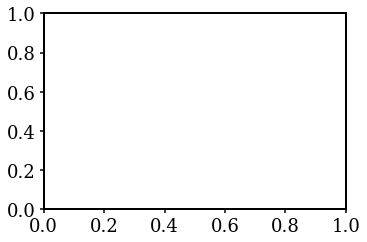

In [3]:
plt.tight_layout()
plt.rc('lines', linewidth=1, markersize=2)
plt.rc('font', size=12, family='serif')
plt.rc('mathtext', fontset='stix')
plt.rc('axes', linewidth=2)
plt.rc('xtick.major', width=1.5, size=4)
plt.rc('ytick.major', width=1.5, size=4)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=18)
plt.subplots_adjust(bottom=0.2, left=0.2)

In [4]:
tik = time.clock()
df_cat=pd.read_csv('/Volumes/My Passport/cosmos_3dhst_v4.1.5_catalogs/cosmos_3dhst.v4.1.5.zbest.rf',delim_whitespace=True,header=None,comment='#',index_col=False)
df_cat.columns=["id", "z_best", "z_type", "z_spec", "DM", "L153", "nfilt153","L154","nfilt154", "L155", "nfilt155", "L161", "nfilt161", \
                "L162", "nfilt162","L163", "nfilt163", "L156", "nfilt156", "L157", "nfilt157", "L158", "nfilt158", "L159", "nfilt159", \
                "L160", "nfilt160", "L135", "nfilt135", "L136", "nfilt136","L137", "nfilt137", "L138", "nfilt138", "L139", "nfilt139", \
                "L270", "nfilt270", "L271", "nfilt271", "L272", "nfilt272", "L273", "nfilt273", "L274", "nfilt274", "L275", "nfilt275"]

# df = pd.read_csv('/Volumes/My Passport/GV_CMD_fn_table_20180904/matching_galaxies_cosmos_20180823_GV.csv', sep=',')
# df = pd.read_csv('/Volumes/My Passport/TPAGB/database/matching_galaxies_cosmos_20200206_PSB.csv', sep=',')
df = pd.read_csv('/Volumes/My Passport/TPAGB/database/matching_galaxies_cosmos_20200303_PSB.csv', sep=',')
df = pd.read_csv('/Volumes/My Passport/TPAGB/database/matching_galaxies_cosmos_20200317_PSB.csv', sep=',')
df.columns=['detector','ID','region','filename','chip']

df_photometry=pd.read_csv('/Volumes/My Passport/cosmos_3dhst.v4.1.cats/Catalog/cosmos_3dhst.v4.1.cat', delim_whitespace=True,header=None,comment='#',index_col=False)
df_photometry.columns=["id", "x", "y", "ra", "dec", "faper_F160W", "eaper_F160W", "faper_F140W", "eaper_F140W", "f_F160W", "e_F160W", "w_F160W",\
                    "f_U", "e_U", "w_U", "f_B", "e_B", "w_B","f_G", "e_G", "w_G", "f_V", "e_V", "w_V","f_F606W", "e_F606W","w_F606W", \
                    "f_R", "e_R", "w_R", "f_Rp", "e_Rp", "w_Rp","f_I", "e_I", "w_I", "f_Ip", "e_Ip", "w_Ip","f_F814W", "e_F814W","w_F814W", \
                    "f_Z", "e_Z", "w_Z", "f_Zp", "e_Zp", "w_Zp", "f_UVISTA_Y", "e_UVISTA_Y", "w_UVISTA_Y", "f_F125W", "e_F125W", "w_F125W",\
                    "f_J1", "e_J1", "w_J1", "f_J2", "e_J2", "w_J2", "f_J3", "e_J3", "w_J3", "f_J", "e_J", "w_J", "f_UVISTA_J", "e_UVISTA_J", "w_UVISTA_J",\
                    "f_F140W", "e_F140W", "w_F140W","f_H1", "e_H1", "w_H1", "f_H2", "e_H2", "w_H2", "f_H", "e_H", "w_H", "f_UVISTA_H", "e_UVISTA_H", "w_UVISTA_H", \
                    "f_K", "e_K","w_K", "f_Ks", "e_Ks", "w_Ks", "f_UVISTA_Ks", "e_UVISTA_Ks", "w_UVISTA_Ks","f_IRAC1", "e_IRAC1", "w_IRAC1", \
                    "f_IRAC2", "e_IRAC2", "w_IRAC2", "f_IRAC3", "e_IRAC3", "w_IRAC3", "f_IRAC4", "e_IRAC4", "w_IRAC4",\
                     "f_IA427", "e_IA427", "f_IA464", "e_IA464", "f_IA484", "e_IA484", "f_IA505", "e_IA505", "f_IA527", "e_IA527", "f_IA574", "e_IA574",\
                     "f_IA624", "e_IA624", "f_IA679", "e_IA679", "f_IA709", "e_IA709", "f_IA738", "e_IA738", "f_IA767", "e_IA767", "f_IA827", "e_IA827", \
                     "tot_cor", "wmin_ground", "wmin_hst", "wmin_irac", "wmin_wfc3", "z_spec", "star_flag",  "kron_radius", "a_image", "b_image", \
                     "theta_J2000", "class_star", "flux_radius", "fwhm_image", "flags", "IRAC1_contam", "IRAC2_contam", "IRAC3_contam", "IRAC4_contam",\
                      "contam_flag", "f140w_flag", "use_phot", "near_star", "nexp_f125w", "nexp_f140w", "nexp_f160w"]

df_fast = pd.read_csv('/Volumes/My Passport/cosmos_3dhst.v4.1.cats/Fast/cosmos_3dhst.v4.1.fout', delim_whitespace=True, header=None,comment='#',index_col=False)
df_fast.columns = ['id', 'z', 'ltau', 'metal','lage','Av','lmass','lsfr','lssfr','la2t','chi2']
tok = time.clock()
print('Time to read the catalogues:'+str(tok-tik))
df_zfit = pd.read_csv('/Volumes/My Passport/cosmos_3dhst_v4.1.5_catalogs/cosmos_3dhst.v4.1.5.zfit.concat.dat',delim_whitespace=True,header=None,comment='#',index_col=False)
df_zfit.columns=['phot_id','grism_id','jh_mag','z_spec','z_peak_phot','z_phot_l95',\
                'z_phot_l68','z_phot_u68','z_phot_u95','z_max_grism','z_peak_grism',\
                'l95','l68','u68','u95','f_cover','f_flagged','max_contam','int_contam',\
                'f_negative','flag1','flag2']

tik2 = time.clock()

Time to read the catalogues:1.0694979999999998


In [5]:
# M05
norm_wavelength= 5500.0
df_Ma = pd.read_csv('/Volumes/My Passport/M09_ssp_pickles.sed',delim_whitespace=True,header=None,comment='#',index_col=False)# only solar metallicity is contained in this catalogue
df_Ma.columns = ['Age','ZH','l','Flambda']
age = df_Ma.Age
metallicity = df_Ma.ZH
wavelength = df_Ma.l
Flux = df_Ma.Flambda
age_1Gyr_index = np.where(age==1.0)[0]
age_1Gyr = age[age_1Gyr_index]
metallicity_1Gyr = metallicity[age_1Gyr_index]
wavelength_1Gyr = wavelength[age_1Gyr_index]
Flux_1Gyr = Flux[age_1Gyr_index]
F_5500_1Gyr_index=np.where(wavelength_1Gyr==norm_wavelength)[0]
F_5500_1Gyr = Flux_1Gyr[wavelength_1Gyr==norm_wavelength].values # this is the band to be normalized 


# ### M13
df_M13 = pd.read_csv('/Volumes/My Passport/M13_models/sed_M13.ssz002',delim_whitespace=True,header=None,comment='#',index_col=False)
df_M13.columns = ['Age','ZH','l','Flambda']
age_M13 = df_M13.Age
metallicity_M13 = df_M13.ZH
wavelength_M13 = df_M13.l
Flux_M13 = df_M13.Flambda
age_1Gyr_index_M13 = np.where(age_M13==1.0)[0]#[0]
age_1Gyr_M13 = age_M13[age_1Gyr_index_M13]
metallicity_1Gyr_M13 = metallicity_M13[age_1Gyr_index_M13]
wavelength_1Gyr_M13 = wavelength_M13[age_1Gyr_index_M13]
Flux_1Gyr_M13 = Flux_M13[age_1Gyr_index_M13]
F_5500_1Gyr_index_M13=np.where(abs(wavelength_1Gyr_M13-norm_wavelength)<15)[0]
F_5500_1Gyr_M13 = 0.5*(Flux_1Gyr_M13.loc[62271+F_5500_1Gyr_index_M13[0]]+Flux_1Gyr_M13.loc[62271+F_5500_1Gyr_index_M13[1]])


# ### BC03
df_BC = pd.read_csv('/Volumes/My Passport/ssp_900Myr_z02.spec',delim_whitespace=True,header=None,comment='#',index_col=False)
df_BC.columns=['Lambda','Flux']
wavelength_BC = df_BC.Lambda
Flux_BC = df_BC.Flux
F_6000_BC_index=np.where(wavelength_BC==norm_wavelength)[0]
Flux_BC_norm = Flux_BC[F_6000_BC_index]


### Read in the BC03 models High-resolution, with Stelib library, Salpeter IMF, solar metallicity
BC03_fn='/Volumes/My Passport/bc03/models/Stelib_Atlas/Salpeter_IMF/bc2003_hr_stelib_m62_salp_ssp.ised_ASCII'
BC03_file = open(BC03_fn,"r")
BC03_X = []
for line in BC03_file:
    BC03_X.append(line)
BC03_SSP_m62 = np.array(BC03_X)
BC03_age_list = np.array(BC03_SSP_m62[0].split()[1:])
BC03_age_list_num = BC03_age_list.astype(np.float)/1.0e9 # unit is Gyr
BC03_wave_list = np.array(BC03_SSP_m62[6].split()[1:])
BC03_wave_list_num = BC03_wave_list.astype(np.float)
BC03_flux_list = np.array(BC03_SSP_m62[7:-12])
BC03_flux_array = np.zeros((221,7178))
for i in range(221):
    BC03_flux_array[i,:] = BC03_flux_list[i].split()[1:]
    BC03_flux_array[i,:] = BC03_flux_array[i,:]/BC03_flux_array[i,2556]# Normalize the flux

tok2 = time.clock()
print('Time used for the read the models: '+str(tok2-tik2))



Time used for the read the models: 0.7576939999999999


In [6]:
## Prepare the M05 models and store in the right place
M05_model = []
M05_model_list=[]
for i in range(30):
    age_index = i
    age_prior = df_Ma.Age.unique()[age_index]
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')
    fn1 = '/Volumes/My Passport/SSP_models/new/M05_age_'+'0_'+split_galaxy_age_string[1]+'_Av_00_z002.csv'
    M05_model = np.loadtxt(fn1)
    M05_model_list.append(M05_model)
fn1 = '/Volumes/My Passport/SSP_models/new/M05_age_1_Av_00_z002.csv'
fn2 = '/Volumes/My Passport/SSP_models/new/M05_age_1_5_Av_00_z002.csv'
M05_model = np.loadtxt(fn1)
M05_model_list.append(M05_model)
M05_model = np.loadtxt(fn2)
M05_model_list.append(M05_model)
for i in range(32,46):
    age_index = i
    age_prior = df_Ma.Age.unique()[age_index]
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')
    fn2 = '/Volumes/My Passport/SSP_models/new/M05_age_'+split_galaxy_age_string[0]+'_Av_00_z002.csv'
    M05_model = np.loadtxt(fn2)
    M05_model_list.append(M05_model)

## Prepare the M13 models and store in the right place
M13_model = []
M13_model_list=[]
fn1 = '/Volumes/My Passport/SSP_models/new/M13_age_1e-06_Av_00_z002.csv'
fn2 = '/Volumes/My Passport/SSP_models/new/M13_age_0_0001_Av_00_z002.csv'
M13_model = np.genfromtxt(fn1)
M13_model_list.append(M13_model)
M13_model = np.genfromtxt(fn2)
M13_model_list.append(M13_model)
for i in range(2,51):
    age_index = i
    age_prior = df_M13.Age.unique()[age_index]
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')
    fn1 = '/Volumes/My Passport/SSP_models/new/M13_age_'+'0_'+split_galaxy_age_string[1]+'_Av_00_z002.csv'
    M13_model = np.loadtxt(fn1)
    M13_model_list.append(M13_model)
fn1 = '/Volumes/My Passport/SSP_models/new/M13_age_1_Av_00_z002.csv'
fn2 = '/Volumes/My Passport/SSP_models/new/M13_age_1_5_Av_00_z002.csv'
M13_model = np.loadtxt(fn1)
M13_model_list.append(M13_model)
M13_model = np.loadtxt(fn2)
M13_model_list.append(M13_model)
for i in range(53,67):
    age_index = i
    age_prior = df_M13.Age.unique()[age_index]
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')
    fn2 = '/Volumes/My Passport/SSP_models/new/M13_age_'+split_galaxy_age_string[0]+'_Av_00_z002.csv'
    M13_model = np.loadtxt(fn2)
    M13_model_list.append(M13_model)

In [19]:
def read_spectra(row):
    """
    region: default 1 means the first region mentioned in the area, otherwise, the second region/third region
    """
    detector=df.detector[row]
    region = df.region[row]
    chip = df.chip[row]
    ID = df.ID[row]
    redshift_1=df_cat.loc[ID-1].z_best
    mag = -2.5*np.log10(df_cat.loc[ID-1].L161)+25+0.02
    #print mag
    #WFC3 is using the infrared low-resolution grism, and here we are using the z band
    if detector == 'WFC3':
        filename="/Volumes/My Passport/COSMOS_WFC3_V4.1.5/cosmos-"+"{0:02d}".format(region)+"/1D/ASCII/cosmos-"+"{0:02d}".format(region)+"-G141_"+"{0:05d}".format(ID)+".1D.ascii"
        OneD_1 = np.loadtxt(filename,skiprows=1)
    if detector =="ACS":
        filename="/Volumes/My Passport/COSMOS_ACS_V4.1.5/acs-cosmos-"+"{0:02d}".format(region)+"/1D/FITS/"+df.filename[row]
        OneD_1 = fits.getdata(filename, ext=1)
    return ID, OneD_1,redshift_1, mag
def Lick_index_ratio(wave, flux, band=3):
    if band == 3:
        blue_min = 1.06e4  # 1.072e4#
        blue_max = 1.08e4  # 1.08e4#
        red_min = 1.12e4  # 1.097e4#
        red_max = 1.14e4  # 1.106e4#
        band_min = blue_max
        band_max = red_min


    # Blue
    blue_mask = (wave >= blue_min) & (wave <= blue_max)
    blue_wave = wave[blue_mask]
    blue_flux = flux[blue_mask]

    # Red
    red_mask = (wave >= red_min) & (wave <= red_max)
    red_wave = wave[red_mask]
    red_flux = flux[red_mask]

    band_mask = (wave >= band_min) & (wave <= band_max)
    band_wave = wave[band_mask]
    band_flux = flux[band_mask]

    if len(blue_wave) == len(red_wave) and len(blue_wave) != 0:
        ratio = np.mean(blue_flux) / np.mean(red_flux)
    elif red_wave == []:
        ratio = np.mean(blue_flux) / np.mean(red_flux)
    elif len(blue_wave) != 0 and len(red_wave) != 0:
        ratio = np.mean(blue_flux) / np.mean(red_flux)

    # ratio_err = np.sqrt(np.sum(1/red_flux**2*blue_flux_err**2)+np.sum((blue_flux/red_flux**2*red_flux_err)**2))

    return ratio  # , ratio_err
def binning_spec_keep_shape(wave,flux,bin_size):
    wave_binned = wave
    flux_binned = np.zeros(len(wave))
    for i in range((int(len(wave)/bin_size))):
        flux_binned[bin_size*i:bin_size*(i+1)] = np.mean(flux[bin_size*i:bin_size*(i+1)])
    return wave_binned, flux_binned#, flux_err_binned
def derive_1D_spectra_Av_corrected(OneD_1, redshift_1, rownumber, wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod, A_v):
    """
    OneD_1 is the oneD spectra
    redshift_1 is the redshift of the spectra
    rownumber is the row number in order to store the spectra
    """
    region = df.region[rownumber]
    ID = df.ID[rownumber]
    n = len(OneD_1)
    age = 10**(df_fast.loc[ID-1].lage)/1e9 ## in Gyr
    metal = df_fast.loc[ID-1].metal
    sfr = 10**(df_fast.loc[ID-1].lsfr)
    intrinsic_Av = df_fast.loc[ID-1].Av
    
    
    # Normalize and smooth the models, smoothing BC to delta_lambda =14, smoothing Ma05 to be delta_lambda = 10
    norm_factor_BC = int((OneD_1[int(n/2+1)][0]-OneD_1[int(n/2)][0])/(1+redshift_1)/1)
    norm_limit_BC = int(5930/norm_factor_BC)*norm_factor_BC+400
    smooth_wavelength_BC_1 = wavelength_BC[400:norm_limit_BC].values.reshape(-1,norm_factor_BC).mean(axis=1)
    smooth_wavelength_BC = np.hstack([smooth_wavelength_BC_1,wavelength_BC[norm_limit_BC:]])

    smooth_Flux_BC_1 = Flux_BC[400:norm_limit_BC].values.reshape(-1,norm_factor_BC).mean(axis=1)
    smooth_Flux_BC = np.hstack([smooth_Flux_BC_1,Flux_BC[norm_limit_BC:]])/Flux_BC_norm.values[0]
    
    norm_factor_Ma = int((OneD_1[int(n/2+1)][0]-OneD_1[int(n/2)][0])/(1+redshift_1)/5)
    norm_limit_Ma = int(4770/norm_factor_Ma)*norm_factor_Ma
    smooth_wavelength_Ma = wavelength_1Gyr[:norm_limit_Ma].values.reshape(-1,norm_factor_Ma).mean(axis=1)
    smooth_Flux_Ma_1Gyr = Flux_1Gyr[:norm_limit_Ma].values.reshape(-1,norm_factor_Ma).mean(axis=1)/F_5500_1Gyr
    
    if redshift_1<=0.1:
        i = 33
        temp_norm_wave = wave_list[i]/(1+redshift_1)
        index_wave_norm = find_nearest(smooth_wavelength_BC,temp_norm_wave)
        norm_band = photometric_flux[i] 
        #plt.text(5000,0.55,'normalized at IA574: rest frame '+"{0:.2f}".format(temp_norm_wave),fontsize=16)
        #plt.axvline(temp_norm_wave,linewidth=2,color='b')
    elif redshift_1<=0.19:
        i = 25
        temp_norm_wave = wave_list[i]/(1+redshift_1)
        index_wave_norm = find_nearest(smooth_wavelength_BC,temp_norm_wave)
        norm_band = photometric_flux[i] 
        #plt.text(5000,0.55,'normalized at Rp: rest frame '+"{0:.2f}".format(temp_norm_wave),fontsize=16)
        #plt.axvline(temp_norm_wave,linewidth=2,color='b')
    elif redshift_1<=0.28:
        i = 35
        temp_norm_wave = wave_list[i]/(1+redshift_1)
        index_wave_norm = find_nearest(smooth_wavelength_BC,temp_norm_wave)
        norm_band = photometric_flux[i] #i
        #plt.text(5000,0.55,'normalized at IA679: rest frame '+"{0:.2f}".format(temp_norm_wave),fontsize=16)
        #plt.axvline(temp_norm_wave,linewidth=2,color='b') 
    elif redshift_1<=0.39:
        i = 37
        temp_norm_wave = wave_list[i]/(1+redshift_1)
        index_wave_norm = find_nearest(smooth_wavelength_BC,temp_norm_wave)
        norm_band = photometric_flux[i] 
        #plt.text(5000,0.55,'normalized at IA738: rest frame '+"{0:.2f}".format(temp_norm_wave),fontsize=16)
        #plt.axvline(temp_norm_wave,linewidth=2,color='b')
    elif redshift_1<=0.45:
        i = 38
        temp_norm_wave = wave_list[i]/(1+redshift_1)
        index_wave_norm = find_nearest(smooth_wavelength_BC,temp_norm_wave)
        norm_band = photometric_flux[i] 
        #plt.text(5000,0.55,'normalized at IA767: rest frame '+"{0:.2f}".format(temp_norm_wave),fontsize=16)
        #plt.axvline(temp_norm_wave,linewidth=2,color='b')
    elif redshift_1<=0.55:
        i = 39
        temp_norm_wave = wave_list[i]/(1+redshift_1)
        index_wave_norm = find_nearest(smooth_wavelength_BC,temp_norm_wave)
        norm_band = photometric_flux[i] 
        #plt.text(5000,0.55,'normalized at IA827: rest frame '+"{0:.2f}".format(temp_norm_wave),fontsize=16)
        #plt.axvline(temp_norm_wave,linewidth=2,color='b')
    elif redshift_1<=0.62:
        i = 4
        temp_norm_wave = wave_list[i]/(1+redshift_1)
        index_wave_norm = find_nearest(smooth_wavelength_BC,temp_norm_wave)
        norm_band = photometric_flux[i] 
        #plt.text(5000,0.55,'normalized at z: rest frame '+"{0:.2f}".format(temp_norm_wave),fontsize=16)
        #plt.axvline(temp_norm_wave,linewidth=2,color='b')
    else:
        i = 27
        temp_norm_wave = wave_list[i]/(1+redshift_1)
        index_wave_norm = find_nearest(smooth_wavelength_BC,temp_norm_wave)
        norm_band = photometric_flux[i] 
        #plt.text(5000,0.55,'normalized at Zp: rest frame '+"{0:.2f}".format(temp_norm_wave),fontsize=16)
        #plt.axvline(temp_norm_wave,linewidth=2,color='b')
    
    x = np.zeros(n)
    y = np.zeros(n)
    y_err = np.zeros(n)
    sensitivity = np.zeros(n)
    for i in range(0,n):
        x[i] = OneD_1[i][0]#/(1+redshift_1)
    print('wavelength range:',x[0],x[-1])
    spectra_extinction = calzetti00(x, A_v, 4.05)

    for i in range(n):
        spectra_flux_correction = 10**(0.4*spectra_extinction[i])# from obs to obtain the true value: the absolute value
        x[i] = x[i]/(1+redshift_1)
        y[i] = (OneD_1[i][1]-OneD_1[i][3])/OneD_1[i][6]*spectra_flux_correction#/Flux_0 # (flux-contamination)/sensitivity
        y_err[i] = OneD_1[i][2]/OneD_1[i][6]*spectra_flux_correction#/Flux_0
        sensitivity[i] = OneD_1[i][6]
    # end_index = np.argmin(np.diff(sensitivity[263:282],2)[1:],0)+263
    # start_index = np.argmin(np.diff(sensitivity[40:50],2)[1:])+42
    start_index = np.argmin(abs(x*(1+redshift_1)-11407.53))
    end_index = np.argmin(abs(x*(1+redshift_1)-16428.61))
    print('masking region:',x[start_index]*(1+redshift_1),x[end_index]*(1+redshift_1),start_index,end_index)
    plt.plot(x*(1+redshift_1),sensitivity,color='k')
    plt.plot(x[start_index:end_index]*(1+redshift_1),sensitivity[start_index:end_index],color='red')
    print('before masking',len(x))
    x = x[start_index:end_index]#[int(n*2/10):int(n*8/10)]
    y = y[start_index:end_index]*1e-17/norm_band#[int(n*2/10):int(n*8/10)]*1e-17/norm_band
    y_err = y_err[start_index:end_index]*1e-17/norm_band#[int(n*2/10):int(n*8/10)]*1e-17/norm_band
    print('after masking',len(x))

    # mask_non_neg_photo = np.where(photometric_flux>0)
    # wave_list = wave_list[mask_non_neg_photo]
    # band_list = band_list[mask_non_neg_photo]
    # photometric_flux = photometric_flux[mask_non_neg_photo]
    # photometric_flux_err = photometric_flux_err[mask_non_neg_photo]
    # photometric_flux_err_mod = photometric_flux_err_mod[mask_non_neg_photo]

    return x, y, y_err, wave_list/(1+redshift_1), band_list/(1+redshift_1), photometric_flux/norm_band, photometric_flux_err/norm_band, photometric_flux_err_mod/norm_band   
def model_identification(chi2_array,rtol=0.1):
    index = find_nearest(chi2_array,1)    
    model = np.mod(index,3)+1
    chi2_array_comp = abs(chi2_array-1)
    chi2_array_comp_idx = np.argsort(chi2_array_comp)[:2]
    if np.mod(chi2_array_comp_idx[0],3)==np.mod(chi2_array_comp_idx[1],3):
        chi2_array_comp_idx = np.argsort(chi2_array_comp)[1:3]
    chi2_min2_array = chi2_array[chi2_array_comp_idx]
    if np.isclose(chi2_min2_array[0],chi2_min2_array[1],rtol=rtol):
        model = 0
    return model
def model_from_chi2(df_opt):
    for i in range(len(df_opt)):
        chi2_array=df_opt.loc[i,['x2_M05_opt','x2_M13_opt','x2_BC_opt',\
                                 'x2_M05_MCMC50','x2_M13_MCMC50','x2_BC_MCMC50']].values
        chi2_spec_array=df_opt.loc[i,['x2_spectra_M05_opt','x2_spectra_M13_opt','x2_spectra_BC_opt',\
                                      'x2_spectra_M05_MCMC50','x2_spectra_M13_MCMC50','x2_spectra_BC_MCMC50']].values
        chi2_phot_array=df_opt.loc[i,['x2_photo_M05_opt','x2_photo_M13_opt','x2_photo_BC_opt',\
                                      'x2_photo_M05_MCMC50','x2_photo_M13_MCMC50','x2_photo_BC_MCMC50']].values
        age_array=df_opt.loc[i,['M05_age_opt','M13_age_opt','BC_age_opt',\
                                'M05_age_MCMC50','M13_age_MCMC50','BC_age_MCMC50']].values
        age_std_array=df_opt.loc[i,['M05_age_std','M13_age_std','BC_age_std',\
                                    'M05_age_std','M13_age_std','BC_age_std']].values
        AV_array=df_opt.loc[i,['M05_AV_opt','M13_AV_opt','BC_AV_opt',\
                               'M05_AV_MCMC50','M13_AV_MCMC50','BC_AV_MCMC50']].values
        AV_std_array=df_opt.loc[i,['M05_AV_std','M13_AV_std','BC_AV_std',\
                                   'M05_AV_std','M13_AV_std','BC_AV_std']].values        
        index = find_nearest(chi2_array,0)    
        df_opt.loc[i,'model'] = np.mod(index,3)+1
        df_opt.loc[i,'model_new']=model_identification(chi2_array)
        df_opt.loc[i,'best_chi2']=chi2_array[index]
        df_opt.loc[i,'best_chi2_spec']=chi2_spec_array[index]
        df_opt.loc[i,'best_chi2_phot']=chi2_phot_array[index]
        df_opt.loc[i,'age_opt']=age_array[index]
        df_opt.loc[i,'age_opt_std']=age_std_array[index]
        df_opt.loc[i,'AV_opt']=AV_array[index]
        df_opt.loc[i,'AV_opt_std']=AV_std_array[index]
    return df_opt

def binning_spec_keep_shape_x(wave,flux,flux_err,bin_size):
    wave_binned = wave
    flux_binned = np.zeros(len(wave))
    flux_err_binned = np.zeros(len(wave))
    for i in range((int(len(wave)/bin_size))+1):
        flux_binned[bin_size*i:bin_size*(i+1)] = np.mean(flux[bin_size*i:bin_size*(i+1)])
        flux_err_binned[bin_size*i:bin_size*(i+1)] = np.mean(flux_err[bin_size*i:bin_size*(i+1)])
    return wave_binned, flux_binned, flux_err_binned

def minimize_age_AV_vector_weighted(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    # print('minimize process age av grid',X)

    n=len(x)
    age_index = find_nearest(df_Ma.Age.unique(), galaxy_age)
    age_prior = df_Ma.Age.unique()[age_index]
    AV_string = str(intrinsic_Av)
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')
    # print(age_prior)
    
    if age_prior < 1:
        if galaxy_age < age_prior:
            model1 = (M05_model_list[age_index]*(galaxy_age-df_Ma.Age.unique()[age_index-1]) \
                + M05_model_list[age_index-1]*(age_prior-galaxy_age))/(df_Ma.Age.unique()[age_index]-df_Ma.Age.unique()[age_index-1])
        elif galaxy_age > age_prior:
            model1 = (M05_model_list[age_index]*(df_Ma.Age.unique()[age_index+1]-galaxy_age) \
                + M05_model_list[age_index+1]*(galaxy_age-age_prior))/(df_Ma.Age.unique()[age_index+1]-df_Ma.Age.unique()[age_index])
        elif galaxy_age == age_prior:
            model1 = M05_model_list[age_index]
    elif age_prior == 1.5:
        if galaxy_age >=1.25 and galaxy_age <1.5:
            model1 = 2.*(1.5-galaxy_age)*M05_model_list[30] + 2.*(galaxy_age-1.0)*M05_model_list[31]
        elif galaxy_age >= 1.5 and galaxy_age <= 1.75:
            model1 = 2.*(2.0-galaxy_age)*M05_model_list[31] + 2.*(galaxy_age-1.5)*M05_model_list[32]
    elif len(split_galaxy_age_string[1])==1:
        if galaxy_age >= 1.0 and galaxy_age < 1.25:
            model1 = 2.*(1.5-galaxy_age)*M05_model_list[30] + 2.*(galaxy_age-1.0)*M05_model_list[31]
        elif galaxy_age >=1.75 and galaxy_age < 2.0:
            model1 = 2.*(2.0-galaxy_age)*M05_model_list[31] + 2.*(galaxy_age-1.5)*M05_model_list[32]
        elif galaxy_age >= 2.0 and galaxy_age < 3.0:
            model1 = (3.0-galaxy_age)*M05_model_list[32] + (galaxy_age-2.0)*M05_model_list[33]
        elif galaxy_age >= 3.0 and galaxy_age < 4.0:
            model1 = (4.0-galaxy_age)*M05_model_list[33] + (galaxy_age-3.0)*M05_model_list[34]
        elif galaxy_age >= 4.0 and galaxy_age < 5.0:
            model1 = (5.0-galaxy_age)*M05_model_list[34] + (galaxy_age-4.0)*M05_model_list[35]
        elif galaxy_age >= 5.0 and galaxy_age < 6.0:
            model1 = (6.0-galaxy_age)*M05_model_list[35] + (galaxy_age-5.0)*M05_model_list[36]
        elif galaxy_age >= 6.0 and galaxy_age < 7.0:
            model1 = (7.0-galaxy_age)*M05_model_list[36] + (galaxy_age-6.0)*M05_model_list[37]
        elif galaxy_age >= 7.0 and galaxy_age < 8.0:
            model1 = (8.0-galaxy_age)*M05_model_list[37] + (galaxy_age-7.0)*M05_model_list[38]
        elif galaxy_age >= 8.0 and galaxy_age < 9.0:
            model1 = (9.0-galaxy_age)*M05_model_list[38] + (galaxy_age-8.0)*M05_model_list[39]
        elif galaxy_age >= 9.0 and galaxy_age < 10.0:
            model1 = (10.0-galaxy_age)*M05_model_list[39] + (galaxy_age-9.0)*M05_model_list[40]
        elif galaxy_age >= 10.0 and galaxy_age < 11.0:
            model1 = (11.0-galaxy_age)*M05_model_list[40] + (galaxy_age-10.0)*M05_model_list[41]
        elif galaxy_age >= 11.0 and galaxy_age < 12.0:
            model1 = (12.0-galaxy_age)*M05_model_list[41] + (galaxy_age-11.0)*M05_model_list[42]
        elif galaxy_age >= 12.0 and galaxy_age < 13.0:
            model1 = (13.0-galaxy_age)*M05_model_list[42] + (galaxy_age-12.0)*M05_model_list[43]
        elif galaxy_age >= 13.0 and galaxy_age < 14.0:
            model1 = (14.0-galaxy_age)*M05_model_list[43] + (galaxy_age-13.0)*M05_model_list[44]
        elif galaxy_age >= 14.0 and galaxy_age < 15.0:
            model1 = (15.0-galaxy_age)*M05_model_list[44] + (galaxy_age-14.0)*M05_model_list[45]
        else:
            model1 = M05_model_list[age_index]

    spectra_extinction = calzetti00(model1[0,:], intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    M05_flux_center = model1[1,:]*spectra_flux_correction
    F_M05_index=700#167
    Flux_M05_norm_new = M05_flux_center[F_M05_index]
    smooth_Flux_Ma_1Gyr_new = M05_flux_center/Flux_M05_norm_new

    binning_index = find_nearest(model1[0,:],np.median(x))
    if binning_index == 0:
        binning_index = 1
    elif binning_index ==len(x):
        binning_index = len(x)-1
    if (x[int(n/2)]-x[int(n/2)-1]) > (model1[0,binning_index]-model1[0,binning_index-1]):
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(model1[0,binning_index]-model1[0,binning_index-1]))
        model_wave_binned,model_flux_binned = binning_spec_keep_shape(model1[0,:], smooth_Flux_Ma_1Gyr_new,binning_size)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        if np.isnan(x2):
            print('spectra chi2 is nan,binning model',model_flux_binned)
            print('spectra model wave', model1[0,:], model1[1,:], intrinsic_Av)
            print('model flux before binning', spectra_extinction, spectra_flux_correction, M05_flux_center, Flux_M05_norm_new)
        x2_photo = chisquare_photo(model_wave_binned, model_flux_binned, redshift_1, wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod)
        # print('binning model, model 1', n, (model1[0,binning_index]-model1[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)
    else:
        binning_size = int((model1[0,binning_index]-model1[0,binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned=binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, model1[0,:], smooth_Flux_Ma_1Gyr_new) 
        # print('binning data, model 1', n, (model1[0,binning_index]-model1[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)
        x2_photo = chisquare_photo(model1[0,:], smooth_Flux_Ma_1Gyr_new, redshift_1, wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod)
    
    try: 
        if 0.01<galaxy_age<13 and 0.0<=intrinsic_Av<=4.0 and not np.isinf(0.5*x2+0.5*x2_photo):
            x2_tot = 0.5*weight1*x2+0.5*weight2*x2_photo
        else:
            x2_tot = np.inf
    except ValueError: # NaN value case
        x2_tot = np.inf
        print('ValueError', x2_tot)
    # print('M05 x2 tot:',x2, x2_photo, x2_tot)
    return x2_tot
def lg_minimize_age_AV_vector_weighted(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(df_Ma.Age.unique(), galaxy_age)
    age_prior = df_Ma.Age.unique()[age_index]
    AV_string = str(intrinsic_Av)
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')

    if age_prior < 1:
        if galaxy_age < age_prior:
            model1 = (M05_model_list[age_index]*(galaxy_age-df_Ma.Age.unique()[age_index-1]) \
                + M05_model_list[age_index-1]*(age_prior-galaxy_age))/(df_Ma.Age.unique()[age_index]-df_Ma.Age.unique()[age_index-1])
        elif galaxy_age > age_prior:
            model1 = (M05_model_list[age_index]*(df_Ma.Age.unique()[age_index+1]-galaxy_age) \
                + M05_model_list[age_index+1]*(galaxy_age-age_prior))/(df_Ma.Age.unique()[age_index+1]-df_Ma.Age.unique()[age_index])
        elif galaxy_age == age_prior:
            model1 = M05_model_list[age_index]
    elif age_prior == 1.5:
        if galaxy_age >=1.25 and galaxy_age <1.5:
            model1 = 2.*(1.5-galaxy_age)*M05_model_list[30] + 2.*(galaxy_age-1.0)*M05_model_list[31]
        elif galaxy_age >= 1.5 and galaxy_age <= 1.75:
            model1 = 2.*(2.0-galaxy_age)*M05_model_list[31] + 2.*(galaxy_age-1.5)*M05_model_list[32]
    elif len(split_galaxy_age_string[1])==1:
        if galaxy_age >= 1.0 and galaxy_age < 1.25:
            model1 = 2.*(1.5-galaxy_age)*M05_model_list[30] + 2.*(galaxy_age-1.0)*M05_model_list[31]
        elif galaxy_age >=1.75 and galaxy_age < 2.0:
            model1 = 2.*(2.0-galaxy_age)*M05_model_list[31] + 2.*(galaxy_age-1.5)*M05_model_list[32]
        elif galaxy_age >= 2.0 and galaxy_age < 3.0:
            model1 = (3.0-galaxy_age)*M05_model_list[32] + (galaxy_age-2.0)*M05_model_list[33]
        elif galaxy_age >= 3.0 and galaxy_age < 4.0:
            model1 = (4.0-galaxy_age)*M05_model_list[33] + (galaxy_age-3.0)*M05_model_list[34]
        elif galaxy_age >= 4.0 and galaxy_age < 5.0:
            model1 = (5.0-galaxy_age)*M05_model_list[34] + (galaxy_age-4.0)*M05_model_list[35]
        elif galaxy_age >= 5.0 and galaxy_age < 6.0:
            model1 = (6.0-galaxy_age)*M05_model_list[35] + (galaxy_age-5.0)*M05_model_list[36]
        elif galaxy_age >= 6.0 and galaxy_age < 7.0:
            model1 = (7.0-galaxy_age)*M05_model_list[36] + (galaxy_age-6.0)*M05_model_list[37]
        elif galaxy_age >= 7.0 and galaxy_age < 8.0:
            model1 = (8.0-galaxy_age)*M05_model_list[37] + (galaxy_age-7.0)*M05_model_list[38]
        elif galaxy_age >= 8.0 and galaxy_age < 9.0:
            model1 = (9.0-galaxy_age)*M05_model_list[38] + (galaxy_age-8.0)*M05_model_list[39]
        elif galaxy_age >= 9.0 and galaxy_age < 10.0:
            model1 = (10.0-galaxy_age)*M05_model_list[39] + (galaxy_age-9.0)*M05_model_list[40]
        elif galaxy_age >= 10.0 and galaxy_age < 11.0:
            model1 = (11.0-galaxy_age)*M05_model_list[40] + (galaxy_age-10.0)*M05_model_list[41]
        elif galaxy_age >= 11.0 and galaxy_age < 12.0:
            model1 = (12.0-galaxy_age)*M05_model_list[41] + (galaxy_age-11.0)*M05_model_list[42]
        elif galaxy_age >= 12.0 and galaxy_age < 13.0:
            model1 = (13.0-galaxy_age)*M05_model_list[42] + (galaxy_age-12.0)*M05_model_list[43]
        elif galaxy_age >= 13.0 and galaxy_age < 14.0:
            model1 = (14.0-galaxy_age)*M05_model_list[43] + (galaxy_age-13.0)*M05_model_list[44]
        elif galaxy_age >= 14.0 and galaxy_age < 15.0:
            model1 = (15.0-galaxy_age)*M05_model_list[44] + (galaxy_age-14.0)*M05_model_list[45]
        else:
            model1 = M05_model_list[age_index]

    spectra_extinction = calzetti00(model1[0,:], intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    M05_flux_center = model1[1,:]*spectra_flux_correction
    F_M05_index=700#167
    Flux_M05_norm_new = M05_flux_center[F_M05_index]
    smooth_Flux_Ma_1Gyr_new = M05_flux_center/Flux_M05_norm_new

    binning_index = find_nearest(model1[0,:],np.median(x))
    if binning_index == 0:
        binning_index = 1
    elif binning_index ==len(x):
        binning_index = len(x)-1
    if (x[int(n/2)]-x[int(n/2)-1]) > (model1[0,binning_index]-model1[0,binning_index-1]):
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(model1[0,binning_index]-model1[0,binning_index-1]))
        model_wave_binned,model_flux_binned = binning_spec_keep_shape(model1[0,:], smooth_Flux_Ma_1Gyr_new,binning_size)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # x2_photo = chisquare_photo(model_wave_binned, model_flux_binned, redshift_1,wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod)
        x2_photo = chisquare_photo(model_wave_binned, model_flux_binned, redshift_1,wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod)
        # print('binning model, model 1', n, (model1[0,binning_index]-model1[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)
    else:
        binning_size = int((model1[0,binning_index]-model1[0,binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned=binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, model1[0,:], smooth_Flux_Ma_1Gyr_new) 
        x2_photo = chisquare_photo(model1[0,:], smooth_Flux_Ma_1Gyr_new,redshift_1,wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod)

        # x2_photo = chisquare_photo(model1[0,:], smooth_Flux_Ma_1Gyr_new, redshift_1,wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod)
        # print('binning data, model 1', n, (model1[0,binning_index]-model1[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)
    # print('binning size, model 1', n, (model1[0,binning_index]-model1[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)
    # x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, model1[0,:], smooth_Flux_Ma_1Gyr_new)
    
    try: 
        if 0.01<galaxy_age<13 and 0.0<=intrinsic_Av<=4.0 and not np.isinf(0.5*x2+0.5*x2_photo):
            lnprobval = -0.5*(0.5*x2+0.5*x2_photo)#np.log(np.exp(-0.5*(0.5*weight1*x2+0.5*weight2*x2_photo)))
            if np.isnan(lnprobval):
                lnprobval = -np.inf
        else:
            lnprobval = -np.inf
    except ValueError: # NaN value case
        lnprobval = -np.inf
        print('valueError',lnprobval)
    # print('lnprob:',lnprobval, x2, x2_photo)
    return lnprobval
def minimize_age_AV_vector_weighted_return_flux(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(df_Ma.Age.unique(), galaxy_age)
    age_prior = df_Ma.Age.unique()[age_index]
    #print('galaxy age', galaxy_age, 'age prior:', age_prior)
    AV_string = str(intrinsic_Av)
    #print('intrinsic Av:', intrinsic_Av)
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')

    if age_prior < 1:
        if galaxy_age < age_prior:
            model1 = (M05_model_list[age_index]*(galaxy_age-df_Ma.Age.unique()[age_index-1]) \
                + M05_model_list[age_index-1]*(age_prior-galaxy_age))/(df_Ma.Age.unique()[age_index]-df_Ma.Age.unique()[age_index-1])
        elif galaxy_age > age_prior:
            model1 = (M05_model_list[age_index]*(df_Ma.Age.unique()[age_index+1]-galaxy_age) \
                + M05_model_list[age_index+1]*(galaxy_age-age_prior))/(df_Ma.Age.unique()[age_index+1]-df_Ma.Age.unique()[age_index])
        elif galaxy_age == age_prior:
            model1 = M05_model_list[age_index]
    elif age_prior == 1.5:
        if galaxy_age >=1.25 and galaxy_age <1.5:
            model1 = 2.*(1.5-galaxy_age)*M05_model_list[30] + 2.*(galaxy_age-1.0)*M05_model_list[31]
        elif galaxy_age >= 1.5 and galaxy_age <= 1.75:
            model1 = 2.*(2.0-galaxy_age)*M05_model_list[31] + 2.*(galaxy_age-1.5)*M05_model_list[32]
    elif len(split_galaxy_age_string[1])==1:
        if galaxy_age >= 1.0 and galaxy_age < 1.25:
            model1 = 2.*(1.5-galaxy_age)*M05_model_list[30] + 2.*(galaxy_age-1.0)*M05_model_list[31]
        elif galaxy_age >=1.75 and galaxy_age < 2.0:
            model1 = 2.*(2.0-galaxy_age)*M05_model_list[31] + 2.*(galaxy_age-1.5)*M05_model_list[32]
        elif galaxy_age >= 2.0 and galaxy_age < 3.0:
            model1 = (3.0-galaxy_age)*M05_model_list[32] + (galaxy_age-2.0)*M05_model_list[33]
        elif galaxy_age >= 3.0 and galaxy_age < 4.0:
            model1 = (4.0-galaxy_age)*M05_model_list[33] + (galaxy_age-3.0)*M05_model_list[34]
        elif galaxy_age >= 4.0 and galaxy_age < 5.0:
            model1 = (5.0-galaxy_age)*M05_model_list[34] + (galaxy_age-4.0)*M05_model_list[35]
        elif galaxy_age >= 5.0 and galaxy_age < 6.0:
            model1 = (6.0-galaxy_age)*M05_model_list[35] + (galaxy_age-5.0)*M05_model_list[36]
        elif galaxy_age >= 6.0 and galaxy_age < 7.0:
            model1 = (7.0-galaxy_age)*M05_model_list[36] + (galaxy_age-6.0)*M05_model_list[37]
        elif galaxy_age >= 7.0 and galaxy_age < 8.0:
            model1 = (8.0-galaxy_age)*M05_model_list[37] + (galaxy_age-7.0)*M05_model_list[38]
        elif galaxy_age >= 8.0 and galaxy_age < 9.0:
            model1 = (9.0-galaxy_age)*M05_model_list[38] + (galaxy_age-8.0)*M05_model_list[39]
        elif galaxy_age >= 9.0 and galaxy_age < 10.0:
            model1 = (10.0-galaxy_age)*M05_model_list[39] + (galaxy_age-9.0)*M05_model_list[40]
        elif galaxy_age >= 10.0 and galaxy_age < 11.0:
            model1 = (11.0-galaxy_age)*M05_model_list[40] + (galaxy_age-10.0)*M05_model_list[41]
        elif galaxy_age >= 11.0 and galaxy_age < 12.0:
            model1 = (12.0-galaxy_age)*M05_model_list[41] + (galaxy_age-11.0)*M05_model_list[42]
        elif galaxy_age >= 12.0 and galaxy_age < 13.0:
            model1 = (13.0-galaxy_age)*M05_model_list[42] + (galaxy_age-12.0)*M05_model_list[43]
        elif galaxy_age >= 13.0 and galaxy_age < 14.0:
            model1 = (14.0-galaxy_age)*M05_model_list[43] + (galaxy_age-13.0)*M05_model_list[44]
        elif galaxy_age >= 14.0 and galaxy_age < 15.0:
            model1 = (15.0-galaxy_age)*M05_model_list[44] + (galaxy_age-14.0)*M05_model_list[45]
        else:
            model1 = M05_model_list[age_index]
    
    spectra_extinction = calzetti00(model1[0,:], intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    M05_flux_center = model1[1,:]*spectra_flux_correction
    F_M05_index=700#167
    Flux_M05_norm_new = M05_flux_center[F_M05_index]
    smooth_Flux_Ma_1Gyr_new = M05_flux_center/Flux_M05_norm_new

    binning_index = find_nearest(model1[0,:],np.median(x))
    if binning_index == 0:
        binning_index = 1
    elif binning_index ==len(x):
        binning_index = len(x)-1
    if (x[int(n/2)]-x[int(n/2)-1]) > (model1[0,binning_index]-model1[0,binning_index-1]):
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(model1[0,binning_index]-model1[0,binning_index-1]))
        model_wave_binned,model_flux_binned = binning_spec_keep_shape(model1[0,:], smooth_Flux_Ma_1Gyr_new,binning_size)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # x2_photo = chisquare_photo(model_wave_binned, model_flux_binned, redshift_1,wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod)
        x2_photo = chisquare_photo(model_wave_binned, model_flux_binned, redshift_1,wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod)

        # print('binning model, model 1', n, (model1[0,binning_index]-model1[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)
    else:
        binning_size = int((model1[0,binning_index]-model1[0,binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned=binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, model1[0,:], smooth_Flux_Ma_1Gyr_new) 
        x2_photo = chisquare_photo(model1[0,:], smooth_Flux_Ma_1Gyr_new, redshift_1,wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod)

        # x2_photo = chisquare_photo(model1[0,:], smooth_Flux_Ma_1Gyr_new, redshift_1,wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod)
        # print('binning data, model 1', n, (model1[0,binning_index]-model1[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)
    # x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, model1[0,:], smooth_Flux_Ma_1Gyr_new)
    try: 
        if 0.01<galaxy_age<13 and 0.0<=intrinsic_Av<=4.0 and not np.isinf(0.5*x2+0.5*x2_photo):
            x2_tot = 0.5*weight1*x2+0.5*weight2*x2_photo
        else:
            x2_tot = np.inf
    except ValueError: # NaN value case
        x2_tot = np.inf
        print('valueError', x2_tot)
    # print('model wave range', model1[0,0], model1[0,-1])

    return x2_tot, model1[0,:], smooth_Flux_Ma_1Gyr_new
def minimize_age_AV_vector_weighted_return_chi2_sep(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(df_Ma.Age.unique(), galaxy_age)
    age_prior = df_Ma.Age.unique()[age_index]
    #print('galaxy age', galaxy_age, 'age prior:', age_prior)
    AV_string = str(intrinsic_Av)
    #print('intrinsic Av:', intrinsic_Av)
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')

    if age_prior < 1:
        if galaxy_age < age_prior:
            model1 = (M05_model_list[age_index]*(galaxy_age-df_Ma.Age.unique()[age_index-1]) \
                + M05_model_list[age_index-1]*(age_prior-galaxy_age))/(df_Ma.Age.unique()[age_index]-df_Ma.Age.unique()[age_index-1])
        elif galaxy_age > age_prior:
            model1 = (M05_model_list[age_index]*(df_Ma.Age.unique()[age_index+1]-galaxy_age) \
                + M05_model_list[age_index+1]*(galaxy_age-age_prior))/(df_Ma.Age.unique()[age_index+1]-df_Ma.Age.unique()[age_index])
        elif galaxy_age == age_prior:
            model1 = M05_model_list[age_index]
    elif age_prior == 1.5:
        if galaxy_age >=1.25 and galaxy_age <1.5:
            model1 = 2.*(1.5-galaxy_age)*M05_model_list[30] + 2.*(galaxy_age-1.0)*M05_model_list[31]
        elif galaxy_age >= 1.5 and galaxy_age <= 1.75:
            model1 = 2.*(2.0-galaxy_age)*M05_model_list[31] + 2.*(galaxy_age-1.5)*M05_model_list[32]
    elif len(split_galaxy_age_string[1])==1:
        if galaxy_age >= 1.0 and galaxy_age < 1.25:
            model1 = 2.*(1.5-galaxy_age)*M05_model_list[30] + 2.*(galaxy_age-1.0)*M05_model_list[31]
        elif galaxy_age >=1.75 and galaxy_age < 2.0:
            model1 = 2.*(2.0-galaxy_age)*M05_model_list[31] + 2.*(galaxy_age-1.5)*M05_model_list[32]
        elif galaxy_age >= 2.0 and galaxy_age < 3.0:
            model1 = (3.0-galaxy_age)*M05_model_list[32] + (galaxy_age-2.0)*M05_model_list[33]
        elif galaxy_age >= 3.0 and galaxy_age < 4.0:
            model1 = (4.0-galaxy_age)*M05_model_list[33] + (galaxy_age-3.0)*M05_model_list[34]
        elif galaxy_age >= 4.0 and galaxy_age < 5.0:
            model1 = (5.0-galaxy_age)*M05_model_list[34] + (galaxy_age-4.0)*M05_model_list[35]
        elif galaxy_age >= 5.0 and galaxy_age < 6.0:
            model1 = (6.0-galaxy_age)*M05_model_list[35] + (galaxy_age-5.0)*M05_model_list[36]
        elif galaxy_age >= 6.0 and galaxy_age < 7.0:
            model1 = (7.0-galaxy_age)*M05_model_list[36] + (galaxy_age-6.0)*M05_model_list[37]
        elif galaxy_age >= 7.0 and galaxy_age < 8.0:
            model1 = (8.0-galaxy_age)*M05_model_list[37] + (galaxy_age-7.0)*M05_model_list[38]
        elif galaxy_age >= 8.0 and galaxy_age < 9.0:
            model1 = (9.0-galaxy_age)*M05_model_list[38] + (galaxy_age-8.0)*M05_model_list[39]
        elif galaxy_age >= 9.0 and galaxy_age < 10.0:
            model1 = (10.0-galaxy_age)*M05_model_list[39] + (galaxy_age-9.0)*M05_model_list[40]
        elif galaxy_age >= 10.0 and galaxy_age < 11.0:
            model1 = (11.0-galaxy_age)*M05_model_list[40] + (galaxy_age-10.0)*M05_model_list[41]
        elif galaxy_age >= 11.0 and galaxy_age < 12.0:
            model1 = (12.0-galaxy_age)*M05_model_list[41] + (galaxy_age-11.0)*M05_model_list[42]
        elif galaxy_age >= 12.0 and galaxy_age < 13.0:
            model1 = (13.0-galaxy_age)*M05_model_list[42] + (galaxy_age-12.0)*M05_model_list[43]
        elif galaxy_age >= 13.0 and galaxy_age < 14.0:
            model1 = (14.0-galaxy_age)*M05_model_list[43] + (galaxy_age-13.0)*M05_model_list[44]
        elif galaxy_age >= 14.0 and galaxy_age < 15.0:
            model1 = (15.0-galaxy_age)*M05_model_list[44] + (galaxy_age-14.0)*M05_model_list[45]
        else:
            model1 = M05_model_list[age_index]

    spectra_extinction = calzetti00(model1[0,:], intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    M05_flux_center = model1[1,:]*spectra_flux_correction
    F_M05_index=700#167
    Flux_M05_norm_new = M05_flux_center[F_M05_index]
    smooth_Flux_Ma_1Gyr_new = M05_flux_center/Flux_M05_norm_new
    
    binning_index = find_nearest(model1[0,:],np.median(x))
    if binning_index == 0:
        binning_index = 1
    elif binning_index ==len(x):
        binning_index = len(x)-1
    if (x[int(n/2)]-x[int(n/2)-1]) > (model1[0,binning_index]-model1[0,binning_index-1]):
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(model1[0,binning_index]-model1[0,binning_index-1]))
        model_wave_binned,model_flux_binned = binning_spec_keep_shape(model1[0,:], smooth_Flux_Ma_1Gyr_new,binning_size)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        x2_photo = chisquare_photo(model_wave_binned, model_flux_binned, redshift_1,wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod)

        # x2_photo = chisquare_photo(model_wave_binned, model_flux_binned, redshift_1,wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod)
        # print('binning model, model 1', n, (model1[0,binning_index]-model1[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)
    else:
        binning_size = int((model1[0,binning_index]-model1[0,binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned=binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, model1[0,:], smooth_Flux_Ma_1Gyr_new) 
        x2_photo = chisquare_photo(model1[0,:], smooth_Flux_Ma_1Gyr_new,redshift_1,wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod)
        # x2_photo = chisquare_photo(model1[0,:], smooth_Flux_Ma_1Gyr_new, redshift_1,wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod)
        # print('binning data, model 1', n, (model1[0,binning_index]-model1[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)
    # x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, model1[0,:], smooth_Flux_Ma_1Gyr_new)
    try: 
        if 0.01<galaxy_age<13 and 0.0<=intrinsic_Av<=4.0 and not np.isinf(0.5*x2+0.5*x2_photo):
            pass
        else:
            x2 = np.inf
            x2_photo = np.inf
    except ValueError: # NaN value case
        x2 = np.inf
        x2_photo = np.inf
        print('ValueError', x2)
    return x2, x2_photo

def minimize_age_AV_vector_weighted_M13(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    # print('minimize process age av grid M13:',X)

    n=len(x)
    age_index = find_nearest(df_M13.Age.unique(), galaxy_age)
    age_prior = df_M13.Age.unique()[age_index]
    age_prior = float(age_prior)
    AV_string = str(intrinsic_Av)
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')

    if age_prior < 1e-5:
        model2 = M13_model_list[0]
    elif age_prior >= 1e-5 and age_prior < 1:
        if galaxy_age < age_prior:
            model2 = (M13_model_list[age_index]*(galaxy_age-df_M13.Age.unique()[age_index-1]) \
                + M13_model_list[age_index-1]*(age_prior-galaxy_age))/(df_M13.Age.unique()[age_index]-df_M13.Age.unique()[age_index-1])
        elif galaxy_age > age_prior:
            model2 = (M13_model_list[age_index]*(df_M13.Age.unique()[age_index+1]-galaxy_age) \
                + M13_model_list[age_index+1]*(galaxy_age-age_prior))/(df_M13.Age.unique()[age_index+1]-df_M13.Age.unique()[age_index])
        elif galaxy_age == age_prior:
            model2 = M13_model_list[age_index] 
    elif age_prior == 1.5:
        if galaxy_age >=1.25 and galaxy_age <1.5:
            model2 = 2.*(1.5-galaxy_age)*M13_model_list[51] + 2.*(galaxy_age-1.0)*M13_model_list[52]
        elif galaxy_age >= 1.5 and galaxy_age <= 1.75:
            model2 = 2.*(2.0-galaxy_age)*M13_model_list[52] + 2.*(galaxy_age-1.5)*M13_model_list[53]
    elif len(split_galaxy_age_string[1])==1:
        if galaxy_age >= 1.0 and galaxy_age < 1.25:
            model2 = 2.*(1.5-galaxy_age)*M13_model_list[51] + 2.*(galaxy_age-1.0)*M13_model_list[52]
        elif galaxy_age >=1.75 and galaxy_age < 2.0:
            model2 = 2.*(2.0-galaxy_age)*M13_model_list[52] + 2.*(galaxy_age-1.5)*M13_model_list[53]
        elif galaxy_age >= 2.0 and galaxy_age < 3.0:
            model2 = (3.0-galaxy_age)*M13_model_list[53] + (galaxy_age-2.0)*M13_model_list[54]
        elif galaxy_age >= 3.0 and galaxy_age < 4.0:
            model2 = (4.0-galaxy_age)*M13_model_list[54] + (galaxy_age-3.0)*M13_model_list[55]
        elif galaxy_age >= 4.0 and galaxy_age < 5.0:
            model2 = (5.0-galaxy_age)*M13_model_list[55] + (galaxy_age-4.0)*M13_model_list[56]
        elif galaxy_age >= 5.0 and galaxy_age < 6.0:
            model2 = (6.0-galaxy_age)*M13_model_list[56] + (galaxy_age-5.0)*M13_model_list[57]
        elif galaxy_age >= 6.0 and galaxy_age < 7.0:
            model2 = (7.0-galaxy_age)*M13_model_list[57] + (galaxy_age-6.0)*M13_model_list[58]
        elif galaxy_age >= 7.0 and galaxy_age < 8.0:
            model2 = (8.0-galaxy_age)*M13_model_list[58] + (galaxy_age-7.0)*M13_model_list[59]
        elif galaxy_age >= 8.0 and galaxy_age < 9.0:
            model2 = (9.0-galaxy_age)*M13_model_list[59] + (galaxy_age-8.0)*M13_model_list[60]
        elif galaxy_age >= 9.0 and galaxy_age < 10.0:
            model2 = (10.0-galaxy_age)*M13_model_list[60] + (galaxy_age-9.0)*M13_model_list[61]
        elif galaxy_age >= 10.0 and galaxy_age < 11.0:
            model2 = (11.0-galaxy_age)*M13_model_list[61] + (galaxy_age-10.0)*M13_model_list[62]
        elif galaxy_age >= 11.0 and galaxy_age < 12.0:
            model2 = (12.0-galaxy_age)*M13_model_list[62] + (galaxy_age-11.0)*M13_model_list[63]
        elif galaxy_age >= 12.0 and galaxy_age < 13.0:
            model2 = (13.0-galaxy_age)*M13_model_list[63] + (galaxy_age-12.0)*M13_model_list[64]
        elif galaxy_age >= 13.0 and galaxy_age < 14.0:
            model2 = (14.0-galaxy_age)*M13_model_list[64] + (galaxy_age-13.0)*M13_model_list[65]
        elif galaxy_age >= 14.0 and galaxy_age < 15.0:
            model2 = (15.0-galaxy_age)*M13_model_list[65] + (galaxy_age-14.0)*M13_model_list[66]
        else:
            model2 = M13_model_list[age_index]

    spectra_extinction = calzetti00(model2[0,:], intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    M13_flux_center = model2[1,:]*spectra_flux_correction
    F_M13_index = 326#126##np.where(abs(model2[0,:]-norm_wavelength)<10.5)[0][0]
    Flux_M13_norm_new = M13_flux_center[F_M13_index]
    smooth_Flux_M13_1Gyr_new = M13_flux_center/Flux_M13_norm_new

    binning_index = find_nearest(model2[0,:],np.median(x))
    if binning_index == 0:
        binning_index = 1
    elif binning_index ==len(x):
        binning_index = len(x)-1
    if (x[int(n/2)]-x[int(n/2)-1]) > (model2[0,binning_index]-model2[0,binning_index-1]):
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(model2[0,binning_index]-model2[0,binning_index-1]))
        model_wave_binned,model_flux_binned = binning_spec_keep_shape(model2[0,:], smooth_Flux_M13_1Gyr_new,binning_size)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        if np.isnan(x2):
            print('spectra chi2 is nan, binning model', model_flux_binned)
            print('spectra model wave', model2[0,:],intrinsic_Av)
            print('model flux before binning', spectra_extinction, spectra_flux_correction, M13_flux_center, Flux_M13_norm_new)
            sys.exit()
        x2_photo = chisquare_photo(model_wave_binned, model_flux_binned, redshift_1,wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod)
        # print('binning model, model 2', n, (model2[0,binning_index]-model2[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]),binning_size)    
    else:
        binning_size = int((model2[0,binning_index]-model2[0,binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned = binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, model2[0,:], smooth_Flux_M13_1Gyr_new) 
        if np.isnan(x2):
            print('spectra chi2 is nan,binning data',x_binned)
            print('spectra model wave', model2[0,:],intrinsic_Av)
            print('model flux before binning', spectra_extinction, spectra_flux_correction, M13_flux_center, Flux_M13_norm_new)
            sys.exit()
        x2_photo = chisquare_photo(model2[0,:], smooth_Flux_M13_1Gyr_new,redshift_1,wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod)
        if np.isnan(x2_photo):
            print('model 2 photo nan', x2_photo)
        # print('binning data, model 2', n, (model2[0,binning_index]-model2[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]),binning_size)    
    # x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, model2[0,:], smooth_Flux_M13_1Gyr_new)
    # print(x2_photo)
    try: 
        if 0.01<galaxy_age<13 and 0.0<=intrinsic_Av<=4.0 and not np.isinf(0.5*x2+0.5*x2_photo):
            x2_tot = 0.5*weight1*x2+0.5*weight2*x2_photo
        else:
            x2_tot = np.inf
    except ValueError: # NaN value case
        x2_tot = np.inf
        print('ValueError', x2_tot)
    return x2_tot
def lg_minimize_age_AV_vector_weighted_M13(X):
    tik = time.clock()
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(df_M13.Age.unique(), galaxy_age)
    age_prior = df_M13.Age.unique()[age_index]
    age_prior = float(age_prior)
    AV_string = str(intrinsic_Av)
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')

    model2 = np.zeros((2,762))
    if age_prior < 1e-5:
        model2 = M13_model_list[0]
    elif age_prior >= 1e-5 and age_prior < 1:
        if galaxy_age < age_prior:
            model2 = (M13_model_list[age_index]*(galaxy_age-df_M13.Age.unique()[age_index-1]) \
                + M13_model_list[age_index-1]*(age_prior-galaxy_age))/(df_M13.Age.unique()[age_index]-df_M13.Age.unique()[age_index-1])
            # print('age interval', (galaxy_age-df_M13.Age.unique()[age_index-1]), (age_prior-galaxy_age))
        elif galaxy_age > age_prior:
            model2 = (M13_model_list[age_index]*(df_M13.Age.unique()[age_index+1]-galaxy_age) \
                + M13_model_list[age_index+1]*(galaxy_age-age_prior))/(df_M13.Age.unique()[age_index+1]-df_M13.Age.unique()[age_index])
        elif galaxy_age == age_prior:
            model2 = M13_model_list[age_index] 
    elif age_prior == 1.5:
        if galaxy_age >=1.25 and galaxy_age <1.5:
            model2 = 2.*(1.5-galaxy_age)*M13_model_list[51] + 2.*(galaxy_age-1.0)*M13_model_list[52]
        elif galaxy_age >= 1.5 and galaxy_age <= 1.75:
            model2 = 2.*(2.0-galaxy_age)*M13_model_list[52] + 2.*(galaxy_age-1.5)*M13_model_list[53]
    elif len(split_galaxy_age_string[1])==1:
        if galaxy_age >= 1.0 and galaxy_age < 1.25:
            model2 = 2.*(1.5-galaxy_age)*M13_model_list[51] + 2.*(galaxy_age-1.0)*M13_model_list[52]
        elif galaxy_age >=1.75 and galaxy_age < 2.0:
            model2 = 2.*(2.0-galaxy_age)*M13_model_list[52] + 2.*(galaxy_age-1.5)*M13_model_list[53]
        elif galaxy_age >= 2.0 and galaxy_age < 3.0:
            model2 = (3.0-galaxy_age)*M13_model_list[53] + (galaxy_age-2.0)*M13_model_list[54]
        elif galaxy_age >= 3.0 and galaxy_age < 4.0:
            model2 = (4.0-galaxy_age)*M13_model_list[54] + (galaxy_age-3.0)*M13_model_list[55]
        elif galaxy_age >= 4.0 and galaxy_age < 5.0:
            model2 = (5.0-galaxy_age)*M13_model_list[55] + (galaxy_age-4.0)*M13_model_list[56]
        elif galaxy_age >= 5.0 and galaxy_age < 6.0:
            model2 = (6.0-galaxy_age)*M13_model_list[56] + (galaxy_age-5.0)*M13_model_list[57]
        elif galaxy_age >= 6.0 and galaxy_age < 7.0:
            model2 = (7.0-galaxy_age)*M13_model_list[57] + (galaxy_age-6.0)*M13_model_list[58]
        elif galaxy_age >= 7.0 and galaxy_age < 8.0:
            model2 = (8.0-galaxy_age)*M13_model_list[58] + (galaxy_age-7.0)*M13_model_list[59]
        elif galaxy_age >= 8.0 and galaxy_age < 9.0:
            model2 = (9.0-galaxy_age)*M13_model_list[59] + (galaxy_age-8.0)*M13_model_list[60]
        elif galaxy_age >= 9.0 and galaxy_age < 10.0:
            model2 = (10.0-galaxy_age)*M13_model_list[60] + (galaxy_age-9.0)*M13_model_list[61]
        elif galaxy_age >= 10.0 and galaxy_age < 11.0:
            model2 = (11.0-galaxy_age)*M13_model_list[61] + (galaxy_age-10.0)*M13_model_list[62]
        elif galaxy_age >= 11.0 and galaxy_age < 12.0:
            model2 = (12.0-galaxy_age)*M13_model_list[62] + (galaxy_age-11.0)*M13_model_list[63]
        elif galaxy_age >= 12.0 and galaxy_age < 13.0:
            model2 = (13.0-galaxy_age)*M13_model_list[63] + (galaxy_age-12.0)*M13_model_list[64]
        elif galaxy_age >= 13.0 and galaxy_age < 14.0:
            model2 = (14.0-galaxy_age)*M13_model_list[64] + (galaxy_age-13.0)*M13_model_list[65]
        elif galaxy_age >= 14.0 and galaxy_age < 15.0:
            model2 = (15.0-galaxy_age)*M13_model_list[65] + (galaxy_age-14.0)*M13_model_list[66]
        else:
            model2 = M13_model_list[age_index]


    spectra_extinction = calzetti00(model2[0,:], intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    M13_flux_center = model2[1,:]*spectra_flux_correction
    F_M13_index = 326#126##np.where(abs(model2[0,:]-norm_wavelength)<10.5)[0][0]
    Flux_M13_norm_new = M13_flux_center[F_M13_index]
    smooth_Flux_M13_1Gyr_new = M13_flux_center/Flux_M13_norm_new
    
    binning_index = find_nearest(model2[0,:],np.median(x))
    if binning_index == 0:
        binning_index = 1
    elif binning_index == len(model2[0,:]):
        binning_index = len(model2[0,:])-1
        # print('binning index:',binning_index,len(model2[0,:]),len(x), model2[:,binning_index-2:binning_index])

    # print('galaxy age:', galaxy_age, age_prior,age_index)
    # print(x, n)
    # print(len(model2),galaxy_age, age_prior, age_index, len(x), len(model2), np.median(x), np.min(model2[0,:]),np.max(model2[0,:]), binning_index)
    if (x[int(n/2)]-x[int(n/2)-1]) > (model2[0,binning_index]-model2[0,binning_index-1]):
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(model2[0,binning_index]-model2[0,binning_index-1]))
        # print('bin size', model2[0,binning_index],\
        #                   model2[0,binning_index-1],\
        #                   (model2[0,binning_index]-model2[0,binning_index-1]),\
        #                   int((x[int(n/2)]-x[int(n/2)-1])),\
        #                   binning_size)
        model_wave_binned,model_flux_binned = binning_spec_keep_shape(model2[0,:], smooth_Flux_M13_1Gyr_new, binning_size)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        x2_photo = chisquare_photo(model_wave_binned, model_flux_binned, redshift_1,wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod)
    else:
        binning_size = int((model2[0,binning_index]-model2[0,binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned = binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, model2[0,:], smooth_Flux_M13_1Gyr_new) 
        x2_photo = chisquare_photo(model2[0,:], smooth_Flux_M13_1Gyr_new,redshift_1,wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod)
    tok = time.clock()
    # print('time for lg_minimize',tok-tik)
    try: 
        if 0.01<galaxy_age<13 and 0.0<=intrinsic_Av<=4.0 and not np.isinf(0.5*x2+0.5*x2_photo):
            lnprobval = -0.5*(0.5*x2+0.5*x2_photo)#np.log(np.exp(-0.5*(0.5*weight1*x2+0.5*weight2*x2_photo)))
            if np.isnan(lnprobval):
                lnprobval = -np.inf
        else:
            lnprobval = -np.inf
    except ValueError: # NaN value case
        lnprobval = -np.inf
        print('valueError',lnprobval,x2, x2_photo)
    # print('lnprob:',lnprobval)
    return lnprobval
def minimize_age_AV_vector_weighted_M13_return_flux(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(df_M13.Age.unique(), galaxy_age)
    age_prior = df_M13.Age.unique()[age_index]
    age_prior = float(age_prior)
    AV_string = str(intrinsic_Av)
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')

    model2 = np.zeros((2,762))
    if age_prior < 1e-5:
        model2 = M13_model_list[0]
    elif age_prior >= 1e-5 and age_prior < 1:
        if galaxy_age < age_prior:
            model2 = (M13_model_list[age_index]*(galaxy_age-df_M13.Age.unique()[age_index-1]) \
                + M13_model_list[age_index-1]*(age_prior-galaxy_age))/(df_M13.Age.unique()[age_index]-df_M13.Age.unique()[age_index-1])
        elif galaxy_age > age_prior:
            model2 = (M13_model_list[age_index]*(df_M13.Age.unique()[age_index+1]-galaxy_age) \
                + M13_model_list[age_index+1]*(galaxy_age-age_prior))/(df_M13.Age.unique()[age_index+1]-df_M13.Age.unique()[age_index])
        elif galaxy_age == age_prior:
            model2 = M13_model_list[age_index] 
    elif age_prior == 1.5:
        if galaxy_age >=1.25 and galaxy_age <1.5:
            model2 = 2.*(1.5-galaxy_age)*M13_model_list[51] + 2.*(galaxy_age-1.0)*M13_model_list[52]
        elif galaxy_age >= 1.5 and galaxy_age <= 1.75:
            model2 = 2.*(2.0-galaxy_age)*M13_model_list[52] + 2.*(galaxy_age-1.5)*M13_model_list[53]
    elif len(split_galaxy_age_string[1])==1:
        if galaxy_age >= 1.0 and galaxy_age < 1.25:
            model2 = 2.*(1.5-galaxy_age)*M13_model_list[51] + 2.*(galaxy_age-1.0)*M13_model_list[52]
        elif galaxy_age >=1.75 and galaxy_age < 2.0:
            model2 = 2.*(2.0-galaxy_age)*M13_model_list[52] + 2.*(galaxy_age-1.5)*M13_model_list[53]
        elif galaxy_age >= 2.0 and galaxy_age < 3.0:
            model2[0,:] = (3.0-galaxy_age)*M13_model_list[53][0,:] + (galaxy_age-2.0)*M13_model_list[54][0,:]
            model2[1,:] = (3.0-galaxy_age)*M13_model_list[53][1,:] + (galaxy_age-2.0)*M13_model_list[54][1,:]
        elif galaxy_age >= 3.0 and galaxy_age < 4.0:
            model2 = (4.0-galaxy_age)*M13_model_list[54] + (galaxy_age-3.0)*M13_model_list[55]
        elif galaxy_age >= 4.0 and galaxy_age < 5.0:
            model2 = (5.0-galaxy_age)*M13_model_list[55] + (galaxy_age-4.0)*M13_model_list[56]
        elif galaxy_age >= 5.0 and galaxy_age < 6.0:
            model2 = (6.0-galaxy_age)*M13_model_list[56] + (galaxy_age-5.0)*M13_model_list[57]
        elif galaxy_age >= 6.0 and galaxy_age < 7.0:
            model2 = (7.0-galaxy_age)*M13_model_list[57] + (galaxy_age-6.0)*M13_model_list[58]
        elif galaxy_age >= 7.0 and galaxy_age < 8.0:
            model2 = (8.0-galaxy_age)*M13_model_list[58] + (galaxy_age-7.0)*M13_model_list[59]
        elif galaxy_age >= 8.0 and galaxy_age < 9.0:
            model2 = (9.0-galaxy_age)*M13_model_list[59] + (galaxy_age-8.0)*M13_model_list[60]
        elif galaxy_age >= 9.0 and galaxy_age < 10.0:
            model2 = (10.0-galaxy_age)*M13_model_list[60] + (galaxy_age-9.0)*M13_model_list[61]
        elif galaxy_age >= 10.0 and galaxy_age < 11.0:
            model2 = (11.0-galaxy_age)*M13_model_list[61] + (galaxy_age-10.0)*M13_model_list[62]
        elif galaxy_age >= 11.0 and galaxy_age < 12.0:
            model2 = (12.0-galaxy_age)*M13_model_list[62] + (galaxy_age-11.0)*M13_model_list[63]
        elif galaxy_age >= 12.0 and galaxy_age < 13.0:
            model2 = (13.0-galaxy_age)*M13_model_list[63] + (galaxy_age-12.0)*M13_model_list[64]
        elif galaxy_age >= 13.0 and galaxy_age < 14.0:
            model2 = (14.0-galaxy_age)*M13_model_list[64] + (galaxy_age-13.0)*M13_model_list[65]
        elif galaxy_age >= 14.0 and galaxy_age < 15.0:
            model2 = (15.0-galaxy_age)*M13_model_list[65] + (galaxy_age-14.0)*M13_model_list[66]
        else:
            model2 = M13_model_list[age_index]

    
    spectra_extinction = calzetti00(model2[0,:], intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    M13_flux_center = model2[1,:]*spectra_flux_correction
    F_M13_index = 326#126##np.where(abs(model2[0,:]-norm_wavelength)<10.5)[0][0]
    Flux_M13_norm_new = M13_flux_center[F_M13_index]
    smooth_Flux_M13_1Gyr_new = M13_flux_center/Flux_M13_norm_new

    binning_index = find_nearest(model2[0,:],np.median(x))
    if binning_index == 0:
        binning_index = 1
    elif binning_index ==len(x):
        binning_index = len(x)-1
    if (x[int(n/2)]-x[int(n/2)-1]) > (model2[0,binning_index]-model2[0,binning_index-1]):
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(model2[0,binning_index]-model2[0,binning_index-1]))
        model_wave_binned,model_flux_binned = binning_spec_keep_shape(model2[0,:], smooth_Flux_M13_1Gyr_new, binning_size)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        x2_photo = chisquare_photo(model_wave_binned, model_flux_binned, redshift_1,wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod)
        smooth_Flux_M13_1Gyr_new = model_flux_binned
    else:
        binning_size = int((model2[0,binning_index]-model2[0,binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned = binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, model2[0,:], smooth_Flux_M13_1Gyr_new) 
        x2_photo = chisquare_photo(model2[0,:], smooth_Flux_M13_1Gyr_new, redshift_1,wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod)
    try: 
        if 0.01<galaxy_age<13 and 0.0<=intrinsic_Av<=4.0 and not np.isinf(0.5*x2+0.5*x2_photo):
            x2_tot = 0.5*weight1*x2+0.5*weight2*x2_photo
        else:
            x2_tot = np.inf
    except ValueError: # NaN value case
        x2_tot = np.inf
        print('valueError', x2_tot)
    # print('model wave range', model2[0,0], model2[0,-1], split_galaxy_age_string )
    # print('model wave separately', M13_model_list[53][0,0],M13_model_list[53][0,-1],len(M13_model_list[53][0,:]),len(M13_model_list[54][0,:]),M13_model_list[54][0,0],M13_model_list[53][0,-1])
    # print('model test', model_test[0,0], model_test[0,-1])
    # print('age',galaxy_age,age_prior)
    return x2_tot, model2[0,:], smooth_Flux_M13_1Gyr_new
def minimize_age_AV_vector_weighted_M13_return_chi2_sep(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(df_M13.Age.unique(), galaxy_age)
    age_prior = df_M13.Age.unique()[age_index]
    age_prior = float(age_prior)
    AV_string = str(intrinsic_Av)
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')

    if age_prior < 1e-5:
        model2 = M13_model_list[0]
    elif age_prior >= 1e-5 and age_prior < 1:
        if galaxy_age < age_prior:
            model2 = (M13_model_list[age_index]*(galaxy_age-df_M13.Age.unique()[age_index-1]) \
                + M13_model_list[age_index-1]*(age_prior-galaxy_age))/(df_M13.Age.unique()[age_index]-df_M13.Age.unique()[age_index-1])
        elif galaxy_age > age_prior:
            model2 = (M13_model_list[age_index]*(df_M13.Age.unique()[age_index+1]-galaxy_age) \
                + M13_model_list[age_index+1]*(galaxy_age-age_prior))/(df_M13.Age.unique()[age_index+1]-df_M13.Age.unique()[age_index])
        elif galaxy_age == age_prior:
            model2 = M13_model_list[age_index] 
    elif age_prior == 1.5:
        if galaxy_age >=1.25 and galaxy_age <1.5:
            model2 = 2.*(1.5-galaxy_age)*M13_model_list[51] + 2.*(galaxy_age-1.0)*M13_model_list[52]
        elif galaxy_age >= 1.5 and galaxy_age <= 1.75:
            model2 = 2.*(2.0-galaxy_age)*M13_model_list[52] + 2.*(galaxy_age-1.5)*M13_model_list[53]
    elif len(split_galaxy_age_string[1])==1:
        if galaxy_age >= 1.0 and galaxy_age < 1.25:
            model2 = 2.*(1.5-galaxy_age)*M13_model_list[51] + 2.*(galaxy_age-1.0)*M13_model_list[52]
        elif galaxy_age >=1.75 and galaxy_age < 2.0:
            model2 = 2.*(2.0-galaxy_age)*M13_model_list[52] + 2.*(galaxy_age-1.5)*M13_model_list[53]
        elif galaxy_age >= 2.0 and galaxy_age < 3.0:
            model2 = (3.0-galaxy_age)*M13_model_list[53] + (galaxy_age-2.0)*M13_model_list[54]
        elif galaxy_age >= 3.0 and galaxy_age < 4.0:
            model2 = (4.0-galaxy_age)*M13_model_list[54] + (galaxy_age-3.0)*M13_model_list[55]
        elif galaxy_age >= 4.0 and galaxy_age < 5.0:
            model2 = (5.0-galaxy_age)*M13_model_list[55] + (galaxy_age-4.0)*M13_model_list[56]
        elif galaxy_age >= 5.0 and galaxy_age < 6.0:
            model2 = (6.0-galaxy_age)*M13_model_list[56] + (galaxy_age-5.0)*M13_model_list[57]
        elif galaxy_age >= 6.0 and galaxy_age < 7.0:
            model2 = (7.0-galaxy_age)*M13_model_list[57] + (galaxy_age-6.0)*M13_model_list[58]
        elif galaxy_age >= 7.0 and galaxy_age < 8.0:
            model2 = (8.0-galaxy_age)*M13_model_list[58] + (galaxy_age-7.0)*M13_model_list[59]
        elif galaxy_age >= 8.0 and galaxy_age < 9.0:
            model2 = (9.0-galaxy_age)*M13_model_list[59] + (galaxy_age-8.0)*M13_model_list[60]
        elif galaxy_age >= 9.0 and galaxy_age < 10.0:
            model2 = (10.0-galaxy_age)*M13_model_list[60] + 2.*(galaxy_age-9.0)*M13_model_list[61]
        elif galaxy_age >= 10.0 and galaxy_age < 11.0:
            model2 = (11.0-galaxy_age)*M13_model_list[61] + 2.*(galaxy_age-10.0)*M13_model_list[62]
        elif galaxy_age >= 11.0 and galaxy_age < 12.0:
            model2 = (12.0-galaxy_age)*M13_model_list[62] + 2.*(galaxy_age-11.0)*M13_model_list[63]
        elif galaxy_age >= 12.0 and galaxy_age < 13.0:
            model2 = (13.0-galaxy_age)*M13_model_list[63] + 2.*(galaxy_age-12.0)*M13_model_list[64]
        elif galaxy_age >= 13.0 and galaxy_age < 14.0:
            model2 = (14.0-galaxy_age)*M13_model_list[64] + 2.*(galaxy_age-13.0)*M13_model_list[65]
        elif galaxy_age >= 14.0 and galaxy_age < 15.0:
            model2 = (15.0-galaxy_age)*M13_model_list[65] + 2.*(galaxy_age-14.0)*M13_model_list[66]
        else:
            model2 = M13_model_list[age_index]



    spectra_extinction = calzetti00(model2[0,:], intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    M13_flux_center = model2[1,:]*spectra_flux_correction
    F_M13_index = 326#126##np.where(abs(model2[0,:]-norm_wavelength)<10.5)[0][0]
    Flux_M13_norm_new = M13_flux_center[F_M13_index]
    smooth_Flux_M13_1Gyr_new = M13_flux_center/Flux_M13_norm_new

    binning_index = find_nearest(model2[0,:],np.median(x))
    if binning_index == 0:
        binning_index = 1
    elif binning_index ==len(x):
        binning_index = len(x)-1
    if (x[int(n/2)]-x[int(n/2)-1]) > (model2[0,binning_index]-model2[0,binning_index-1]):
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(model2[0,binning_index]-model2[0,binning_index-1]))
        model_wave_binned,model_flux_binned = binning_spec_keep_shape(model2[0,:], smooth_Flux_M13_1Gyr_new,binnning_size)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        x2_photo = chisquare_photo(model_wave_binned, model_flux_binned, redshift_1,wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod)
        # print('binning model, model 2', n, (model2[0,binning_index]-model2[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]),binning_size)    
    else:
        binning_size = int((model2[0,binning_index]-model2[0,binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned = binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, model2[0,:], smooth_Flux_M13_1Gyr_new) 
        x2_photo = chisquare_photo(model2[0,:], smooth_Flux_M13_1Gyr_new,redshift_1,wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod)
    
    try: 
        if 0.01<galaxy_age<13 and 0.0<=intrinsic_Av<=4.0 and not np.isinf(0.5*x2+0.5*x2_photo):
            pass
        else:
            x2 = np.inf
            x2_photo = np.inf
    except ValueError: # NaN value case
        x2 = np.inf
        x2_photo = np.inf
        print('ValueError', x2)
    return x2, x2_photo

def minimize_age_AV_vector_weighted_BC03(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(BC03_age_list_num, galaxy_age)
    age_prior = BC03_age_list_num[age_index]
    AV_string = str(intrinsic_Av)
    # print(galaxy_age,age_prior)

    if galaxy_age == age_prior:
        model3_flux = BC03_flux_array[age_index, :7125]
    elif galaxy_age < age_prior:
        age_interval = BC03_age_list_num[age_index+1] - BC03_age_list_num[age_index]
        model3_flux = (BC03_flux_array[age_index, :7125]*(BC03_age_list_num[age_index+1]-galaxy_age) + BC03_flux_array[age_index+1, :7125]*(galaxy_age-BC03_age_list_num[age_index]))*1./age_interval
    elif galaxy_age > age_prior:
        age_interval = BC03_age_list_num[age_index] - BC03_age_list_num[age_index-1]
        model3_flux = (BC03_flux_array[age_index, :7125]*(BC03_age_list_num[age_index]-galaxy_age) + BC03_flux_array[age_index+1, :7125]*(galaxy_age-BC03_age_list_num[age_index-1]))*1./age_interval   

    spectra_extinction = calzetti00(BC03_wave_list_num, intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    BC03_flux_attenuated = model3_flux*spectra_flux_correction
    BC03_flux_norm = BC03_flux_attenuated[2556]
    BC03_flux_attenuated = BC03_flux_attenuated/BC03_flux_norm

    binning_index = find_nearest(BC03_wave_list_num, np.median(x))
    if binning_index == 0:
        binning_index = 1
    elif binning_index ==len(x):
        binning_index = len(x)-1
    if (x[int(n/2)]-x[int(n/2)-1]) < (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]):
        binning_size = int((BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned = binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, BC03_wave_list_num, BC03_flux_attenuated)
        x2_photo = chisquare_photo(BC03_wave_list_num, BC03_flux_attenuated, redshift_1,wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod) 
        # print('bin data', n, binning_size, x2)
    else: 
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]))
        model_wave_binned, model_flux_binned = binning_spec_keep_shape(BC03_wave_list_num, BC03_flux_attenuated,binning_size)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        x2_photo = chisquare_photo(model_wave_binned, model_flux_binned,redshift_1,wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod)
        # print('bin model',binning_size, x2)
    # print('binning size, model 3', n, (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)    
    # x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, BC03_wave_list_num, BC03_flux_attenuated)
    # print('BC x2_nu',x2,x2_photo,0.5*weight1*x2+0.5*weight2*x2_photo)
    return 0.5*weight1*x2+0.5*weight2*x2_photo
def lg_minimize_age_AV_vector_weighted_BC03(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(BC03_age_list_num, galaxy_age)
    age_prior = BC03_age_list_num[age_index]
    AV_string = str(intrinsic_Av)

    if galaxy_age == age_prior:
        model3_flux = BC03_flux_array[age_index, :7125]
    elif galaxy_age < age_prior and galaxy_age <1.97500006e+01:
        age_interval = BC03_age_list_num[age_index+1] - BC03_age_list_num[age_index]
        model3_flux = (BC03_flux_array[age_index, :7125]*(BC03_age_list_num[age_index+1]-galaxy_age) + BC03_flux_array[age_index+1, :7125]*(galaxy_age-BC03_age_list_num[age_index]))*1./age_interval
    elif galaxy_age > age_prior and galaxy_age <1.97500006e+01:
        age_interval = BC03_age_list_num[age_index] - BC03_age_list_num[age_index-1]
        model3_flux = (BC03_flux_array[age_index, :7125]*(BC03_age_list_num[age_index]-galaxy_age) + BC03_flux_array[age_index+1, :7125]*(galaxy_age-BC03_age_list_num[age_index-1]))*1./age_interval   
    else:
        model3_flux = BC03_flux_array[-1, :7125]   
    
    spectra_extinction = calzetti00(BC03_wave_list_num, intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    BC03_flux_attenuated = model3_flux*spectra_flux_correction
    BC03_flux_norm = BC03_flux_attenuated[2556]
    BC03_flux_attenuated = BC03_flux_attenuated/BC03_flux_norm

    binning_index = find_nearest(BC03_wave_list_num, np.median(x))
    if binning_index == 0:
        binning_index = 1
    elif binning_index ==len(x):
        binning_index = len(x)-1
    if (x[int(n/2)]-x[int(n/2)-1]) < (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]):
        binning_size = int((BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned=binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, BC03_wave_list_num, BC03_flux_attenuated) 
        x2_photo = chisquare_photo(BC03_wave_list_num, BC03_flux_attenuated, redshift_1,wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod) 

        # print('bin data', binning_size, x2)
    else: 
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]))
        model_wave_binned, model_flux_binned = binning_spec_keep_shape(BC03_wave_list_num, BC03_flux_attenuated,binning_size)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned)
        x2_photo = chisquare_photo(model_wave_binned, model_flux_binned,redshift_1,wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod)
 
        # print('bin model',binning_size, x2)
    # print('binning size, model 3', n, (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)    
    # x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, BC03_wave_list_num, BC03_flux_attenuated)
    
    try: 
        if 0.01<galaxy_age<13 and 0.0<intrinsic_Av<4.0 and not np.isinf(0.5*x2+0.5*x2_photo):
            lnprobval = -0.5*(0.5*x2+0.5*x2_photo)#np.log(np.exp(-0.5*(0.5*weight1*x2+0.5*weight2*x2_photo)))
            if np.isnan(lnprobval):
                lnprobval = -np.inf
        else:
            lnprobval = -np.inf
    except ValueError: # NaN value case
       lnprobval = -np.inf
       print('valueError',lnprobval,x2, x2_photo)
    # print('lnprob:',lnprobval)
    return lnprobval
def minimize_age_AV_vector_weighted_BC03_mod_no_weight_return_flux(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(BC03_age_list_num, galaxy_age)
    age_prior = BC03_age_list_num[age_index]
    AV_string = str(intrinsic_Av)

    if galaxy_age == age_prior:
        model3_flux = BC03_flux_array[age_index, :7125]
    elif galaxy_age < age_prior and galaxy_age <1.97500006e+01:
        age_interval = BC03_age_list_num[age_index] - BC03_age_list_num[age_index-1]
        model3_flux = (BC03_flux_array[age_index-1, :7125]*(BC03_age_list_num[age_index]-galaxy_age)\
                            + BC03_flux_array[age_index, :7125]*(galaxy_age-BC03_age_list_num[age_index-1]))*1./age_interval
    elif galaxy_age > age_prior and galaxy_age <1.97500006e+01:
        age_interval = BC03_age_list_num[age_index+1] - BC03_age_list_num[age_index]
        model3_flux = (BC03_flux_array[age_index, :7125]*(BC03_age_list_num[age_index+1]-galaxy_age)\
                            + BC03_flux_array[age_index+1, :7125]*(galaxy_age-BC03_age_list_num[age_index]))*1./age_interval   

    spectra_extinction = calzetti00(BC03_wave_list_num, intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    BC03_flux_attenuated = model3_flux*spectra_flux_correction
    BC03_flux_norm = BC03_flux_attenuated[2556]
    BC03_flux_attenuated = BC03_flux_attenuated/BC03_flux_norm

    binning_index = find_nearest(BC03_wave_list_num, np.median(x))
    if binning_index == 0:
        binning_index = 1
    elif binning_index ==len(x):
        binning_index = len(x)-1
    if (x[int(n/2)]-x[int(n/2)-1]) < (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]):
        binning_size = int((BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned=binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, BC03_wave_list_num, BC03_flux_attenuated) 
        x2_photo = chisquare_photo(BC03_wave_list_num, BC03_flux_attenuated, redshift_1,wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod) 
        # print('bin data', binning_size, x2)
    else: 
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]))
        model_wave_binned, model_flux_binned = binning_spec_keep_shape(BC03_wave_list_num, BC03_flux_attenuated,binning_size)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        x2_photo = chisquare_photo(model_wave_binned, model_flux_binned,redshift_1,wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod)

        # print('bin model',binning_size, x2)
    # print('binning size, model 3', n, (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)     
    # x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, BC03_wave_list_num, BC03_flux_attenuated)
    
    return 0.5*weight1*x2+0.5*weight2*x2_photo,BC03_flux_attenuated
def minimize_age_AV_vector_weighted_BC03_return_chi2_sep(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(BC03_age_list_num, galaxy_age)
    age_prior = BC03_age_list_num[age_index]
    AV_string = str(intrinsic_Av)

    if galaxy_age == age_prior:
        model3_flux = BC03_flux_array[age_index, :7125]
    elif galaxy_age < age_prior:
        age_interval = BC03_age_list_num[age_index+1] - BC03_age_list_num[age_index]
        model3_flux = (BC03_flux_array[age_index, :7125]*(BC03_age_list_num[age_index+1]-galaxy_age) + BC03_flux_array[age_index+1, :7125]*(galaxy_age-BC03_age_list_num[age_index]))*1./age_interval
    elif galaxy_age > age_prior:
        age_interval = BC03_age_list_num[age_index] - BC03_age_list_num[age_index-1]
        model3_flux = (BC03_flux_array[age_index, :7125]*(BC03_age_list_num[age_index]-galaxy_age) + BC03_flux_array[age_index+1, :7125]*(galaxy_age-BC03_age_list_num[age_index-1]))*1./age_interval   

    spectra_extinction = calzetti00(BC03_wave_list_num, intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    BC03_flux_attenuated = model3_flux*spectra_flux_correction
    BC03_flux_norm = BC03_flux_attenuated[2556]
    BC03_flux_attenuated = BC03_flux_attenuated/BC03_flux_norm

    binning_index = find_nearest(BC03_wave_list_num, np.median(x))
    if binning_index == 0:
        binning_index = 1
    elif binning_index ==len(x):
        binning_index = len(x)-1
    if (x[int(n/2)]-x[int(n/2)-1]) < (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]):
        binning_size = int((BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned=binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, BC03_wave_list_num, BC03_flux_attenuated) 
        x2_photo = chisquare_photo(BC03_wave_list_num, BC03_flux_attenuated, redshift_1,wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod) 
        # print('bin data', binning_size, x2)
    else: 
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]))
        model_wave_binned, model_flux_binned = binning_spec_keep_shape(BC03_wave_list_num, BC03_flux_attenuated,binning_size)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        x2_photo = chisquare_photo(model_wave_binned, model_flux_binned,redshift_1,wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod)

        # print('bin model',binning_size, x2)
    # print('binning size, model 3', n, (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)    
    # x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, BC03_wave_list_num, BC03_flux_attenuated)
    
    return x2,x2_photo

def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    # print('find nearest idx searchsorted:', idx)
    if np.isnan(idx):
        print('find nearest',idx,value)
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1#array[idx-1]
    else:
        return idx#array[idx]
def all_same(items):
    return all(x == items[0] for x in items)
def reduced_chi_square(data_wave,data,data_err,model_wave,model):
    n=len(data_wave)
    chi_square = 0
    for i in range(n):
        model_flux_interp = np.interp(data_wave[i], model_wave, model)
        chi_square += (data[i]-model_flux_interp)**2/(data_err[i]**2)
    # print('spectra chisquare processes new',i,chi_square, data_wave[i],model_flux_interp)
    dof = n-2
    reduced_chi_square = chi_square/dof
    return reduced_chi_square
def chisquare_photo(model_wave, model_flux, redshift_1,wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod):
    """
    work in the observed frame
    """
    tik = time.clock()
    model_wave = model_wave*(1+redshift_1)
    model_flux = model_flux

    filter_array_index= np.arange(1,41)

    #    SNR Mask
    mask_SNR3_photo = np.where(photometric_flux/photometric_flux_err>3.)
    photometric_flux = photometric_flux[mask_SNR3_photo]
    photometric_flux_err = photometric_flux_err[mask_SNR3_photo]
    photometric_flux_err_mod = photometric_flux_err_mod[mask_SNR3_photo]
    filter_array_index = filter_array_index[mask_SNR3_photo]

    photometry_list = np.zeros(len(photometric_flux))
    photometry_list_index = 0
    # print('masked filter array index:',filter_array_index)
    
    for i in filter_array_index:

        sum_flambda_AB_K = 0
        sum_transmission = 0
        length = 0
        filter_curve = filter_curve_list[i-1]

        wave_inter = np.zeros(len(model_wave))
        wave_inter[:-1] = np.diff(model_wave)
        index = np.where(model_wave<filter_curve[-1,0])[0]#[0]
        wave = model_wave[index]
        flux = model_flux[index]
        wave_inter = wave_inter[index]
        index = np.where(wave>filter_curve[0,0])
        wave = wave[index]
        flux = flux[index]
        wave_inter = wave_inter[index]
        transmission = np.interp(wave, filter_curve[:,0], filter_curve[:,1])

        n = len(flux)
        if n!= 0 and n!=1:
            for j in range(n):
                try:
                    if all_same(wave_inter):
                        flambda_AB_K = flux[j]*transmission[j]
                        sum_flambda_AB_K += flambda_AB_K
                        sum_transmission += transmission[j]
                        length = length+1
                    else:
                        flambda_AB_K = flux[j]*transmission[j]*wave_inter[j]
                        sum_flambda_AB_K += flambda_AB_K
                        sum_transmission += transmission[j]*wave_inter[j]
                        length = length+1
                except:
                    print('Error',n,transmission_index, j,wave[j],filter_curve[0,0],filter_curve[-1,0])
                     
        elif n==1:
            flambda_AB_K = flux[0]*transmission[0]
            sum_flambda_AB_K += flambda_AB_K*wave_inter
            sum_transmission += np.sum(transmission)*wave_inter
            length = length+1
        
        if length == 0:
            photometry_list[photometry_list_index]=0
        else:
            photometry_list[photometry_list_index] = sum_flambda_AB_K/sum_transmission
        photometry_list_index += 1

    chisquare_photo_list = ((photometric_flux-photometry_list)/photometric_flux_err_mod)**2
    
    tok = time.clock()
    dof = len(chisquare_photo_list)-2
    reduced_chi_square_photo = np.sum(chisquare_photo_list)/dof

    return reduced_chi_square_photo


In [16]:
columns = ['ID','region','field',
          'M05_age_opt','M05_AV_opt','M13_age_opt','M13_AV_opt','BC_age_opt','BC_AV_opt',\
          'x2_spectra_M05_opt','x2_photo_M05_opt','x2_spectra_M13_opt','x2_photo_M13_opt','x2_spectra_BC_opt','x2_photo_BC_opt',\
          'M05_age_MCMC50','M05_age_std','M05_AV_MCMC50','M05_AV_std','M13_age_MCMC50','M13_age_std','M13_AV_MCMC50','M13_AV_std','BC_age_MCMC50','BC_age_std','BC_AV_MCMC50','BC_AV_std',\
          'x2_spectra_M05_MCMC50','x2_photo_M05_MCMC50','x2_spectra_M13_MCMC50','x2_photo_M13_MCMC50','x2_spectra_BC_MCMC50','x2_photo_BC_MCMC50',\
          'x2_M05_opt','x2_M13_opt','x2_BC_opt','x2_M05_MCMC50','x2_M13_MCMC50','x2_BC_MCMC50',\
          'model','grism_index','grism_index_AV_corr','age_opt','age_opt_std','AV_opt','AV_opt_std']
chi_square_list = pd.DataFrame(index=df.index,columns=columns)#np.zeros([len(df), 31])
chi_square_list_final = pd.DataFrame(index=df.index,columns=columns)

weight1 = 1./2.575
weight2 = 1./1.153

nsteps=3000
current_dir = '/Volumes/My Passport/TPAGB/'
outcome_dir = 'outcome/'
date='20200326_photo'
plot_dir = 'plot/'+date+'_cosmos/'

tik = time.time()
filter_fn_list = []
filter_curve_list=[]
filter_curve_fit_list=[]
path = "/Volumes/My Passport/TAPS/filter/cosmos/"
import glob, os
os.chdir(path)
for i in range(1,41):
    for file in glob.glob("f"+str(i)+"_*"):
        print(file)
        fn = path+file
        filter_fn_list.append(fn)
    filter_curve = np.loadtxt(fn)
    filter_curve_list.append(filter_curve)
    filter_f = interpolate.interp1d(filter_curve[:,0], filter_curve[:,1])
    filter_curve_fit_list.append(filter_f)
tok = time.time()
print('Time reading the filter curves and without generate filter functions:',tok-tik)


f1_u_megaprime_sagem.res.txt
f2_g_megaprime_sagem.res.txt
f3_r_megaprime_sagem.res.txt
f4_i_megaprime_sagem.res.txt
f5_z_megaprime_sagem.res.txt
f6_hst_acsF606W.res.txt
f7_hst_acs_F814W.res.txt
f8_hst_wfc3F125W.res.txt
f9_hst_wfc3F140W.res.txt
f10_hst_wfc3F160W.res.txt
f11_newfirm_J1.res
f12_newfirm_J2.res
f13_newfirm_J3.res
f14_newfirm_H1.res
f15_newfirm_H2.res
f16_newfirm_Ks.res
f17_wircam_J.res
f18_wircam_H.res.txt
f19_wircam_Ks.res.txt
f20_Y_uv.res.txt
f21_J_uv.res.txt
f22_H_uv.res.txt
f23_K_uv.res.txt
f24_B_subaru.res.txt
f25_V_subaru.res.txt
f26_r_subaru.res.txt
f27_i_subaru.res.txt
f28_z_subaru.res.txt
f29_IB427.SuprimeCam.pb.txt
f30_IB464.SuprimeCam.pb.txt
f31_IB484.SuprimeCam.pb.txt
f32_IB505.SuprimeCam.pb.txt
f33_IB527.SuprimeCam.pb.txt
f34_IB574.SuprimeCam.pb.txt
f35_IB624.SuprimeCam.pb.txt
f36_IB679.SuprimeCam.pb.txt
f37_IB709.SuprimeCam.pb.txt
f38_IB738.SuprimeCam.pb.txt
f39_IB767.SuprimeCam.pb.txt
f40_IB827.SuprimeCam.pb.txt
Time reading the filter curves and without gene

## 0. Read the parameters

### 0.1 Photometry list

### 0.2 Read the grism spectra from the 1D ascii file 

In [121]:
row = 12

In [25]:
fig=plt.figure(figsize=(8,6),dpi=200)
ax1 = fig.add_subplot(111)
for i in range(len(df)):
    ##
    row = i

    [ID, OneD_1, redshift_1, mag_1] = read_spectra(row)
    print(row, ID)        
    ID_no = ID-1
    redshift = df_photometry.loc[ID_no].z_spec
    print('redshift',redshift_1)

    region = df.region[row]
    intrinsic_Av = df_fast.loc[ID-1].Av
    print('intrinsic Av:'+str(intrinsic_Av))
    galaxy_age = 10**(df_fast.loc[ID-1].lage)/1e9
    print('Galaxy age:', galaxy_age)
    A_v = 0.0455
    c = 3e10

    chi_square_list.loc[row,'ID'] = float(ID)
    chi_square_list.loc[row,'region'] = region
    chi_square_list.loc[row,'field'] = 'cosmos'
    # CFHT Legacy Survey
    # 3823.29, 4877.37, 6230.62, 7617.66, 8827.98
    # From GOODSS field, what is the difference. 
    u_wave = 3823.29 #3828.
    u_band = 825.2/2 # 771./2
    u = df_photometry.loc[ID_no].f_U/((u_wave)**2)*c*1e8*3.63e-30
    u_err = df_photometry.loc[ID_no].e_U/((u_wave)**2)*c*1e8*3.63e-30

    g_wave = 4877.37 # 4870.
    g_band = 1486.4/2 # 1428./2
    g = df_photometry.loc[ID_no].f_G/((g_wave)**2)*c*1e8*3.63e-30
    g_err = df_photometry.loc[ID_no].e_G/((g_wave)**2)*c*1e8*3.63e-30 

    r_wave = 6230.62 # 6245.
    r_band = 1447./2 # 1232./2
    r = df_photometry.loc[ID_no].f_R/((r_wave)**2)*c*1e8*3.63e-30
    r_err = df_photometry.loc[ID_no].e_R/((r_wave)**2)*c*1e8*3.63e-30

    i_wave = 7617.66 # 7676.
    i_band = 1521.7/2 # 1501./2
    i = df_photometry.loc[ID_no].f_I/((i_wave)**2)*c*1e8*3.63e-30
    i_err = df_photometry.loc[ID_no].e_I/((i_wave)**2)*c*1e8*3.63e-30

    z_wave = 8827.98 #8872.
    z_band = 1513.2/2 # 1719./2
    z = df_photometry.loc[ID_no].f_Z/((z_wave)**2)*c*1e8*3.63e-30
    z_err = df_photometry.loc[ID_no].e_Z/((z_wave)**2)*c*1e8*3.63e-30


    # HST
    # 5962.23, 8073.43, 12501.04, 13970.98, 15418.27 
    F606W_wave = 5962.23 # 5921.
    F606W_band = 2182./2 #2225./2
    F606W = df_photometry.loc[ID_no].f_F606W/((F606W_wave)**2)*c*1e8*3.63e-30
    F606W_err = df_photometry.loc[ID_no].e_F606W/((F606W_wave)**2)*c*1e8*3.63e-30

    F814W_wave = 8073.43 # 8057
    F814W_band = 1536./2 #2358./2
    F814W = df_photometry.loc[ID_no].f_F814W/((F814W_wave)**2)*c*1e8*3.63e-30#http://www.stsci.edu/hst/wfc3/documents/handbooks/currentIHB/c06_uvis06.html
    F814W_err = df_photometry.loc[ID_no].e_F814W/((F814W_wave)**2)*c*1e8*3.63e-30

    F125W_wave = 12501.05 # 12471.
    F125W_band = 2845./2 # 2867./2
    F125W = df_photometry.loc[ID_no].f_F125W/((F125W_wave)**2)*c*1e8*3.63e-30
    F125W_err = df_photometry.loc[ID_no].e_F125W/((F125W_wave)**2)*c*1e8*3.63e-30

    F140W_wave = 13970.98 # 13924.
    F140W_band = 3840./2 # 3760./2
    F140W = df_photometry.loc[ID_no].f_F140W/((F140W_wave)**2)*c*1e8*3.63e-30 #http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?id=HST/WFC3_IR.F140W
    F140W_err = df_photometry.loc[ID_no].e_F140W/((F140W_wave)**2)*c*1e8*3.63e-30

    F160W_wave = 15418.27 # 15396.
    F160W_band = 2683./2 # 2744./2
    F160W = df_photometry.loc[ID_no].f_F160W/((F160W_wave)**2)*c*1e8*3.63e-30 #http://www.stsci.edu/hst/wfc3/design/documents/handbooks/currentIHB/c07_ir06.html
    F160W_err = df_photometry.loc[ID_no].e_F160W/((F160W_wave)**2)*c*1e8*3.63e-30


    # NEWFIRM
    # 10468.8, 11954.16, 12784.78, 15608.68, 17072.10, 21718.94
    J1_wave = 10468.8 # 1.046e4
    J1_band = 1606./2 # 0.1471e4/2
    J1 = df_photometry.loc[ID_no].f_J1/J1_wave**2*c*1e8*3.63e-30
    J1_err = df_photometry.loc[ID_no].e_J1/J1_wave**2*c*1e8*3.63e-30

    J2_wave = 11954.16  # 1.1946e4
    J2_band = 1528./2 #0.1476e4/2
    J2 = df_photometry.loc[ID_no].f_J2/J2_wave**2*c*1e8*3.63e-30
    J2_err = df_photometry.loc[ID_no].e_J2/J2_wave**2*c*1e8*3.63e-30

    J3_wave = 12784.78 # 1.2778e4
    J3_band = 1516./2 # 0.1394e4/2
    J3 = df_photometry.loc[ID_no].f_J3/J3_wave**2*c*1e8*3.63e-30
    J3_err = df_photometry.loc[ID_no].e_J3/J3_wave**2*c*1e8*3.63e-30

    H1_wave = 15608.68 #1.5601e4
    H1_band = 1747./2 #0.1658e4/2
    H1 = df_photometry.loc[ID_no].f_H1/H1_wave**2*c*1e8*3.63e-30
    H1_err = df_photometry.loc[ID_no].e_H1/H1_wave**2*c*1e8*3.63e-30

    H2_wave = 17072.10 #1.7064e4
    H2_band = 1683./2 # 0.1721e4/2
    H2 = df_photometry.loc[ID_no].f_H2/H2_wave**2*c*1e8*3.63e-30
    H2_err = df_photometry.loc[ID_no].e_H2/H2_wave**2*c*1e8*3.63e-30

    K_wave = 21718.94 #2.1684e4
    K_band = 244./2 # 0.3181e4/2
    K = df_photometry.loc[ID_no].f_K/K_wave**2*c*1e8*3.63e-30
    K_err = df_photometry.loc[ID_no].e_K/K_wave**2*c*1e8*3.63e-30


    # WIRDS: from CFHT WirCam
    # J: 12544.6, H: 16309.9, Ks: 21497.5
    J_wave = 12544.6 #1.2530e4
    J_band = 1547.9/2 # 0.1541e4/2
    J = df_photometry.loc[ID_no].f_J/J_wave**2*c*1e8*3.63e-30
    J_err = df_photometry.loc[ID_no].e_J/J_wave**2*c*1e8*3.63e-30

    H_wave = 16309.9 #1.6294e4
    H_band = 2885.7/2 # 0.2766e4/2
    H = df_photometry.loc[ID_no].f_H/H_wave**2*c*1e8*3.63e-30
    H_err = df_photometry.loc[ID_no].e_H/H_wave**2*c*1e8*3.63e-30

    Ks_wave = 21497.5 #2.1574e4
    Ks_band = 3208.6/2 #0.3151e4/2.
    Ks = df_photometry.loc[ID_no].f_Ks/Ks_wave**2*c*1e8*3.63e-30
    Ks_err = df_photometry.loc[ID_no].e_Ks/Ks_wave**2*c*1e8*3.63e-30


    # J, H, Ks:  http://casu.ast.cam.ac.uk/surveys-projects/vista/technical/filter-set
    # Y, J, H, Ks from UltraVISTA
    UVISTA_Y_wave = 10214.19   #1.0217e4
    UVISTA_Y_band = 930./2 #0.1026e4/2
    UVISTA_Y = df_photometry.loc[ID_no].f_UVISTA_Y/UVISTA_Y_wave**2*c*1e8*3.63e-30
    UVISTA_Y_err = df_photometry.loc[ID_no].e_UVISTA_Y/UVISTA_Y_wave**2*c*1e8*3.63e-30

    UVISTA_J_wave = 12534.54 #1.2527e4
    UVISTA_J_band = 1720./2 #0.1703e4/2
    UVISTA_J = df_photometry.loc[ID_no].f_UVISTA_J/UVISTA_J_wave**2*c*1e8*3.63e-30
    UVISTA_J_err = df_photometry.loc[ID_no].e_UVISTA_J/UVISTA_J_wave**2*c*1e8*3.63e-30

    UVISTA_H_wave = 16453.41 # 1.6433e4
    UVISTA_H_band = 2910./2 #0.2844e4/2
    UVISTA_H = df_photometry.loc[ID_no].f_UVISTA_H/UVISTA_H_wave**2*c*1e8*3.63e-30
    UVISTA_H_err = df_photometry.loc[ID_no].e_UVISTA_H/UVISTA_H_wave**2*c*1e8*3.63e-30

    UVISTA_Ks_wave = 21539.88 #2.1503e4
    UVISTA_Ks_band = 3090./2 #0.3109e4/2
    UVISTA_Ks = df_photometry.loc[ID_no].f_UVISTA_Ks/UVISTA_Ks_wave**2*c*1e8*3.63e-30
    UVISTA_Ks_err = df_photometry.loc[ID_no].e_UVISTA_Ks/UVISTA_Ks_wave**2*c*1e8*3.63e-30


    # Subaru broad bands
    #B: 4458.32, V: 5477.83, r+: 6288.71, i+: 7683.88, z+( with LL CCDs): 9036.88 
    # http://iopscience.iop.org/article/10.1086/516596/pdf Table 5
    B_wave = 4459.7 #0.4448e4
    B_band = 897/2 # 0.1035e4/2
    B = df_photometry.loc[ID_no].f_B/((B_wave)**2)*c*1e8*3.63e-30
    B_err = df_photometry.loc[ID_no].e_B/((B_wave)**2)*c*1e8*3.63e-30

    V_wave = 5483.8 #0.5470e4
    V_band = 946./2 # 0.0993e4/2
    V = df_photometry.loc[ID_no].f_V/((V_wave)**2)*c*1e8*3.63e-30
    V_err = df_photometry.loc[ID_no].e_V/((V_wave)**2)*c*1e8*3.63e-30

    Rp_wave = 6295.1 # 0.6276e4
    Rp_band = 1382./2 # 0.1379e4/2
    Rp = df_photometry.loc[ID_no].f_Rp/((Rp_wave)**2)*c*1e8*3.63e-30
    Rp_err = df_photometry.loc[ID_no].e_Rp/((Rp_wave)**2)*c*1e8*3.63e-30

    Ip_wave = 7640.8 # 0.7671e4
    Ip_band = 1497./2 # 0.1501e4/2
    Ip = df_photometry.loc[ID_no].f_Ip/((Ip_wave)**2)*c*1e8*3.63e-30
    Ip_err = df_photometry.loc[ID_no].e_Ip/((Ip_wave)**2)*c*1e8*3.63e-30

    Zp_wave = 9036.88 #0.9028e4
    Zp_band = 856./2 #0.1411e4/2
    Zp = df_photometry.loc[ID_no].f_Zp/((Zp_wave)**2)*c*1e8*3.63e-30
    Zp_err = df_photometry.loc[ID_no].e_Zp/((Zp_wave)**2)*c*1e8*3.63e-30    


    # Subaru narrow bands
    #IA427:4263.45, IA464: 4635.13, IA484: 4849.20, IA505: 5062.51, IA527: 5261.13, IA574: 5764.76, 
    #IA624: 6233.09, IA679: 6781.13, IA709: 7073.63,IA738: 7361.56, IA767:7684.89, IA827:8244.53
    # http://web.archive.org/web/20041204180253/http://www.awa.tohoku.ac.jp/~tamura/astro/filter.html
    IA427_wave = 4263.45 # 0.426e4
    IA427_band = 210./2 # 0.0223e4/2
    IA427 = df_photometry.loc[ID_no].f_IA427/IA427_wave**2*c*1e8*3.63e-30
    IA427_err = df_photometry.loc[ID_no].e_IA427/IA427_wave**2*c*1e8*3.63e-30

    IA464_wave = 4635.13 #0.4633e4
    IA464_band = 217./2 #0.0238e4/2
    IA464 = df_photometry.loc[ID_no].f_IA464/IA464_wave**2*c*1e8*3.63e-30
    IA464_err = df_photometry.loc[ID_no].e_IA464/IA464_wave**2*c*1e8*3.63e-30

    IA484_wave = 4849.20 # 0.4847e4
    IA484_band = 227./2 # 0.0250e4/2
    IA484 = df_photometry.loc[ID_no].f_IA484/IA484_wave**2*c*1e8*3.63e-30
    IA484_err = df_photometry.loc[ID_no].e_IA484/IA484_wave**2*c*1e8*3.63e-30

    IA505_wave = 5062.51 #0.05061e4
    IA505_band = 232./2 # 0.0259e4/2
    IA505 = df_photometry.loc[ID_no].f_IA505/IA505_wave**2*c*1e8*3.63e-30
    IA505_err = df_photometry.loc[ID_no].e_IA505/IA505_wave**2*c*1e8*3.63e-30

    IA527_wave = 5261.13 #0.5259e4
    IA527_band = 242./2 # 0.0282e4/2
    IA527 = df_photometry.loc[ID_no].f_IA527/IA527_wave**2*c*1e8*3.63e-30
    IA527_err = df_photometry.loc[ID_no].e_IA527/IA527_wave**2*c*1e8*3.63e-30

    IA574_wave = 5764.76 #0.5763e4
    IA574_band = 271./2 # 0.0303e4/2
    IA574 = df_photometry.loc[ID_no].f_IA574/IA574_wave**2*c*1e8*3.63e-30
    IA574_err = df_photometry.loc[ID_no].e_IA574/IA574_wave**2*c*1e8*3.63e-30

    IA624_wave = 6233.09 # 0.6231e4
    IA624_band = 299./2 # 0.0337e4/2
    IA624 = df_photometry.loc[ID_no].f_IA624/IA624_wave**2*c*1e8*3.63e-30
    IA624_err = df_photometry.loc[ID_no].e_IA624/IA624_wave**2*c*1e8*3.63e-30

    IA679_wave = 6781.13 #0.6782e4
    IA679_band = 336./2 # 0.0372e4/2
    IA679 = df_photometry.loc[ID_no].f_IA679/IA679_wave**2*c*1e8*3.63e-30
    IA679_err = df_photometry.loc[ID_no].e_IA679/IA679_wave**2*c*1e8*3.63e-30

    IA709_wave = 7073.63 # 0.7074e4
    IA709_band = 318./2 # 0.0358e4/2
    IA709 = df_photometry.loc[ID_no].f_IA709/IA709_wave**2*c*1e8*3.63e-30
    IA709_err = df_photometry.loc[ID_no].e_IA709/IA709_wave**2*c*1e8*3.63e-30

    IA738_wave = 7361.56 # 0.7359e4
    IA738_band = 322./2 # 0.0355e4/2
    IA738 = df_photometry.loc[ID_no].f_IA738/IA738_wave**2*c*1e8*3.63e-30
    IA738_err = df_photometry.loc[ID_no].e_IA738/IA738_wave**2*c*1e8*3.63e-30

    IA767_wave = 7684.89 # 0.7680e4
    IA767_band = 364./2 #0.0389e4/2.
    IA767 = df_photometry.loc[ID_no].f_IA767/IA767_wave**2*c*1e8*3.63e-30
    IA767_err = df_photometry.loc[ID_no].e_IA767/IA767_wave**2*c*1e8*3.63e-30

    IA827_wave = 8244.53 # 0.8247e4
    IA827_band = 340./2 # 0.0367e4/2
    IA827 = df_photometry.loc[ID_no].f_IA827/IA827_wave**2*c*1e8*3.63e-30
    IA827_err = df_photometry.loc[ID_no].e_IA827/IA827_wave**2*c*1e8*3.63e-30

    # IRAC 
    IRAC1_wave = 3.58e4 #3.5569e4
    IRAC1_band = 0.75e4 # 0.7139e4/2
    IRAC1 = df_photometry.loc[ID_no].f_IRAC1/IRAC1_wave**2*c*1e8*3.63e-30
    IRAC1_err = df_photometry.loc[ID_no].e_IRAC1/IRAC1_wave**2*c*1e8*3.63e-30

    IRAC2_wave = 4.52e4 # 4.5020e4
    IRAC2_band = 1.015e4 #0.9706e4/2
    IRAC2 = df_photometry.loc[ID_no].f_IRAC2/IRAC2_wave**2*c*1e8*3.63e-30
    IRAC2_err = df_photometry.loc[ID_no].e_IRAC2/IRAC2_wave**2*c*1e8*3.63e-30

    IRAC3_wave = 5.72e4 #5.7450e4
    IRAC3_band = 1.425e4 #1.3591e4/2
    IRAC3 = df_photometry.loc[ID_no].f_IRAC3/IRAC3_wave**2*c*1e8*3.63e-30
    IRAC3_err = df_photometry.loc[ID_no].e_IRAC3/IRAC3_wave**2*c*1e8*3.63e-30

    IRAC4_wave = 7.9e4 # 7.9158e4
    IRAC4_band = 2.905e4 #2.7893e4/2
    IRAC4 = df_photometry.loc[ID_no].f_IRAC4/IRAC4_wave**2*c*1e8*3.63e-30
    IRAC4_err = df_photometry.loc[ID_no].e_IRAC4/IRAC4_wave**2*c*1e8*3.63e-30

    wave_list = np.array([u_wave, g_wave, r_wave, i_wave, z_wave, F606W_wave,F814W_wave,F125W_wave,F140W_wave,F160W_wave, \
                        J1_wave,J2_wave,J3_wave,H1_wave,H2_wave,K_wave, J_wave,H_wave,Ks_wave,UVISTA_Y_wave, UVISTA_J_wave, UVISTA_H_wave, UVISTA_Ks_wave, \
                        B_wave, V_wave, Rp_wave, Ip_wave, Zp_wave, IA427_wave, IA464_wave, IA484_wave, IA505_wave, IA527_wave, IA574_wave, IA624_wave, IA679_wave, \
                        IA709_wave, IA738_wave, IA767_wave, IA827_wave])#,\
                        #IRAC1_wave, IRAC2_wave, IRAC3_wave, IRAC4_wave])
    band_list = np.array([u_band, g_band, r_band, i_band, z_band, F606W_band,F814W_band,F125W_band, F140W_band, F160W_band, \
                        J1_band, J2_band, J3_band, H1_band, H2_band, K_band, J_band, H_band, Ks_band,\
                        UVISTA_Y_band, UVISTA_J_band, UVISTA_H_band, UVISTA_Ks_band, \
                        B_band, V_band, Rp_band, Ip_band, Zp_band, IA427_band, IA464_band, IA484_band, IA505_band, IA527_band, IA574_band, IA624_band, IA679_band, \
                        IA709_band, IA738_band, IA767_band, IA827_band])#, 
                        #IRAC1_band, IRAC2_band, IRAC3_band, IRAC4_band])
    photometric_flux = np.array([u,g,r,i,z,F606W,F814W,F125W,F140W,F160W,J1,J2,J3,H1,H2,K,J,H,Ks,UVISTA_Y, UVISTA_J, UVISTA_H, UVISTA_Ks,B, V, Rp, Ip, Zp,\
                        IA427, IA464, IA484, IA505, IA527, IA574, IA624, IA679, IA709, IA738, IA767, IA827])#, IRAC1, IRAC2, IRAC3, IRAC4])
    photometric_flux_err = np.array([u_err,g_err,r_err,i_err,z_err, F606W_err,F814W_err,F125W_err,F140W_err,F160W_err,\
                         J1_err,J2_err,J3_err,H1_err,H2_err,K_err, J_err,H_err,Ks_err,UVISTA_Y_err, UVISTA_J_err, UVISTA_H_err, UVISTA_Ks_err,\
                         B_err, V_err, Rp_err, Ip_err, Zp_err, IA427_err, IA464_err, IA484_err, IA505_err, IA527_err, IA574_err, IA624_err, IA679_err, IA709_err, IA738_err, IA767_err, IA827_err])#,\
                         #IRAC1_err, IRAC2_err, IRAC3_err, IRAC4_err])
    photometric_flux_err_mod = np.array([u_err+0.1*u, g_err+0.1*g, r_err+0.1*r, i_err+0.1*i, z_err+0.1*z,\
                             F606W_err+0.03*F606W, F814W_err+0.03*F814W, F125W_err+0.03*F125W, F140W_err+0.03*F140W, F160W_err+0.03*F160W,\
                             J1_err+0.1*J1, J2_err+0.1*J2, J3_err+0.1*J3, H1_err+0.1*H1, H2_err+0.1*H2, K_err+0.1*K, J_err+0.1*J, H_err+0.1*H, Ks_err+0.1*Ks,\
                             UVISTA_Y_err+0.1*UVISTA_Y, UVISTA_J_err+0.1*UVISTA_J, UVISTA_H_err+0.1*UVISTA_H, UVISTA_Ks_err+0.1*UVISTA_Ks,\
                             B_err+0.1*B, V_err+0.1*V, Rp_err+0.1*Rp, Ip_err+0.1*Ip, Zp_err+0.1*Zp,\
                             IA427_err+0.1*IA427, IA464_err+0.1*IA464, IA484_err+0.1*IA484, IA505_err+0.1*IA505, IA527_err+0.1*IA527,\
                             IA574_err+0.1*IA574, IA624_err+0.1*IA624, IA679_err+0.1*IA679, IA709_err+0.1*IA709, IA738_err+0.1*IA738, IA767_err+0.1*IA767, IA827_err+0.1*IA827])#,\
    
#     photometry_list[row,:]=photometric_flux
#     photometry_err_list[row,:]=photometric_flux_err
    
    [x, y, y_err, wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod] = \
    derive_1D_spectra_Av_corrected(OneD_1, redshift_1, row, wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod, A_v)
ax1.axvline(11407.53,color='k')
ax1.axvline(16428.61,color='k')
ax1.set_ylabel('Sensitivity',fontsize=24)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.set_xlabel(r'Wavelength($\rm \AA$)',fontsize=24)

plt.savefig('/Volumes/My Passport/TPAGB/outcome/plot/sensitivity_G141_cosmos_wave.pdf')

0 19842
redshift 0.2311
intrinsic Av:0.6
Galaxy age: 1.2589254117941662
wavelength range: 10169.67 17204.52
masking region: 11399.29 16425.75 55 277
before masking 312
after masking 222
1 20236
redshift 0.2254
intrinsic Av:0.5
Galaxy age: 3.1622776601683795
wavelength range: 10169.72 17224.07
masking region: 11402.83 16420.26 55 276
before masking 312
after masking 221
2 20423
redshift 0.354
intrinsic Av:0.4
Galaxy age: 2.511886431509582
wavelength range: 10183.18 17282.53
masking region: 11403.820000000002 16429.11 54 274
before masking 312
after masking 220
3 20912
redshift 0.2238
intrinsic Av:0.2
Galaxy age: 2.511886431509582
wavelength range: 10178.59 17313.06
masking region: 11404.24 16431.51 54 273
before masking 312
after masking 219
4 21003
redshift 0.2214
intrinsic Av:0.4
Galaxy age: 2.511886431509582
wavelength range: 10187.65 17351.25
masking region: 11396.39 16420.32 53 271
before masking 312
after masking 218
5 21548
redshift 0.2196
intrinsic Av:0.5
Galaxy age: 1.995262314

44 3851
redshift 0.6775
intrinsic Av:0.4
Galaxy age: 2.511886431509582
wavelength range: 10222.58 17394.74
masking region: 11415.65 16421.01 52 269
before masking 312
after masking 217
45 5984
redshift 0.6611
intrinsic Av:0.5
Galaxy age: 2.511886431509582
wavelength range: 10208.82 17549.4
masking region: 11402.98 16431.07 51 264
before masking 312
after masking 213
46 12390
redshift 0.228
intrinsic Av:0.9
Galaxy age: 1.584893192461111
wavelength range: 10224.99 17627.67
masking region: 11406.770000000002 16429.17 50 261
before masking 312
after masking 211
47 12460
redshift 0.4785
intrinsic Av:0.7
Galaxy age: 2.511886431509582
wavelength range: 10233.29 17630.63
masking region: 11412.7 16431.48 50 261
before masking 312
after masking 211
48 14840
redshift 0.2196
intrinsic Av:0.3
Galaxy age: 1.9952623149688828
wavelength range: 10166.46 17223.07
masking region: 11399.559999999998 16418.73 55 276
before masking 312
after masking 221
49 10027
redshift 0.6677
intrinsic Av:0.0
Galaxy age: 

limit_output extension: Maximum message size of 10000 exceeded with 10161 characters

-------------------------------------Initial fit ---------------------------------------------------------------------------------------
wavelength range: 10176.97 17306.8
masking region: 11401.45 16425.54 54 273
before masking 312
after masking 219
1.0608518683096961
Number of photometric points for rescaling: 4
[9.25556701e-05 3.60043808e-01]
[-1.47331857e-06  2.43748560e-02 -9.95141218e+01]
photo flux:  [0.0755249  0.25021085 0.55993423 0.93975765 1.         0.5066215
 0.9865209  0.88445463 0.83812009 0.77751362 0.97858859 0.92731951
 0.90295974 0.77195769 0.74447195 0.51406652 0.93978326 0.8197231
 0.53045213 0.98165064 0.90773108 0.73975287 0.52813422 0.1581369
 0.37653638 0.57679034 0.96536056 1.03058093 0.15762192 0.16029786
 0.25119722 0.25588844 0.34105046 0.4300709  0.48604433 0.73077658
 0.83712768 0.97545832 0.87637077 1.02317293] 40 40
[0.82760426]
[0.55188739]
[0.0339737]


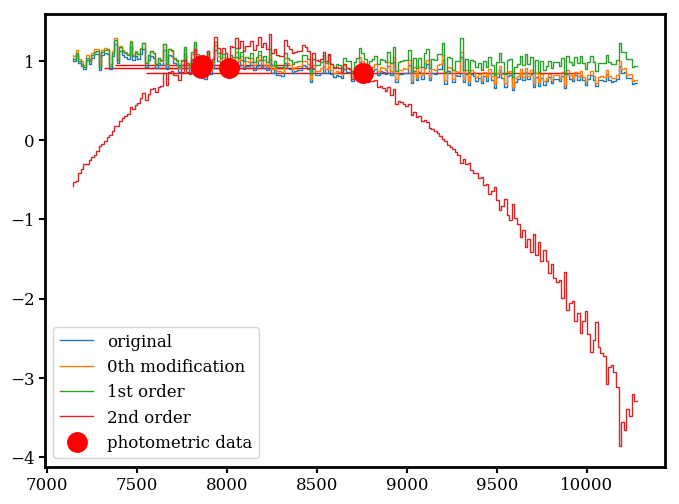

In [16]:
#-------------------------------------------------Initial Reduce the spectra ----------------------------------------------------------
print('-------------------------------------Initial fit ---------------------------------------------------------------------------------------')
[x, y, y_err, wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod] = \
derive_1D_spectra_Av_corrected(OneD_1, redshift_1, row, wave_list, band_list, \
    photometric_flux, photometric_flux_err, photometric_flux_err_mod, A_v)
# print(y)
if redshift< 0.49:
    try:
        chi_square_list.loc[row,'grism_index'] = Lick_index_ratio(x,y)
    except:
        pass
photo_wave_list_for_scaling = []
photo_wave_band_for_scaling = []
photo_list_for_scaling = []
photo_err_list_for_scaling = []
grism_flux_list_for_scaling = []
grism_flux_err_list_for_scaling = []
grism_wave_list_for_scaling =[]
for i in range(len(wave_list)):
    if wave_list[i]-band_list[i] > x[0] and wave_list[i] + band_list[i] < x[-1]:
        scale_index = find_nearest(x, wave_list[i])
        photo_wave_list_for_scaling.append(wave_list[i])
        photo_wave_band_for_scaling.append(band_list[i])
        photo_list_for_scaling.append(photometric_flux[i])
        photo_err_list_for_scaling.append(photometric_flux_err_mod[i])
        grism_flux_list_for_scaling.append(y[scale_index])
        grism_flux_err_list_for_scaling.append(y_err[scale_index])
        grism_wave_list_for_scaling.append(x[scale_index])
    
photo_wave_list_for_scaling = np.array(photo_wave_list_for_scaling)
photo_wave_band_for_scaling = np.array(photo_wave_band_for_scaling)
photo_array_for_scaling = np.array(photo_list_for_scaling)
photo_err_array_for_scaling = np.array(photo_err_list_for_scaling)
grism_flux_array_for_scaling = np.array(grism_flux_list_for_scaling)
grism_flux_err_array_for_scaling = np.array(grism_flux_err_list_for_scaling)
grism_wave_array_for_scaling = np.array(grism_wave_list_for_scaling)


rescaling_err = 1/np.sqrt(1./grism_flux_array_for_scaling*photo_err_array_for_scaling**2
                       + photo_array_for_scaling/grism_flux_array_for_scaling**2*grism_flux_err_array_for_scaling**2)

coeff = np.mean(photo_array_for_scaling/grism_flux_array_for_scaling)
print(coeff)
print('Number of photometric points for rescaling:',len(photo_array_for_scaling))

y = y*coeff

# print(z)
plt.figure(figsize=(8,6),dpi=100)
plt.step(x,y,label='original')
plt.step(x,y*coeff,label='0th modification')
# plt.errorbar(wave_list, photometric_flux, xerr=band_list, yerr=photometric_flux_err_mod, color='r', fmt='o', label='photometric data', markersize=14)
plt.errorbar(photo_wave_list_for_scaling,\
             photo_array_for_scaling,\
             xerr = photo_wave_band_for_scaling,\
             yerr=photo_err_array_for_scaling,\
             color='r', fmt='o', label='photometric data', markersize=14)



fit_coeff= np.polyfit(grism_wave_list_for_scaling,\
                       photo_array_for_scaling/grism_flux_array_for_scaling, 1,\
                       w=photo_err_array_for_scaling)
y_1 = (fit_coeff[0]*x + fit_coeff[1])*y
print(fit_coeff)
# print(y)
plt.step(x,y_1,label='1st order')

fit_coeff= np.polyfit(grism_wave_list_for_scaling,\
                       photo_array_for_scaling/grism_flux_array_for_scaling, 2,\
                       w=photo_err_array_for_scaling)
y_2 = (fit_coeff[0]*x**2 + fit_coeff[1]*x+fit_coeff[2])*y
print(fit_coeff)
# print(y)
plt.step(x,y_2,label='2nd order')

# fit_coeff= np.polyfit(grism_wave_list_for_scaling,\
#                        photo_array_for_scaling/grism_flux_array_for_scaling, 3,\
#                        w=photo_err_array_for_scaling)
# y_2 = (fit_coeff[0]*x**3 + fit_coeff[1]*x**2 + fit_coeff[2]*x + fit_coeff[3])*y
# print(fit_coeff)
# # print(y)
# plt.step(x,y_2,label='3rd order')


plt.legend(loc='best')
photometry_list = np.zeros(len(wave_list))
print('photo flux: ',photometric_flux,len(photometry_list),len(photometric_flux[photometric_flux>0]))

rescaling_err = 1/np.sqrt(1./grism_flux_array_for_scaling*photo_err_array_for_scaling**2
                       + photo_array_for_scaling/grism_flux_array_for_scaling**2*grism_flux_err_array_for_scaling**2)


print(np.polyfit(grism_wave_list_for_scaling,\
                       photo_array_for_scaling/grism_flux_array_for_scaling, 0,full=True,\
                       w=rescaling_err)[1]/(len(photo_array_for_scaling)-1))
print(np.polyfit(grism_wave_list_for_scaling,\
                       photo_array_for_scaling/grism_flux_array_for_scaling, 1,full=True,\
                       w=rescaling_err)[1]/(len(photo_array_for_scaling)-2))
print(np.polyfit(grism_wave_list_for_scaling,\
                       photo_array_for_scaling/grism_flux_array_for_scaling, 2,full=True,\
                       w=rescaling_err)[1]/(len(photo_array_for_scaling)-3))

In [21]:
##
print('____________________M05_________________________ Optimization__________________________')
X = np.array([galaxy_age, intrinsic_Av])
bnds = ((0.01, 13.0), (0.0, 4.0))
sol = optimize.minimize(minimize_age_AV_vector_weighted, X, bounds = bnds, method='SLSQP')#, options = {'disp': True})
print('Optimized weighted reduced chisqure result:', sol)
[age_prior_optimized, AV_prior_optimized] = sol.x
X = sol.x
x2_optimized = minimize_age_AV_vector_weighted(X)
x2_spec, x2_phot = minimize_age_AV_vector_weighted_return_chi2_sep(X)
chi_square_list.loc[row,'M05_age_opt'] = X[0]#"{0:.2f}".format(X[0])
chi_square_list.loc[row,'M05_AV_opt'] = X[1]#"{0:.2f}".format(X[1])
chi_square_list.loc[row,'x2_M05_opt'] = x2_optimized
chi_square_list.loc[row,'x2_spectra_M05_opt'] = x2_spec
chi_square_list.loc[row,'x2_photo_M05_opt'] = x2_phot

____________________M05_________________________ Optimization__________________________
minimize process age av grid [3.16227766 0.1       ]
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float

limit_output extension: Maximum message size of 10000 exceeded with 10709 characters

In [23]:
## 
print('____________________M13_________________________ Optimization__________________________')
bnds = ((0.0, 13.0), (0.0, 4.0))
X = np.array([galaxy_age,intrinsic_Av])
print(X)
sol_M13 = optimize.minimize(minimize_age_AV_vector_weighted_M13, X, bounds = bnds,method='SLSQP',tol=1e-12)
print('Optimized M13 weighted reduced chisqure result:', sol_M13)
[age_prior_optimized_M13, AV_prior_optimized_M13] = sol_M13.x
X = sol_M13.x
x2_optimized = minimize_age_AV_vector_weighted_M13(X)
x2_spec, x2_phot = minimize_age_AV_vector_weighted_M13_return_chi2_sep(X)
chi_square_list.loc[row,'M13_age_opt'] = X[0]#"{0:.2f}".format(X[0])
chi_square_list.loc[row,'M13_AV_opt'] = X[1]#"{0:.2f}".format(X[1])
chi_square_list.loc[row,'x2_M13_opt'] = x2_optimized
chi_square_list.loc[row,'x2_spectra_M13_opt'] = x2_spec
chi_square_list.loc[row,'x2_photo_M13_opt'] = x2_phot
print(X)

____________________M13_________________________ Optimization__________________________
[3.16227766 0.1       ]
minimize process age av grid M13: [3.16227766 0.1       ]
running time for chisquare_photo: 0.017075999999999425
minimize process age av grid M13: [3.16227766 0.1       ]
running time for chisquare_photo: 0.01656000000000013
minimize process age av grid M13: [3.16227768 0.1       ]
running time for chisquare_photo: 0.021945000000000547
minimize process age av grid M13: [3.16227766 0.10000001]
running time for chisquare_photo: 0.020441999999999183
minimize process age av grid M13: [3.13562659 0.97295839]
running time for chisquare_photo: 0.015699000000001462
minimize process age av grid M13: [3.15961255 0.18729584]
running time for chisquare_photo: 0.01547700000000063
minimize process age av grid M13: [3.16168856 0.11929596]
running time for chisquare_photo: 0.016270999999999702
minimize process age av grid M13: [3.16168856 0.11929596]
running time for chisquare_photo: 0.01572

In [24]:
bnds = ((0.0, 13.0), (0.0, 4.0))
X = np.array([galaxy_age,intrinsic_Av])
print(X)
sol_BC03 = optimize.minimize(minimize_age_AV_vector_weighted_BC03, X, bounds = bnds, method='SLSQP')
print()
print('Optimized M13 weighted reduced chisqure result:', sol_M13)



[3.16227766 0.1       ]
running time for chisquare_photo: 0.11832399999999943
running time for chisquare_photo: 0.10246300000000019
running time for chisquare_photo: 0.09231699999999954
running time for chisquare_photo: 0.09338800000000091
running time for chisquare_photo: 0.09901999999999944
running time for chisquare_photo: 0.10098499999999966
running time for chisquare_photo: 0.09396299999999869
running time for chisquare_photo: 0.09642200000000045
running time for chisquare_photo: 0.09494299999999889
running time for chisquare_photo: 0.09531400000000012
running time for chisquare_photo: 0.09837300000000049
running time for chisquare_photo: 0.0887089999999997
running time for chisquare_photo: 0.08893299999999904
running time for chisquare_photo: 0.09570200000000106
running time for chisquare_photo: 0.09717900000000057
running time for chisquare_photo: 0.094576
running time for chisquare_photo: 0.09698000000000029
running time for chisquare_photo: 0.09072699999999934
running time for

running time for chisquare_photo: 0.09266099999999966
running time for chisquare_photo: 0.09097599999999773
running time for chisquare_photo: 0.09207699999999974
running time for chisquare_photo: 0.09396599999999822
running time for chisquare_photo: 0.09293900000000122
running time for chisquare_photo: 0.09229500000000002
running time for chisquare_photo: 0.0965250000000033
running time for chisquare_photo: 0.09208000000000283
running time for chisquare_photo: 0.09370099999999937
running time for chisquare_photo: 0.09770299999999921
running time for chisquare_photo: 0.09188899999999833
running time for chisquare_photo: 0.0947509999999987
running time for chisquare_photo: 0.09576299999999804
running time for chisquare_photo: 0.09103800000000106
running time for chisquare_photo: 0.09296299999999746
running time for chisquare_photo: 0.09470899999999816
running time for chisquare_photo: 0.09093000000000018
running time for chisquare_photo: 0.09094400000000036
running time for chisquare_pho

limit_output extension: Maximum message size of 10000 exceeded with 10039 characters

In [32]:
def chisquare_photo(model_wave, model_flux, redshift_1,wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod):
    """
    work in the observed frame
    """
    tik = time.clock()
    model_wave = model_wave*(1+redshift_1)
    model_flux = model_flux
    photometry_list = np.zeros(len(wave_list))
    for i in range(1,41):

        sum_flambda_AB_K = 0
        sum_transmission = 0
        length = 0
        filter_curve = filter_curve_list[i-1]

        wave_inter = np.zeros(len(model_wave))
        wave_inter[:-1] = np.diff(model_wave)
        index = np.where(model_wave<filter_curve[-1,0])[0]#[0]
        wave = model_wave[index]
        flux = model_flux[index]
        wave_inter = wave_inter[index]
        index = np.where(wave>filter_curve[0,0])
        wave = wave[index]
        flux = flux[index]
        wave_inter = wave_inter[index]
        transmission = np.interp(wave, filter_curve[:,0], filter_curve[:,1])

        n = len(flux)
        if n!= 0 and n!=1:
            for j in range(n):
                # print('closest transmission grid point',ßfind_nearest(filter_curve[:,0],wave[j]))
                try:
                    # transmission_index = find_nearest(filter_curve[:,0],wave[j])                    
                    # if transmission_index ==0:
                    #     transmission = np.interp(wave[j], \
                    #                          filter_curve[0:2,0],\
                    #                          filter_curve[0:2,1])
                    # elif transmission_index == len(filter_curve[:,0]):
                    #     transmission = np.interp(wave[j], \
                    #                          filter_curve[-2:,0],\
                    #                          filter_curve[-2:,1])
                    # else:
                    #     transmission = np.interp(wave[j], \
                    #                          filter_curve[transmission_index-1:transmission_index+1,0],\
                    #                          filter_curve[transmission_index-1:transmission_index+1,1])
                    if all_same(wave_inter):
                        flambda_AB_K = flux[j]*transmission[j]
                        sum_flambda_AB_K += flambda_AB_K
                        sum_transmission += transmission[j]
                        length = length+1
                    else:
                        flambda_AB_K = flux[j]*transmission[j]*wave_inter[j]
                        sum_flambda_AB_K += flambda_AB_K
                        sum_transmission += transmission[j]*wave_inter[j]
                        length = length+1
                except:
                    print('Error',n,transmission_index, j,wave[j],filter_curve[0,0],filter_curve[-1,0])
                    print('closest transmission grid point',find_nearest(filter_curve[:,0],wave[j]),)

                     
        elif n==1:
            # transmission = np.interp(wave, filter_curve[:,0], filter_curve[:,1])
            # transmission_index = find_nearest(filter_curve[:,0],wave[0])
            # print('tranmission index',transmission_index,wave[0],filter_curve[transmission_index,0])
            # if transmission_index ==0:
            #             transmission = np.interp(wave[0], \
            #                                  filter_curve[0:2,0],\
            #                                  filter_curve[0:2,1])
            # elif transmission_index == len(filter_curve[:,0]):
            #     transmission = np.interp(wave[0], \
            #                                  filter_curve[-2:,0],\
            #                                  filter_curve[-2:,1])
            # else:
            #     transmission = np.interp(wave[0], \
            #                          filter_curve[transmission_index-1:transmission_index+1,0],\
            #                          filter_curve[transmission_index-1:transmission_index+1,1])
#             print('single wave',i,transmission)
            flambda_AB_K = flux[0]*transmission[0]
            sum_flambda_AB_K += flambda_AB_K*wave_inter
            sum_transmission += np.sum(transmission)*wave_inter#/len(transmission)#np.trapz(transmission, x=wave)
            length = length+1
        
        if length == 0:
            photometry_list[i-1]=0
        else:
            try:
                photometry_list[i-1] = sum_flambda_AB_K/sum_transmission
            except:
                print('Error',i,type(sum_transmission),n,sum_transmission)
#             if not isinstance(type(sum_flambda_AB_K), np.float64):
#                 print(type(sum_flambda_AB_K))
#             if not isinstance(type(sum_transmission), np.float64):
#                 print(type(sum_transmission))
#             print(type(sum_flambda_AB_K),type(sum_transmission))
    chisquare_photo_list = ((photometric_flux-photometry_list)/photometric_flux_err_mod)**2
    tok = time.clock()
#     print('Generated photometry list:',photometry_list)
#     print('length of the chisquare_photo_list',len(chisquare_photo_list))
#     print('chisquare photo:',np.sum(chisquare_photo_list)/len(chisquare_photo_list))
#     print('running time for chisquare_photo:',tok-tik)
    return np.sum(chisquare_photo_list)/(len(chisquare_photo_list)-2)

In [33]:
with Pool() as pool:
    ndim, nwalkers = 2, 10
    tik = time.clock()
    p0 = [sol_M13.x + 4.*np.random.rand(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lg_minimize_age_AV_vector_weighted_M13, pool=pool)
    sampler.run_mcmc(p0,nsteps,progress=True)
    samples = sampler.chain[:, 500:, :].reshape((-1,ndim))
    samples = samples[(samples[:,0] > age_prior_optimized_M13*0.1) & (samples[:,0] < age_prior_optimized_M13*2.0) & (samples[:,1] < AV_prior_optimized_M13*3.0)]
    tok = time.clock()
    multi_time = tok-tik
    print("Multiprocessing took {0:.1f} seconds".format(multi_time)) 
    print('Time to run M13 MCMC:'+str(tok-tik))

  4%|▍         | 128/3000 [00:08<03:14, 14.76it/s]

emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:


Process ForkPoolWorker-38:


emcee: Exception while calling your likelihood function:


Process ForkPoolWorker-35:


emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:


Process ForkPoolWorker-40:


  params: [2.99838455 0.43214953]
  params: [0.18020861 1.31523383]


KeyboardInterrupt: 

In [127]:
X = sol_M13.x
print(X)
n = len(x)
# fig1 = plt.figure(figsize=(20,10))
# frame1 = fig1.add_axes((.1,.35,.8,.6))

# plt.step(x, y, color='r',lw=3)
# plt.fill_between(x,(y+y_err),(y-y_err),alpha=0.1)
# plt.errorbar(wave_list, photometric_flux, xerr=band_list, yerr=photometric_flux_err_mod, color='r', fmt='o', label='photometric data', markersize='14')

# CSP
model_wave, model_flux = minimize_age_AV_vector_weighted_M13_return_flux(X)[1:3]
# model_flux =minimize_age_AV_vector_weighted_return_flux(X)[2]

[1.63133135 0.66303758]
running time for chisquare_photo: 0.01870400000001382


In [128]:
def chisquare_photo(model_wave, model_flux, redshift_1,wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod):
    """
    work in the observed frame
    """
    tik = time.clock()
    model_wave = model_wave*(1+redshift_1)
    model_flux = model_flux

    photometry_list = np.zeros(len(wave_list))

    for i in range(1,41):

        sum_flambda_AB_K = 0
        sum_transmission = 0
        length = 0
        filter_curve = filter_curve_list[i-1]

        wave_inter = np.zeros(len(model_wave))
        wave_inter[:-1] = np.diff(model_wave)
        index = np.where(model_wave<filter_curve[-1,0])[0]#[0]
        wave = model_wave[index]
        flux = model_flux[index]
        wave_inter = wave_inter[index]
        index = np.where(wave>filter_curve[0,0])
        wave = wave[index]
        flux = flux[index]
        wave_inter = wave_inter[index]
        n = len(flux)
        if n!= 0 and n!=1:
            for j in range(n):
                # print('closest transmission grid point',ßfind_nearest(filter_curve[:,0],wave[j]))
                try:
                    transmission_index = find_nearest(filter_curve[:,0],wave[j])                    
                    if transmission_index ==0:
                        transmission = np.interp(wave[j], \
                                             filter_curve[0:2,0],\
                                             filter_curve[0:2,1])
                    elif transmission_index == len(filter_curve[:,0]):
                        transmission = np.interp(wave[j], \
                                             filter_curve[-2:,0],\
                                             filter_curve[-2:,1])
                    else:
                        transmission = np.interp(wave[j], \
                                             filter_curve[transmission_index-1:transmission_index+1,0],\
                                             filter_curve[transmission_index-1:transmission_index+1,1])
                    if all_same(wave_inter):
                        flambda_AB_K = flux[j]*transmission
                        sum_flambda_AB_K += flambda_AB_K
                        sum_transmission += transmission
                        length = length+1
                    else:
                        flambda_AB_K = flux[j]*transmission*wave_inter[j]
                        sum_flambda_AB_K += flambda_AB_K
                        sum_transmission += transmission*wave_inter[j]
                        length = length+1
                except:
                    print('Error',n,transmission_index, j,wave[j],filter_curve[0,0],filter_curve[-1,0])
                    print('closest transmission grid point',find_nearest(filter_curve[:,0],wave[j]),)

                     
        elif n==1:
            transmission_index = find_nearest(filter_curve[:,0],wave[0])
            transmission = np.interp(wave[0], \
                                     filter_curve[transmission_index-1:transmission_index+1,0],\
                                     filter_curve[transmission_index-1:transmission_index+1,1])
            # transmission = np.interp(wave, filter_curve[j:j+2,0], filter_curve[j:j+2,1])
            flambda_AB_K = flux[0]*transmission[0]
            sum_flambda_AB_K += flambda_AB_K*wave_inter
            sum_transmission += np.sum(transmission)*wave_inter#/len(transmission)#np.trapz(transmission, x=wave)
            length = length+1
        
        if length == 0:
            photometry_list[i-1]=0
        else:
            photometry_list[i-1] = sum_flambda_AB_K/sum_transmission
    chisquare_photo_list = ((photometric_flux-photometry_list)/photometric_flux_err_mod)**2
    tok = time.clock()
    print('Generated photometry list:',photometry_list)
    print('length of the chisquare_photo_list',len(chisquare_photo_list))
    print('chisquare photo:',np.sum(chisquare_photo_list)/len(chisquare_photo_list))
    print('running time for chisquare_photo:',tok-tik)
    return np.sum(chisquare_photo_list)/len(chisquare_photo_list)
def chisquare_photo_new(model_wave, model_flux, redshift_1,wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod):
    """
    work in the observed frame
    """
    tik = time.clock()
    model_wave = model_wave*(1+redshift_1)
    model_flux = model_flux
    photometry_list = np.zeros(len(wave_list))
    for i in range(1,41):

        sum_flambda_AB_K = 0
        sum_transmission = 0
        length = 0
        filter_curve = filter_curve_list[i-1]

        wave_inter = np.zeros(len(model_wave))
        wave_inter[:-1] = np.diff(model_wave)
        index = np.where(model_wave<filter_curve[-1,0])[0]#[0]
        wave = model_wave[index]
        flux = model_flux[index]
        wave_inter = wave_inter[index]
        index = np.where(wave>filter_curve[0,0])
        wave = wave[index]
        flux = flux[index]
        wave_inter = wave_inter[index]
        transmission = np.interp(wave, filter_curve[:,0], filter_curve[:,1])

        n = len(flux)
        if n!= 0 and n!=1:
            for j in range(n):
                # print('closest transmission grid point',ßfind_nearest(filter_curve[:,0],wave[j]))
                try:
                    # transmission_index = find_nearest(filter_curve[:,0],wave[j])                    
                    # if transmission_index ==0:
                    #     transmission = np.interp(wave[j], \
                    #                          filter_curve[0:2,0],\
                    #                          filter_curve[0:2,1])
                    # elif transmission_index == len(filter_curve[:,0]):
                    #     transmission = np.interp(wave[j], \
                    #                          filter_curve[-2:,0],\
                    #                          filter_curve[-2:,1])
                    # else:
                    #     transmission = np.interp(wave[j], \
                    #                          filter_curve[transmission_index-1:transmission_index+1,0],\
                    #                          filter_curve[transmission_index-1:transmission_index+1,1])
                    if all_same(wave_inter):
                        flambda_AB_K = flux[j]*transmission[j]
                        sum_flambda_AB_K += flambda_AB_K
                        sum_transmission += transmission
                        length = length+1
                    else:
                        flambda_AB_K = flux[j]*transmission[j]*wave_inter[j]
                        sum_flambda_AB_K += flambda_AB_K
                        sum_transmission += transmission[j]*wave_inter[j]
                        length = length+1
                except:
                    print('Error',n,transmission_index, j,wave[j],filter_curve[0,0],filter_curve[-1,0])
                    print('closest transmission grid point',find_nearest(filter_curve[:,0],wave[j]),)

                     
        elif n==1:
            # transmission = np.interp(wave, filter_curve[:,0], filter_curve[:,1])
            # transmission_index = find_nearest(filter_curve[:,0],wave[0])
            # print('tranmission index',transmission_index,wave[0],filter_curve[transmission_index,0])
            # if transmission_index ==0:
            #             transmission = np.interp(wave[0], \
            #                                  filter_curve[0:2,0],\
            #                                  filter_curve[0:2,1])
            # elif transmission_index == len(filter_curve[:,0]):
            #     transmission = np.interp(wave[0], \
            #                                  filter_curve[-2:,0],\
            #                                  filter_curve[-2:,1])
            # else:
            #     transmission = np.interp(wave[0], \
            #                          filter_curve[transmission_index-1:transmission_index+1,0],\
            #                          filter_curve[transmission_index-1:transmission_index+1,1])
            print('single wave',i,transmission)
            flambda_AB_K = flux[0]*transmission[0]
            sum_flambda_AB_K += flambda_AB_K*wave_inter
            sum_transmission += np.sum(transmission)*wave_inter#/len(transmission)#np.trapz(transmission, x=wave)
            length = length+1
        
        if length == 0:
            photometry_list[i-1]=0
        else:
            photometry_list[i-1] = sum_flambda_AB_K/sum_transmission
    chisquare_photo_list = ((photometric_flux-photometry_list)/photometric_flux_err_mod)**2
    tok = time.clock()
    print('Generated photometry list:',photometry_list)
    print('length of the chisquare_photo_list',len(chisquare_photo_list))
    print('chisquare photo:',np.sum(chisquare_photo_list)/len(chisquare_photo_list))
    print('running time for chisquare_photo:',tok-tik)
    return np.sum(chisquare_photo_list)/len(chisquare_photo_list)

In [74]:
chi2_photo=chisquare_photo(model_wave, model_flux, redshift_1, wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod)
chi2_photo_new = chisquare_photo_new(model_wave, model_flux, redshift_1, wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod)
print(chi2_photo,chi2_photo_new)

Generated photometry list: [0.19733851 0.50678087 0.92482098 1.04417649 1.00435714 0.84517888
 1.02949935 0.81420146 0.71781512 0.63215677 0.93804894 0.85665852
 0.80222093 0.62134165 0.54530841 0.37515526 0.82384249 0.58496709
 0.38146803 0.94022638 0.81949772 0.57743224 0.38311433 0.33114652
 0.77567062 0.93611521 1.04191361 0.99572353 0.27557279 0.36346041
 0.47213517 0.62185504 0.64748028 0.89994022 0.88166014 1.01229653
 1.05603686 1.06028151 1.03381653 1.0336277 ]
length of the chisquare_photo_list 40
chisquare photo: 1.4194578737671641
running time for chisquare_photo: 0.06868500000001632
Generated photometry list: [0.19718833 0.50635819 0.92472394 1.04419746 1.0043839  0.84516712
 1.02954848 0.81436086 0.71784196 0.63228702 0.93808391 0.85677073
 0.80237288 0.62141811 0.54535328 0.37512291 0.8241477  0.58502354
 0.38150846 0.94028767 0.81956121 0.57752457 0.38342315 0.33078771
 0.77524461 0.93594709 1.0419605  0.99581005 0.27556905 0.36345547
 0.47208961 0.62183803 0.64746928 0

In [101]:
def reduced_chi_square_new(data_wave,data,data_err,model_wave,model):
    n=len(data_wave)
    chi_square = 0
    for i in range(n):
        model_flux_interp = np.interp(data_wave[i], model_wave, model)
        chi_square += (data[i]-model_flux_interp)**2/(data_err[i]**2)
    print('spectra chisquare processes new',i,chi_square, data_wave[i],model_flux_interp)
    dof = n#-2
    reduced_chi_square = chi_square/dof
    return reduced_chi_square
def reduced_chi_square(data_wave, data, data_err, model_wave, model):
    n = len(data_wave)
    chi_square = 0
    for i in range(n):
        index = find_nearest(model_wave, data_wave[i])#print index
        chi_square += (data[i]-model[index])**2/(data_err[i]**2)
        if np.isnan(chi_square):
            print('spectra chisquare nan',index, model_wave[index],wave[i],model[index])
    print('spectra chisquare processes',i,chi_square,model[index])
    reduced_chi_square = chi_square/n
    return reduced_chi_square

In [103]:
tik = time.time()
chi2_spec = reduced_chi_square(x,y,y_err,model_wave,model_flux)
tok = time.time()
print('old time',tok-tik)
tik = time.time()
chi2_spec_new = reduced_chi_square_new(x,y,y_err,model_wave,model_flux)
tok = time.time()
print('new time',tok-tik)
print(chi2_spec,chi2_spec_new)

spectra chisquare processes 209 863.5621768496379 0.5894850093673744
old time 0.004851341247558594
spectra chisquare processes new 209 799.2150774040032 13433.251392985905 0.588912390711044
new time 0.0039598941802978516
4.112200842141133 3.805786082876206


## 1 Fit with M05 model

### 1.0 Find the optimization result

In [70]:
print('____________________M05_________________________ Optimization__________________________')
X = np.array([galaxy_age, intrinsic_Av])
bnds = ((0.01, 13.0), (0.0, 4.0))
sol = optimize.minimize(minimize_age_AV_vector_weighted, X, bounds = bnds, method='TNC')#, options = {'disp': True})
# print('Optimized weighted reduced chisqure result:', sol)
[age_prior_optimized, AV_prior_optimized] = sol.x
X = sol.x
x2_optimized = minimize_age_AV_vector_weighted(X)
x2_spec, x2_phot = minimize_age_AV_vector_weighted_return_chi2_sep(X)
chi_square_list.loc[row,'M05_age_opt'] = X[0]#"{0:.2f}".format(X[0])
chi_square_list.loc[row,'M05_AV_opt'] = X[1]#"{0:.2f}".format(X[1])
chi_square_list.loc[row,'x2_M05_opt'] = x2_optimized
chi_square_list.loc[row,'x2_spectra_M05_opt'] = x2_spec
chi_square_list.loc[row,'x2_photo_M05_opt'] = x2_phot

____________________M05_________________________ Optimization__________________________


#### 1.0.1 Plot the SED

[1.84082359 0.21079279]


Text(0.5, 0, 'Wavelength($\\rm \\AA$)')

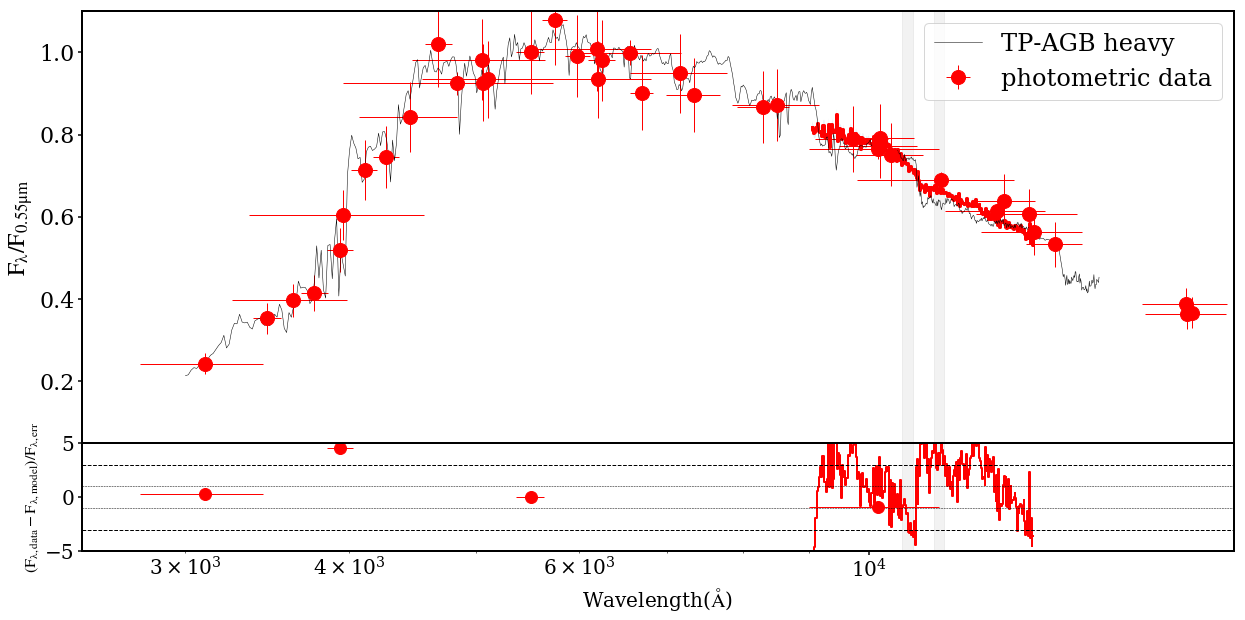

In [71]:
#--- Plot
X = sol.x
print(X)
n = len(x)
fig1 = plt.figure(figsize=(20,10))
frame1 = fig1.add_axes((.1,.35,.8,.6))

plt.step(x, y, color='r',lw=3)
plt.fill_between(x,(y+y_err),(y-y_err),alpha=0.1)
plt.errorbar(wave_list, photometric_flux, xerr=band_list, yerr=photometric_flux_err_mod, color='r', fmt='o', label='photometric data', markersize='14')

# CSP
model_wave =minimize_age_AV_vector_weighted_return_flux(X)[1]
model_flux =minimize_age_AV_vector_weighted_return_flux(X)[2]

model1_wave =minimize_age_AV_vector_weighted_return_flux(X)[1]
model1_flux =minimize_age_AV_vector_weighted_return_flux(X)[2]

plt.plot(model_wave, model_flux, color='k',label='TP-AGB heavy',lw=0.5)

plt.xlim([2.5e3,1.9e4])
plt.ylim([0.05, 1.1])
plt.semilogx()

plt.ylabel(r'$\rm F_{\lambda}/F_{0.55\mu m}$',fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc='upper right',fontsize=24)
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)

frame2 = fig1.add_axes((.1,.2,.8,.15))  
relative_spectra = np.zeros([1,n])
relative_spectra_err = np.zeros([1,n])
relative_sigma = np.zeros([1,n])
index0 = 0
for wave in x:
    if y[index0]>0.25 and y[index0]<1.35:
        index = find_nearest(model_wave, wave);#print index
        relative_spectra[0, index0] = y[index0]/model_flux[index]
        relative_spectra_err[0, index0] = y_err[index0]/model_flux[index]
        relative_sigma[0, index0] = (y[index0]-model_flux[index])/y_err[index0]
        index0 = index0+1
# plt.step(x[:index0], relative_spectra[0,:index0], color='r', linewidth=2)
# plt.fill_between(x[:index0],(relative_spectra[0,:index0]+relative_spectra_err[0,:index0]),\
#     (relative_spectra[0,:index0]-relative_spectra_err[0,:index0]),alpha=0.1)
plt.step(x[:index0], relative_sigma[0,:index0], color='r', linewidth=2)
# print(relative_sigma[0,:index0])
index0 = 0
# relative_photo = np.zeros([1,(len(wave_list))])
for i in range(len(wave_list)):
    try:
        index = find_nearest(model_wave, wave_list[i])
        # relative_photo[0, index0] = model_flux[index]/(photometric_flux[i])
    except:
        pass
    plt.errorbar(wave_list[i], (photometric_flux[i]-model_flux[index])/photometric_flux_err[i], xerr=band_list[i], fmt='o', color='r', markersize=12)
    # plt.errorbar(wave_list[i], (photometric_flux[i])/model_flux[index], xerr=band_list[i], yerr=photometric_flux_err[i]/model_flux[index], fmt='o', color='r', markersize=16)
    index0 = index0+1
plt.xlim([2.5e3,1.9e4])
plt.semilogx()
# plt.axhline(1.0, linestyle='--', linewidth=2, color='k')
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)
# plt.ylim([0.9,1.1])
# plt.ylim([0.7,1.45])
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.axhline(3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(-3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(1.0, linestyle='--', linewidth=0.5, color='k')
plt.axhline(-1.0, linestyle='--', linewidth=0.5, color='k')
plt.ylim([-5,5])
plt.ylabel(r'$\rm (F_{\lambda,\rm data}-F_{\lambda,\rm model})/F_{\lambda,\rm err}$',fontsize=16)
plt.xlabel(r'Wavelength($\rm \AA$)', fontsize=20)

### 1.1 Run with the MCMC

In [10]:
with Pool() as pool:
    ndim, nwalkers = 2, 10
    tik = time.clock()
    X = sol.x
    p0 = [sol.x + 4.*np.random.rand(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lg_minimize_age_AV_vector_weighted, pool=pool)
    sampler.run_mcmc(p0, nsteps, progress=True)
    samples = sampler.chain[:, 500:, :].reshape((-1,ndim))
    samples = samples[(samples[:,0] > age_prior_optimized*0.1) &
                      (samples[:,0] < age_prior_optimized*2.0) & 
                      (samples[:,1] < AV_prior_optimized*3.0)]            
    tok = time.clock()
    multi_time = tok-tik
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    print('Time to run M05 MCMC:'+str(tok-tik)) 

3.0.2


/Users/siqiliu/anaconda3/envs/py37/lib/python3.6/site-packages/ipykernel_launcher.py:485: RuntimeWarning: divide by zero encountered in log
/Users/siqiliu/anaconda3/envs/py37/lib/python3.6/site-packages/ipykernel_launcher.py:485: RuntimeWarning: divide by zero encountered in log
/Users/siqiliu/anaconda3/envs/py37/lib/python3.6/site-packages/ipykernel_launcher.py:485: RuntimeWarning: divide by zero encountered in log
/Users/siqiliu/anaconda3/envs/py37/lib/python3.6/site-packages/ipykernel_launcher.py:485: RuntimeWarning: divide by zero encountered in log
  0%|          | 0/1200 [00:00<?, ?it/s]/Users/siqiliu/anaconda3/envs/py37/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 2/1200 [00:00<07:04,  2.82it/s]/Users/siqiliu/anaconda3/envs/py37/lib/python3.6/site-packages/ipykernel_launcher.py:485: RuntimeWarning: divide by zero encountered in log
/Users/siqiliu/anacon

Multiprocessing took 8.6 seconds
Time to run M05 MCMC:8.575668


#### 1.1.1 Make corner plot of the MCMC result

MCMC results maximum Likelihood Point M05: [3.44013388 0.18328928] [1.50545482 0.09934387]


<Figure size 3200x3200 with 0 Axes>

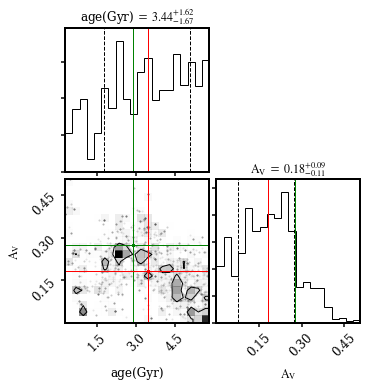

In [12]:
if samples.size > 1e3:
    value2 = np.percentile(samples, 50, axis=0)
    [std_age_prior_optimized, std_AV_prior_optimized] = np.std(samples, axis=0)
    plt.figure(figsize=(32,32),dpi=100)
    fig = corner.corner(samples,
         labels=["age(Gyr)", r"$\rm A_V$"],
         truths=[age_prior_optimized, AV_prior_optimized],
         levels = (1-np.exp(-0.5),),
         show_titles=True,
         title_kwargs={'fontsize':12},
         quantiles=(0.16,0.5, 0.84))
    axes = np.array(fig.axes).reshape((ndim, ndim))

    for i in range(ndim):
        ax = axes[i, i]
        ax.axvline(X[i], color="g")
        ax.axvline(value2[i],color='r')
    # Loop over the histograms
    for yi in range(ndim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.axvline(X[xi], color="g")
            ax.axvline(value2[xi], color="r")
            ax.axhline(X[yi], color="g")
            ax.axhline(value2[yi], color="r")
            ax.plot(X[xi], X[yi], "sg")
            ax.plot(value2[xi],value2[yi],'sr')
    plt.rcParams.update({'font.size': 12})
    print('MCMC results maximum Likelihood Point M05:', np.percentile(samples, 50, axis=0), np.std(samples, axis=0))

#### 1.1.2 Plot the SED with the MCMC 50 percentile result

In [23]:
#--- Plot
X = np.percentile(samples, 50, axis=0)
x2_optimized = minimize_age_AV_vector_weighted(X)
x2_spec, x2_phot = minimize_age_AV_vector_weighted_return_chi2_sep(X)
chi_square_list.loc[row,'M05_age_MCMC50'] = X[0]#"{0:.2f}".format(X[0])
chi_square_list.loc[row,'M05_AV_MCMC50'] = X[1]#"{0:.2f}".format(X[1])
chi_square_list.loc[row,'x2_M05_MCMC50'] = x2_optimized
chi_square_list.loc[row,'x2_spectra_M05_MCMC50'] = x2_spec
chi_square_list.loc[row,'x2_photo_M05_MCMC50'] = x2_phot
chi_square_list.loc[row,'M05_age_std'] = np.std(samples, axis=0)[0]#"{0:.2f}".format(np.std(samples, axis=0)[0])
chi_square_list.loc[row,'M05_AV_std'] = np.std(samples, axis=0)[1]#"{0:.2f}".format(np.std(samples, axis=0)[1])

n = len(x)
fig1 = plt.figure(figsize=(20,10))
frame1 = fig1.add_axes((.1,.35,.8,.6))
plt.step(x, y, color='r',lw=3)
plt.fill_between(x,(y+y_err),(y-y_err),alpha=0.1)
plt.errorbar(wave_list, photometric_flux, xerr=band_list, yerr=photometric_flux_err, color='r', fmt='o', label='photometric data', markersize='14')

model_wave =minimize_age_AV_vector_weighted_return_flux(X)[1]
model_flux =minimize_age_AV_vector_weighted_return_flux(X)[2]

plt.plot(model_wave, model_flux, color='k',label='TP-AGB heavy',lw=0.5)

plt.xlim([2.5e3,1.9e4])
plt.ylim([0.05, 1.1])#plt.ylim([ymin,ymax])
plt.semilogx()
plt.ylabel(r'$\rm F_{\lambda}/F_{0.55\mu m}$',fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc='upper right',fontsize=24)
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)

frame2 = fig1.add_axes((.1,.2,.8,.15))  
relative_spectra = np.zeros([1,n])
relative_spectra_err = np.zeros([1,n])
relative_sigma = np.zeros([1,n])
index0 = 0
for wave in x:
    if y[index0]>0.25 and y[index0]<1.35:
        index = find_nearest(model_wave, wave);#print index
        relative_spectra[0, index0] = y[index0]/model_flux[index]
        relative_spectra_err[0, index0] = y_err[index0]/model_flux[index]
        relative_sigma[0, index0] = (y[index0]-model_flux[index])/y_err[index0]
        index0 = index0+1
# plt.step(x[:index0], relative_spectra[0,:index0], color='r', linewidth=2)
# plt.fill_between(x[:index0],(relative_spectra[0,:index0]+relative_spectra_err[0,:index0]),\
#     (relative_spectra[0,:index0]-relative_spectra_err[0,:index0]),alpha=0.1)
plt.step(x[:index0], relative_sigma[0,:index0], color='r', linewidth=2)
# print(relative_sigma[0,:index0])
index0 = 0
# relative_photo = np.zeros([1,(len(wave_list))])
for i in range(len(wave_list)):
    try:
        index = find_nearest(model_wave, wave_list[i])
        # relative_photo[0, index0] = model_flux[index]/(photometric_flux[i])
    except:
        pass
    plt.errorbar(wave_list[i], (photometric_flux[i]-model_flux[index])/photometric_flux_err[i], xerr=band_list[i], fmt='o', color='r', markersize=12)
    # plt.errorbar(wave_list[i], (photometric_flux[i])/model_flux[index], xerr=band_list[i], yerr=photometric_flux_err[i]/model_flux[index], fmt='o', color='r', markersize=16)
    index0 = index0+1
plt.xlim([2.5e3,1.9e4])
plt.semilogx()
# plt.axhline(1.0, linestyle='--', linewidth=2, color='k')
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
# plt.ylim([0.9,1.1])
# plt.ylim([0.7,1.45])
plt.axhline(3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(-3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(1.0, linestyle='--', linewidth=0.5, color='k')
plt.axhline(-1.0, linestyle='--', linewidth=0.5, color='k')
plt.ylim([-5,5])
plt.ylabel(r'$\rm (F_{\lambda,\rm data}-F_{\lambda,\rm model})/F_{\lambda,\rm err}$',fontsize=16)
plt.xlabel(r'Wavelength($\rm \AA$)', fontsize=20)

NameError: name 'samples' is not defined

#### 1.1.3 If sampling points not enough, try with a longer nsteps (skipped if with enough samples) and plot SED

In [ ]:
with Pool() as pool:
    ndim, nwalkers = 2, 10
    tik = time.clock()
    X = sol.x
    p0 = [sol.x + 4.*np.random.rand(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lg_minimize_age_AV_vector_weighted, pool=pool)
    sampler.run_mcmc(p0, nsteps*2, progress=True)
    samples = sampler.chain[:, 500:, :].reshape((-1,ndim))
    samples = samples[(samples[:,0] > age_prior_optimized*0.1) &
                      (samples[:,0] < age_prior_optimized*2.0) & 
                      (samples[:,1] < AV_prior_optimized*3.0)]            
    tok = time.clock()
    multi_time = tok-tik
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    print('Time to run M05 MCMC:'+str(tok-tik))
if samples.size > 1e3:
    value2 = np.percentile(samples, 50, axis=0)
    [std_age_prior_optimized, std_AV_prior_optimized] = np.std(samples, axis=0)
    plt.figure(figsize=(32,32),dpi=100)
    fig = corner.corner(samples,
         labels=["age(Gyr)", r"$\rm A_V$"],
         truths=[age_prior_optimized, AV_prior_optimized],
         levels = (1-np.exp(-0.5),),
         show_titles=True,
         title_kwargs={'fontsize':12},
         quantiles=(0.16,0.5, 0.84))
    axes = np.array(fig.axes).reshape((ndim, ndim))

    for i in range(ndim):
        ax = axes[i, i]
        ax.axvline(X[i], color="g")
        ax.axvline(value2[i],color='r')
    # Loop over the histograms
    for yi in range(ndim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.axvline(X[xi], color="g")
            ax.axvline(value2[xi], color="r")
            ax.axhline(X[yi], color="g")
            ax.axhline(value2[yi], color="r")
            ax.plot(X[xi], X[yi], "sg")
            ax.plot(value2[xi],value2[yi],'sr')
    plt.rcParams.update({'font.size': 12})
    X = np.percentile(samples, 50, axis=0)
    x2_optimized = minimize_age_AV_vector_weighted(X)
    x2_spec, x2_phot = minimize_age_AV_vector_weighted_return_chi2_sep(X)
    chi_square_list.loc[row,'M05_age_MCMC50'] = X[0]#"{0:.2f}".format(X[0])
    chi_square_list.loc[row,'M05_AV_MCMC50'] = X[1]#"{0:.2f}".format(X[1])
    chi_square_list.loc[row,'x2_M05_MCMC50'] = x2_optimized
    chi_square_list.loc[row,'x2_spectra_M05_MCMC50'] = x2_spec
    chi_square_list.loc[row,'x2_photo_M05_MCMC50'] = x2_phot
    chi_square_list.loc[row,'M05_age_std'] = np.std(samples, axis=0)[0]#"{0:.2f}".format(np.std(samples, axis=0)[0])
    chi_square_list.loc[row,'M05_AV_std'] = np.std(samples, axis=0)[1]#"{0:.2f}".format(np.std(samples, axis=0)[1])

    n = len(x)
    fig1 = plt.figure(figsize=(20,10))
    frame1 = fig1.add_axes((.1,.35,.8,.6))
    plt.step(x, y, color='r',lw=3)
    plt.fill_between(x,(y+y_err),(y-y_err),alpha=0.1)
    plt.errorbar(wave_list, photometric_flux, xerr=band_list, yerr=photometric_flux_err, color='r', fmt='o', label='photometric data', markersize='14')

    model_wave =minimize_age_AV_vector_weighted_return_flux(X)[1]
    model_flux =minimize_age_AV_vector_weighted_return_flux(X)[2]

    plt.plot(model_wave, model_flux, color='k',label='TP-AGB heavy',lw=0.5)

    plt.xlim([2.5e3,1.9e4])
    plt.ylim([0.05, 1.1])#plt.ylim([ymin,ymax])
    plt.semilogx()
    plt.ylabel(r'$\rm F_{\lambda}/F_{0.55\mu m}$',fontsize=24)
    plt.tick_params(axis='both', which='major', labelsize=22)
    plt.legend(loc='upper right',fontsize=24)
    plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
    plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)

    frame2 = fig1.add_axes((.1,.2,.8,.15))  
    relative_spectra = np.zeros([1,n])
    relative_spectra_err = np.zeros([1,n])
    relative_sigma = np.zeros([1,n])
    index0 = 0
    for wave in x:
        if y[index0]>0.25 and y[index0]<1.35:
            index = find_nearest(model_wave, wave);#print index
            relative_spectra[0, index0] = y[index0]/model_flux[index]
            relative_spectra_err[0, index0] = y_err[index0]/model_flux[index]
            relative_sigma[0, index0] = (y[index0]-model_flux[index])/y_err[index0]
            index0 = index0+1
    # plt.step(x[:index0], relative_spectra[0,:index0], color='r', linewidth=2)
    # plt.fill_between(x[:index0],(relative_spectra[0,:index0]+relative_spectra_err[0,:index0]),\
    #     (relative_spectra[0,:index0]-relative_spectra_err[0,:index0]),alpha=0.1)
    plt.step(x[:index0],relative_sigma[0,:index0], color='r', linewidth=2)
    # print(relative_sigma[0,:index0])
    index0 = 0
    # relative_photo = np.zeros([1,(len(wave_list))])
    for i in range(len(wave_list)):
        try:
            index = find_nearest(model_wave, wave_list[i])
            # relative_photo[0, index0] = model_flux[index]/(photometric_flux[i])
        except:
            pass
        plt.errorbar(wave_list[i], (photometric_flux[i]-model_flux[index])/photometric_flux_err[i], xerr=band_list[i], fmt='o', color='r', markersize=12)
        # plt.errorbar(wave_list[i], (photometric_flux[i])/model_flux[index], xerr=band_list[i], yerr=photometric_flux_err[i]/model_flux[index], fmt='o', color='r', markersize=16)
        index0 = index0+1
    plt.xlim([2.5e3,1.9e4])
    plt.semilogx()
    # plt.axhline(1.0, linestyle='--', linewidth=2, color='k')
    plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
    plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.tick_params(axis='both', which='minor', labelsize=20)
    # plt.ylim([0.9,1.1])
    # plt.ylim([0.7,1.45])
    plt.axhline(3.0, linestyle='--', linewidth=1, color='k')
    plt.axhline(-3.0, linestyle='--', linewidth=1, color='k')
    plt.axhline(1.0, linestyle='--', linewidth=0.5, color='k')
    plt.axhline(-1.0, linestyle='--', linewidth=0.5, color='k')
    plt.ylim([-5,5])
    plt.ylabel(r'$\rm (F_{\lambda,\rm data}-F_{\lambda,\rm model})/F_{\lambda,\rm err}$',fontsize=16)
    plt.xlabel(r'Wavelength($\rm \AA$)', fontsize=20)

## 2 Test with M13 model

### 2.0 Find the optimized result

#### 2.0.1 Plot the SED

Text(0.5, 0, 'Wavelength($\\rm \\AA$)')

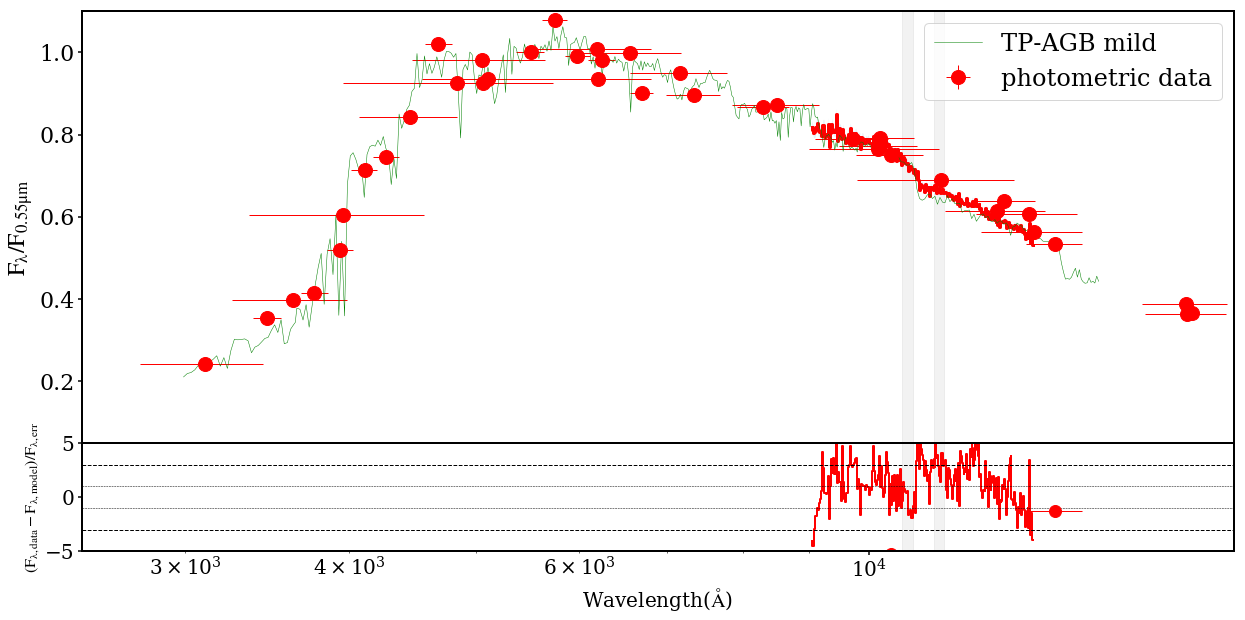

In [92]:
#--- Plot
X = sol_M13.x
n = len(x)
fig1 = plt.figure(figsize=(20,10))
frame1 = fig1.add_axes((.1,.35,.8,.6))
plt.step(x, y, color='r',lw=3)
plt.fill_between(x,(y+y_err),(y-y_err),alpha=0.1)
plt.errorbar(wave_list, photometric_flux, xerr=band_list, yerr=photometric_flux_err, color='r', fmt='o', label='photometric data', markersize='14')

model_wave =minimize_age_AV_vector_weighted_M13_return_flux(X)[1]
model_flux =minimize_age_AV_vector_weighted_M13_return_flux(X)[2]

model2_wave =minimize_age_AV_vector_weighted_M13_return_flux(X)[1]
model2_flux =minimize_age_AV_vector_weighted_M13_return_flux(X)[2]

plt.plot(model_wave, model_flux, color='g',label='TP-AGB mild',lw=0.5)

plt.xlim([2.5e3,1.9e4])
plt.ylim([0.05, 1.1])#plt.ylim([ymin,ymax])
plt.semilogx()

plt.ylabel(r'$\rm F_{\lambda}/F_{0.55\mu m}$',fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc='upper right',fontsize=24)
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)

frame2 = fig1.add_axes((.1,.2,.8,.15))  
relative_spectra = np.zeros([1,n])
relative_spectra_err = np.zeros([1,n])
relative_sigma = np.zeros([1,n])
index0 = 0
for wave in x:
    if y[index0]>0.25 and y[index0]<1.35:
        index = find_nearest(model_wave, wave);#print index
        relative_spectra[0, index0] = y[index0]/model_flux[index]
        relative_spectra_err[0, index0] = y_err[index0]/model_flux[index]
        relative_sigma[0, index0] = (y[index0]-model_flux[index])/y_err[index0]
        index0 = index0+1
# plt.step(x[:index0], relative_spectra[0,:index0], color='r', linewidth=2)
# plt.fill_between(x[:index0],(relative_spectra[0,:index0]+relative_spectra_err[0,:index0]),\
#     (relative_spectra[0,:index0]-relative_spectra_err[0,:index0]),alpha=0.1)
plt.step(x[:index0], relative_sigma[0,:index0], color='r', linewidth=2)

index0 = 0
# relative_photo = np.zeros([1,(len(wave_list))])
for i in range(len(wave_list)):
    try:
        index = find_nearest(model_wave, wave_list[i])
        # relative_photo[0, index0] = model_flux[index]/(photometric_flux[i])
    except:
        pass
    plt.errorbar(wave_list[i], (photometric_flux[i]-model_flux[index])/photometric_flux_err[i], xerr=band_list[i], fmt='o', color='r', markersize=12)
    # plt.errorbar(wave_list[i], (photometric_flux[i])/model_flux[index], xerr=band_list[i], yerr=photometric_flux_err[i]/model_flux[index], fmt='o', color='r', markersize=16)
    index0 = index0+1
plt.xlim([2.5e3,1.9e4])
plt.semilogx()
# plt.axhline(1.0, linestyle='--', linewidth=2, color='k')
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
# plt.ylim([0.75,1.5])
# plt.ylim([0.9,1.1])
# plt.ylim([0.7,1.45])
plt.axhline(3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(-3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(1.0, linestyle='--', linewidth=0.5, color='k')
plt.axhline(-1.0, linestyle='--', linewidth=0.5, color='k')
plt.ylim([-5,5])
plt.ylabel(r'$\rm (F_{\lambda,\rm data}-F_{\lambda,\rm model})/F_{\lambda,\rm err}$',fontsize=16)
plt.xlabel(r'Wavelength($\rm \AA$)', fontsize=20)

### 2.1 Running MCMC

In [17]:
with Pool() as pool:
    ndim, nwalkers = 2, 10
    tik = time.clock()
    p0 = [sol_M13.x + 4.*np.random.rand(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lg_minimize_age_AV_vector_weighted_M13, pool=pool)
    sampler.run_mcmc(p0,nsteps,progress=True)
    samples = sampler.chain[:, 500:, :].reshape((-1,ndim))
    samples = samples[(samples[:,0] > age_prior_optimized_M13*0.1) & (samples[:,0] < age_prior_optimized_M13*2.0) & (samples[:,1] < AV_prior_optimized_M13*3.0)]
    tok = time.clock()
    multi_time = tok-tik
    print("Multiprocessing took {0:.1f} seconds".format(multi_time)) 
    print('Time to run M13 MCMC:'+str(tok-tik))

100%|██████████| 1200/1200 [06:11<00:00,  3.23it/s]


Multiprocessing took 8.2 seconds
Time to run M13 MCMC:8.187416999999996


#### 2.1.1 Make corner plot with the samples

Maximum Likelihood Point M13: [1.60335717 0.49524279] [0.90500782 0.30467984]


<Figure size 3200x3200 with 0 Axes>

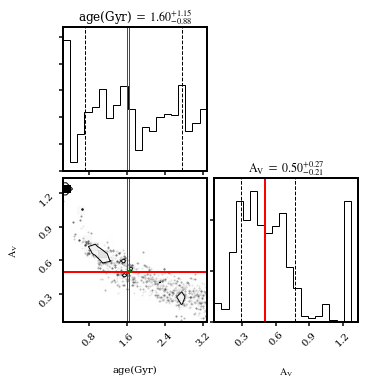

In [18]:
if samples.size > 1e3 :
    value2 = np.percentile(samples,50,axis=0)
    [std_age_prior_optimized_M13, std_AV_prior_optimized_M13] = np.std(samples, axis=0)
    plt.figure(figsize=(32,32),dpi=100)
    fig = corner.corner(samples,
         labels=["age(Gyr)", r"$\rm A_V$"],
         levels=(1-np.exp(-0.5),),
         truths=[age_prior_optimized_M13, AV_prior_optimized_M13],
         show_titles=True,title_kwargs={'fontsize':12},
                        quantiles=(0.16,0.5, 0.84))
    axes = np.array(fig.axes).reshape((ndim, ndim))
    for i in range(ndim):
        ax = axes[i, i]
        ax.axvline(X[i], color="g")
        ax.axvline(value2[i],color='r')
    # Loop over the histograms
    for yi in range(ndim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.axvline(X[xi], color="g")
            ax.axvline(value2[xi], color="r")
            ax.axhline(X[yi], color="g")
            ax.axhline(value2[yi], color="r")
            ax.plot(X[xi], X[yi], "sg")
            ax.plot(value2[xi],value2[yi],'sr')
    plt.rcParams.update({'font.size': 12})
    print('Maximum Likelihood Point M13:', np.percentile(samples, 50, axis=0), np.std(samples, axis=0))

#### 2.1.2 Plot the SED

Text(0.5, 0, 'Wavelength($\\rm \\AA$)')

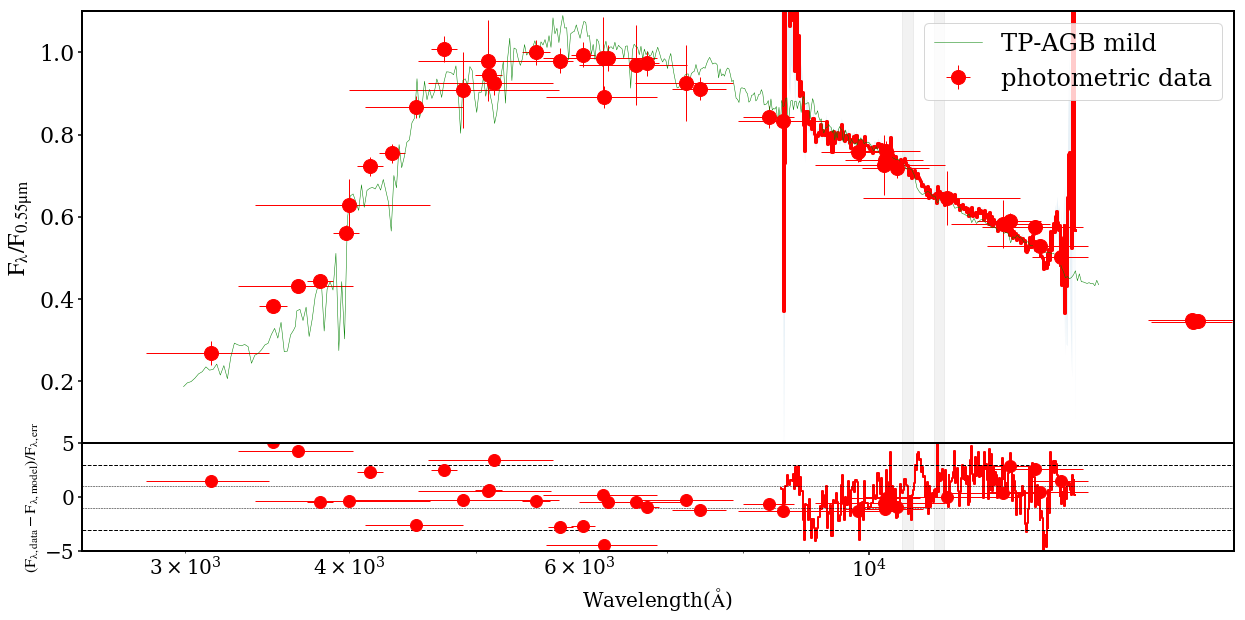

In [19]:
#--- Plot
X = np.percentile(samples, 50, axis=0)
x2_optimized = minimize_age_AV_vector_weighted_M13(X)
x2_spec, x2_phot = minimize_age_AV_vector_weighted_M13_return_chi2_sep(X)
chi_square_list.loc[row,'M13_age_MCMC50'] = X[0]#"{0:.2f}".format(X[0])
chi_square_list.loc[row,'M13_AV_MCMC50'] = X[1]#"{0:.2f}".format(X[1])
chi_square_list.loc[row,'x2_M13_MCMC50'] = x2_optimized
chi_square_list.loc[row,'x2_spectra_M13_MCMC50'] = x2_spec
chi_square_list.loc[row,'x2_photo_M13_MCMC50'] = x2_phot
chi_square_list.loc[row,'M13_age_std'] = np.std(samples, axis=0)[0]#"{0:.2f}".format(np.std(samples, axis=0)[0])
chi_square_list.loc[row,'M13_AV_std'] = np.std(samples, axis=0)[1]#"{0:.2f}".format(np.std(samples, axis=0)[1])

n = len(x)
fig1 = plt.figure(figsize=(20,10))
frame1 = fig1.add_axes((.1,.35,.8,.6))
plt.step(x, y, color='r',lw=3)
plt.fill_between(x,(y+y_err),(y-y_err),alpha=0.1)
plt.errorbar(wave_list, photometric_flux, xerr=band_list, yerr=photometric_flux_err, color='r', fmt='o', label='photometric data', markersize='14')
model_wave =minimize_age_AV_vector_weighted_M13_return_flux(X)[1]
model_flux =minimize_age_AV_vector_weighted_M13_return_flux(X)[2]
plt.plot(model_wave, model_flux, color='g',label='TP-AGB mild',lw=0.5)
plt.xlim([2.5e3,1.9e4])
plt.ylim([0.05, 1.1])#plt.ylim([ymin,ymax])
plt.semilogx()
plt.ylabel(r'$\rm F_{\lambda}/F_{0.55\mu m}$',fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc='upper right',fontsize=24)
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)

frame2 = fig1.add_axes((.1,.2,.8,.15))  
relative_spectra = np.zeros([1,n])
relative_spectra_err = np.zeros([1,n])
relative_sigma = np.zeros([1,n])
index0 = 0
for wave in x:
    if y[index0]>0.25 and y[index0]<1.35:
        index = find_nearest(model_wave, wave);#print index
        relative_spectra[0, index0] = y[index0]/model_flux[index]
        relative_spectra_err[0, index0] = y_err[index0]/model_flux[index]
        relative_sigma[0, index0] = (y[index0]-model_flux[index])/y_err[index0]
        index0 = index0+1
# plt.step(x[:index0], relative_spectra[0,:index0], color='r', linewidth=2)
# plt.fill_between(x[:index0],(relative_spectra[0,:index0]+relative_spectra_err[0,:index0]),\
#     (relative_spectra[0,:index0]-relative_spectra_err[0,:index0]),alpha=0.1)
plt.step(x[:index0], relative_sigma[0,:index0], color='r', linewidth=2)
index0 = 0
# relative_photo = np.zeros([1,(len(wave_list))])
for i in range(len(wave_list)):
    try:
        index = find_nearest(model_wave, wave_list[i])
        # relative_photo[0, index0] = model_flux[index]/(photometric_flux[i])
    except:
        pass
    # plt.errorbar(wave_list[i], (photometric_flux[i])/model_flux[index], xerr=band_list[i], yerr=photometric_flux_err[i]/model_flux[index], fmt='o', color='r', markersize=16)
    plt.errorbar(wave_list[i], (photometric_flux[i]-model_flux[index])/photometric_flux_err[i], xerr=band_list[i], fmt='o', color='r', markersize=12)
    index0 = index0+1
plt.xlim([2.5e3,1.9e4])
plt.semilogx()
# plt.axhline(1.0, linestyle='--', linewidth=2, color='k')
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
# plt.ylim([0.75,1.5])
# plt.ylim([0.9,1.1])
# plt.ylim([0.7,1.45])
plt.axhline(3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(-3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(1.0, linestyle='--', linewidth=0.5, color='k')
plt.axhline(-1.0, linestyle='--', linewidth=0.5, color='k')
plt.ylim([-5,5])
plt.ylabel(r'$\rm (F_{\lambda,\rm data}-F_{\lambda,\rm model})/F_{\lambda,\rm err}$',fontsize=16)
plt.xlabel(r'Wavelength($\rm \AA$)', fontsize=20)

#### 2.2.3 If not enough samples, run with a longer nsteps

In [ ]:
with Pool() as pool:
    ndim, nwalkers = 2, 10
    tik = time.clock()
    p0 = [sol_M13.x + 4.*np.random.rand(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lg_minimize_age_AV_vector_weighted_M13, pool=pool)
    sampler.run_mcmc(p0,nsteps*2,progress=True)
    samples = sampler.chain[:, 500:, :].reshape((-1,ndim))
    samples = samples[(samples[:,0] > age_prior_optimized_M13*0.1) & (samples[:,0] < age_prior_optimized_M13*2.0) & (samples[:,1] < AV_prior_optimized_M13*3.0)]
    tok = time.clock()
    multi_time = tok-tik
    print("Multiprocessing took {0:.1f} seconds".format(multi_time)) 
    print('Time to run M13 MCMC:'+str(tok-tik))
if samples.size > 1e3 :
    value2 = np.percentile(samples,50,axis=0)
    [std_age_prior_optimized_M13, std_AV_prior_optimized_M13] = np.std(samples, axis=0)
    plt.figure(figsize=(32,32),dpi=100)
    fig = corner.corner(samples,
         labels=["age(Gyr)", r"$\rm A_V$"],
         levels=(1-np.exp(-0.5),),
         truths=[age_prior_optimized_M13, AV_prior_optimized_M13],
         show_titles=True,title_kwargs={'fontsize':12},
                        quantiles=(0.16,0.5, 0.84))
    axes = np.array(fig.axes).reshape((ndim, ndim))
    for i in range(ndim):
        ax = axes[i, i]
        ax.axvline(X[i], color="g")
        ax.axvline(value2[i],color='r')
    # Loop over the histograms
    for yi in range(ndim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.axvline(X[xi], color="g")
            ax.axvline(value2[xi], color="r")
            ax.axhline(X[yi], color="g")
            ax.axhline(value2[yi], color="r")
            ax.plot(X[xi], X[yi], "sg")
            ax.plot(value2[xi],value2[yi],'sr')
    plt.rcParams.update({'font.size': 12})
    
    #--- Plot
    X = np.percentile(samples, 50, axis=0)
    x2_optimized = minimize_age_AV_vector_weighted_M13(X)
    x2_spec, x2_phot = minimize_age_AV_vector_weighted_M13_return_chi2_sep(X)
    chi_square_list.loc[row,'M13_age_MCMC50'] = X[0]#"{0:.2f}".format(X[0])
    chi_square_list.loc[row,'M13_AV_MCMC50'] = X[1]#"{0:.2f}".format(X[1])
    chi_square_list.loc[row,'x2_M13_MCMC50'] = x2_optimized
    chi_square_list.loc[row,'x2_spectra_M13_MCMC50'] = x2_spec
    chi_square_list.loc[row,'x2_photo_M13_MCMC50'] = x2_phot
    chi_square_list.loc[row,'M13_age_std'] = np.std(samples, axis=0)[0]#"{0:.2f}".format(np.std(samples, axis=0)[0])
    chi_square_list.loc[row,'M13_AV_std'] = np.std(samples, axis=0)[1]#"{0:.2f}".format(np.std(samples, axis=0)[1])

    n = len(x)
    fig1 = plt.figure(figsize=(20,10))
    frame1 = fig1.add_axes((.1,.35,.8,.6))
    plt.step(x, y, color='r',lw=3)
    plt.fill_between(x,(y+y_err),(y-y_err),alpha=0.1)
    plt.errorbar(wave_list, photometric_flux, xerr=band_list, yerr=photometric_flux_err, color='r', fmt='o', label='photometric data', markersize='14')
    model_wave =minimize_age_AV_vector_weighted_M13_return_flux(X)[1]
    model_flux =minimize_age_AV_vector_weighted_M13_return_flux(X)[2]
    plt.plot(model_wave, model_flux, color='g',label='TP-AGB mild',lw=0.5)
    plt.xlim([2.5e3,1.9e4])
    plt.ylim([0.05, 1.1])#plt.ylim([ymin,ymax])
    plt.semilogx()
    plt.ylabel(r'$\rm F_{\lambda}/F_{0.55\mu m}$',fontsize=24)
    plt.tick_params(axis='both', which='major', labelsize=22)
    plt.legend(loc='upper right',fontsize=24)
    plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
    plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)

    frame2 = fig1.add_axes((.1,.2,.8,.15))  
    relative_spectra = np.zeros([1,n])
    relative_spectra_err = np.zeros([1,n])
    relative_sigma = np.zeros([1,n])
    index0 = 0
    for wave in x:
        if y[index0]>0.25 and y[index0]<1.35:
            index = find_nearest(model_wave, wave);#print index
            relative_spectra[0, index0] = y[index0]/model_flux[index]
            relative_spectra_err[0, index0] = y_err[index0]/model_flux[index]
            relative_sigma[0, index0] = (y[index0]-model_flux[index])/y_err[index0]
            index0 = index0+1
    # plt.step(x[:index0], relative_spectra[0,:index0], color='r', linewidth=2)
    # plt.fill_between(x[:index0],(relative_spectra[0,:index0]+relative_spectra_err[0,:index0]),\
    #     (relative_spectra[0,:index0]-relative_spectra_err[0,:index0]),alpha=0.1)
    plt.step(x[:index0], relative_sigma[0,:index0], color='r', linewidth=2)
    # print(relative_sigma[0,:index0])
    index0 = 0
    # relative_photo = np.zeros([1,(len(wave_list))])
    for i in range(len(wave_list)):
        try:
            index = find_nearest(model_wave, wave_list[i])
            # relative_photo[0, index0] = model_flux[index]/(photometric_flux[i])
        except:
            pass
        plt.errorbar(wave_list[i], (photometric_flux[i]-model_flux[index])/photometric_flux_err[i], xerr=band_list[i], fmt='o', color='r', markersize=12)
        # plt.errorbar(wave_list[i], (photometric_flux[i])/model_flux[index], xerr=band_list[i], yerr=photometric_flux_err[i]/model_flux[index], fmt='o', color='r', markersize=16)
        index0 = index0+1
    plt.xlim([2.5e3,1.9e4])
    plt.semilogx()
    # plt.axhline(1.0, linestyle='--', linewidth=2, color='k')
    plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
    plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.tick_params(axis='both', which='minor', labelsize=20)
    # plt.ylim([0.75,1.5])
    # plt.ylim([0.9,1.1])
    # plt.ylim([0.7,1.45])
    plt.axhline(3.0, linestyle='--', linewidth=1, color='k')
    plt.axhline(-3.0, linestyle='--', linewidth=1, color='k')
    plt.axhline(1.0, linestyle='--', linewidth=0.5, color='k')
    plt.axhline(-1.0, linestyle='--', linewidth=0.5, color='k')
    plt.ylim([-5,5])
    plt.ylabel(r'$\rm (F_{\lambda,\rm data}-F_{\lambda,\rm model})/F_{\lambda,\rm err}$',fontsize=16)
    plt.xlabel(r'Wavelength($\rm \AA$)', fontsize=20)

## 3 Test with BC03

### 3.0 Optimization result

In [11]:
print('____________________BC03_________________________ Optimization__________________________')
bnds = ((0.0, 13.0), (0.0, 4.0))
X = np.array([galaxy_age,intrinsic_Av])
sol_BC03 = optimize.minimize(minimize_age_AV_vector_weighted_BC03, X, bounds = bnds, method='TNC')#, options = {'disp': True})
# print('Optimized BC03 weighted reduced chisqure result:', sol_BC03)
[age_prior_optimized_BC03, AV_prior_optimized_BC03] = sol_BC03.x
X = sol_BC03.x
x2_optimized = minimize_age_AV_vector_weighted_BC03(X)
x2_spec, x2_phot = minimize_age_AV_vector_weighted_BC03_return_chi2_sep(X)
chi_square_list.loc[row,'BC_age_opt'] = X[0]#"{0:.2f}".format(X[0])
chi_square_list.loc[row,'BC_AV_opt'] = X[1]#"{0:.2f}".format(X[1])
chi_square_list.loc[row,'x2_BC_opt'] = x2_optimized
chi_square_list.loc[row,'x2_spectra_BC_opt'] = x2_spec
chi_square_list.loc[row,'x2_photo_BC_opt'] = x2_phot


____________________BC03_________________________ Optimization__________________________


#### 3.0.1 Plot the SED

[1.27809997 0.59733551]


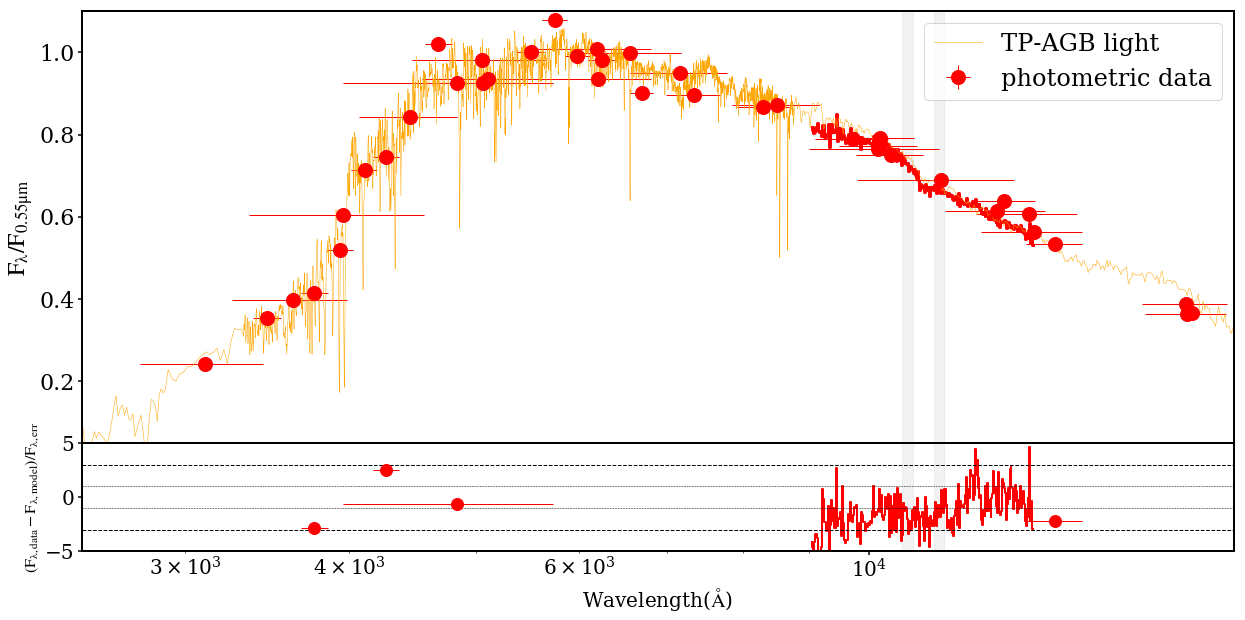

In [12]:
### Plot
X = sol_BC03.x
print(X)
n = len(x)
fig1 = plt.figure(figsize=(20,10))
frame1 = fig1.add_axes((.1,.35,.8,.6))
plt.step(x, y, color='r',lw=3)
plt.fill_between(x,(y+y_err),(y-y_err),alpha=0.1)
plt.errorbar(wave_list, photometric_flux, xerr=band_list, yerr=photometric_flux_err, color='r', fmt='o', label='photometric data', markersize='14')
BC03_flux_attenuated = minimize_age_AV_vector_weighted_BC03_mod_no_weight_return_flux(X)[1]
plt.plot(BC03_wave_list_num, BC03_flux_attenuated, color='orange',label='TP-AGB light',lw=0.5)
model_wave = BC03_wave_list_num
model_flux = BC03_flux_attenuated
model3_wave = BC03_wave_list_num
model3_flux = BC03_flux_attenuated
plt.xlim([2.5e3,1.9e4])
plt.ylim([0.05, 1.1])#plt.ylim([ymin,ymax])
plt.semilogx()
plt.ylabel(r'$\rm F_{\lambda}/F_{0.55\mu m}$',fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc='upper right',fontsize=24)
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)

frame2 = fig1.add_axes((.1,.2,.8,.15))  
relative_spectra = np.zeros([1,n])
relative_spectra_err = np.zeros([1,n])
relative_sigma = np.zeros([1,n])
index0 = 0
for wave in x:
    if y[index0]>0.25 and y[index0]<1.35:
        index = find_nearest(model_wave, wave);#print index
        relative_spectra[0, index0] = y[index0]/model_flux[index]
        relative_spectra_err[0, index0] = y_err[index0]/model_flux[index]
        relative_sigma[0, index0] = (y[index0]-model_flux[index])/y_err[index0]
        index0 = index0+1
# plt.step(x[:index0], relative_spectra[0,:index0], color='r', linewidth=2)
# plt.fill_between(x[:index0],(relative_spectra[0,:index0]+relative_spectra_err[0,:index0]),\
#     (relative_spectra[0,:index0]-relative_spectra_err[0,:index0]),alpha=0.1)
plt.step(x[:index0], relative_sigma[0,:index0], color='r', linewidth=2)
# print(relative_sigma[0,:index0])
index0 = 0
# relative_photo = np.zeros([1,(len(wave_list))])
for i in range(len(wave_list)):
    try:
        index = find_nearest(model_wave, wave_list[i])
        # relative_photo[0, index0] = model_flux[index]/(photometric_flux[i])
    except:
        pass
    plt.errorbar(wave_list[i], (photometric_flux[i]-model_flux[index])/photometric_flux_err[i], xerr=band_list[i], fmt='o', color='r', markersize=12)
    # plt.errorbar(wave_list[i], (photometric_flux[i])/model_flux[index], xerr=band_list[i], yerr=photometric_flux_err[i]/model_flux[index], fmt='o', color='r', markersize=16)
    index0 = index0+1
plt.xlim([2.5e3,1.9e4])
plt.semilogx()
# plt.axhline(1.0, linestyle='--', linewidth=2, color='k')
# plt.ylim([0.6,1.5])
# plt.ylim([0.9,1.1])
# plt.ylim([0.7,1.45])
plt.axhline(3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(-3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(1.0, linestyle='--', linewidth=0.5, color='k')
plt.axhline(-1.0, linestyle='--', linewidth=0.5, color='k')
plt.ylim([-5,5])
plt.ylabel(r'$\rm (F_{\lambda,\rm data}-F_{\lambda,\rm model})/F_{\lambda,\rm err}$',fontsize=16)
plt.xlabel(r'Wavelength($\rm \AA$)', fontsize=20)
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)

### 3.1 Running MCMC

In [370]:
with Pool() as pool:
    ndim, nwalkers = 2, 10
    tik = time.process_time()
    X = sol_BC03.x
    p0 = [sol_BC03.x + 4.*np.random.rand(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lg_minimize_age_AV_vector_weighted_BC03, pool=pool)
    sampler.run_mcmc(p0, nsteps, progress=True)
    samples = sampler.chain[:, 500:, :].reshape((-1,ndim))
    samples = samples[(samples[:,0] > age_prior_optimized_BC03*0.1) & (samples[:,0] < age_prior_optimized_BC03*2.0) & (samples[:,1] < AV_prior_optimized_BC03*3.0)]
    tok = time.process_time()
    multi_time = tok-tik
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    print('Time to run BC03 MCMC:'+str(tok-tik))

100%|██████████| 1200/1200 [02:15<00:00,  8.87it/s]


Multiprocessing took 6.6 seconds
Time to run BC03 MCMC:6.572006999999957


#### 3.1.1 Corner plot of MCMC

<Figure size 3200x3200 with 0 Axes>

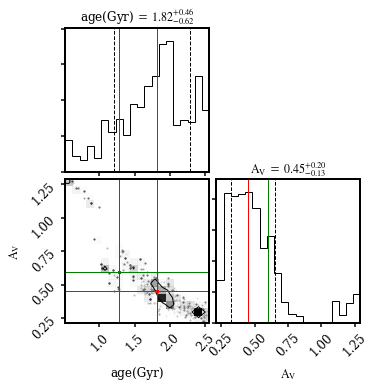

In [371]:
if samples.size > 1e3:
    value2 = np.percentile(samples,50,axis=0)
    [std_age_prior_optimized_BC03, std_AV_prior_optimized_BC03] = np.std(samples, axis=0)
    plt.figure(figsize=(32,32),dpi=100)
    fig = corner.corner(samples,
                        labels=["age(Gyr)", r"$\rm A_V$"],\
                        truths=[age_prior_optimized_BC03, AV_prior_optimized_BC03],\
                        levels = (1-np.exp(-0.5),),\
                        show_titles=True,title_kwargs={'fontsize':12},
                        quantiles=(0.16,0.5, 0.84))
    axes = np.array(fig.axes).reshape((ndim, ndim))
    for i in range(ndim):
        ax = axes[i, i]
        ax.axvline(X[i], color="g")
        ax.axvline(value2[i],color='r')
    # Loop over the histograms
    for yi in range(ndim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.axvline(X[xi], color="g")
            ax.axvline(value2[xi], color="r")
            ax.axhline(X[yi], color="g")
            ax.axhline(value2[yi], color="r")
            ax.plot(X[xi], X[yi], "sg")
            ax.plot(value2[xi],value2[yi],'sr')
    plt.rcParams.update({'font.size': 12})

#### 3.1.2 Plot the SED

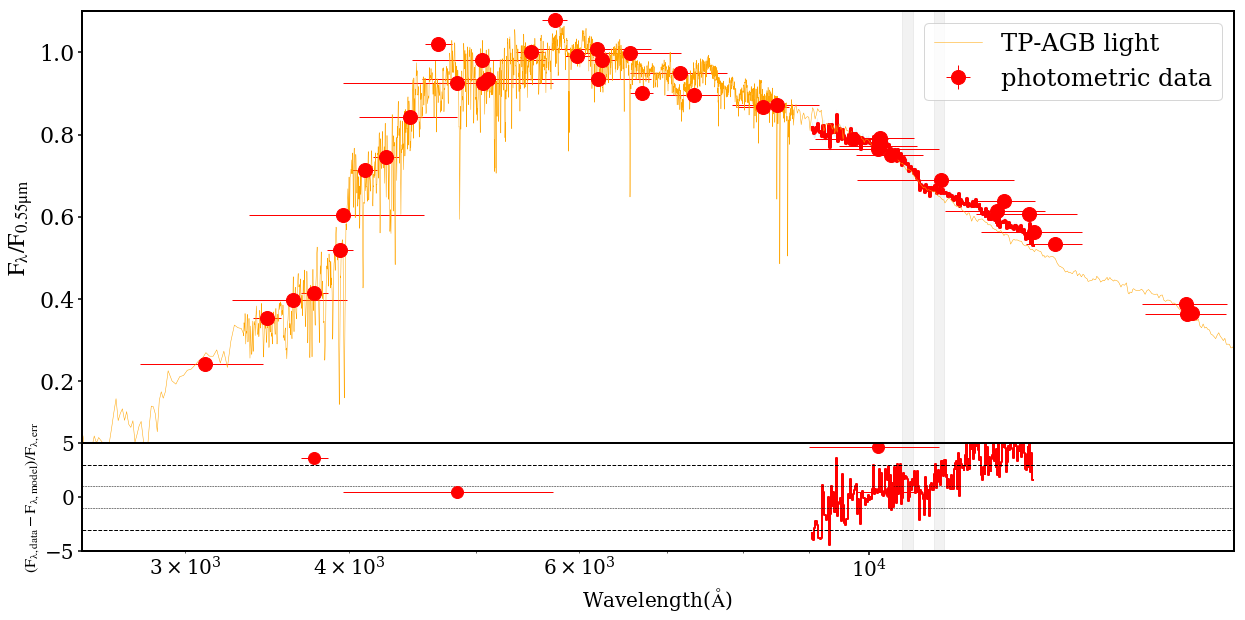

In [372]:
#--- Plot
X = np.percentile(samples, 50, axis=0)
x2_optimized = minimize_age_AV_vector_weighted_BC03(X)
x2_spec, x2_phot = minimize_age_AV_vector_weighted_BC03_return_chi2_sep(X)
chi_square_list.loc[row,'BC_age_MCMC50'] = X[0]#"{0:.2f}".format(X[0])
chi_square_list.loc[row,'BC_AV_MCMC50'] = X[1]#"{0:.2f}".format(X[1])
chi_square_list.loc[row,'x2_BC_MCMC50'] = x2_optimized
chi_square_list.loc[row,'x2_spectra_BC_MCMC50'] = x2_spec
chi_square_list.loc[row,'x2_photo_BC_MCMC50'] = x2_phot
chi_square_list.loc[row,'BC_age_std'] = np.std(samples, axis=0)[0]#"{0:.2f}".format(np.std(samples, axis=0)[0])
chi_square_list.loc[row,'BC_AV_std'] = np.std(samples, axis=0)[1]#"{0:.2f}".format(np.std(samples, axis=0)[1])
n = len(x)

fig1 = plt.figure(figsize=(20,10))
frame1 = fig1.add_axes((.1,.35,.8,.6))
plt.step(x, y, color='r',lw=3)
plt.fill_between(x,(y+y_err),(y-y_err),alpha=0.1)
plt.errorbar(wave_list, photometric_flux, xerr=band_list, yerr=photometric_flux_err, color='r', fmt='o', label='photometric data', markersize='14')
BC03_flux_attenuated = minimize_age_AV_vector_weighted_BC03_mod_no_weight_return_flux(X)[1]
plt.plot(BC03_wave_list_num, BC03_flux_attenuated, color='orange',label='TP-AGB light',lw=0.5)
model_wave = BC03_wave_list_num
model_flux = BC03_flux_attenuated
plt.xlim([2.5e3,1.9e4])
plt.ylim([0.05, 1.1])#plt.ylim([ymin,ymax])
plt.semilogx()
plt.ylabel(r'$\rm F_{\lambda}/F_{0.55\mu m}$',fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc='upper right',fontsize=24)
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)

frame2 = fig1.add_axes((.1,.2,.8,.15))  
relative_spectra = np.zeros([1,n])
relative_spectra_err = np.zeros([1,n])
relative_sigma = np.zeros([1,n])
index0 = 0
for wave in x:
    if y[index0]>0.25 and y[index0]<1.35:
        index = find_nearest(model_wave, wave);#print index
        relative_spectra[0, index0] = y[index0]/model_flux[index]
        relative_spectra_err[0, index0] = y_err[index0]/model_flux[index]
        relative_sigma[0, index0] = (y[index0]-model_flux[index])/y_err[index0]
        index0 = index0+1
plt.step(x[:index0], relative_sigma[0,:index0], color='r', linewidth=2)
plt.errorbar(wave_list[i], (photometric_flux[i]-model_flux[index])/photometric_flux_err[i], xerr=band_list[i], fmt='o', color='r', markersize=12)

index0 = 0
# relative_photo = np.zeros([1,(len(wave_list))])
for i in range(len(wave_list)):
    try:
        index = find_nearest(model_wave, wave_list[i])
        # relative_photo[0, index0] = model_flux[index]/(photometric_flux[i])
    except:
        pass
    plt.errorbar(wave_list[i], (photometric_flux[i]-model_flux[index])/photometric_flux_err[i], xerr=band_list[i], fmt='o', color='r', markersize=12)
    # plt.errorbar(wave_list[i], (photometric_flux[i])/model_flux[index], xerr=band_list[i], yerr=photometric_flux_err[i]/model_flux[index], fmt='o', color='r', markersize=16)
    index0 = index0+1
plt.xlim([2.5e3,1.9e4])
plt.semilogx()
# plt.axhline(1.0, linestyle='--', linewidth=2, color='k')
# plt.ylim([0.6,1.5])
# plt.ylim([0.9,1.1])
# plt.ylim([0.7,1.45])
plt.axhline(3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(-3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(1.0, linestyle='--', linewidth=0.5, color='k')
plt.axhline(-1.0, linestyle='--', linewidth=0.5, color='k')
plt.ylim([-5,5])
plt.ylabel(r'$\rm (F_{\lambda,\rm data}-F_{\lambda,\rm model})/F_{\lambda,\rm err}$',fontsize=16)
plt.xlabel(r'Wavelength($\rm \AA$)', fontsize=20)
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)

#### 3.1.3 If not enough samples, run with a longer steps 

In [ ]:
with Pool() as pool:
    ndim, nwalkers = 2, 10
    tik = time.clock()
    X = sol_BC03.x
    p0 = [sol_BC03.x + 4.*np.random.rand(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lg_minimize_age_AV_vector_weighted_BC03, pool=pool)
    sampler.run_mcmc(p0, nsteps*2, progress=True)
    samples = sampler.chain[:, 500:, :].reshape((-1,ndim))
    samples = samples[(samples[:,0] > age_prior_optimized_BC03*0.1) & (samples[:,0] < age_prior_optimized_BC03*2.0) & (samples[:,1] < AV_prior_optimized_BC03*3.0)]
    tok = time.clock()
    multi_time = tok-tik
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    print('Time to run BC03 MCMC:'+str(tok-tik))
if samples.size > 1e3:
    value2 = np.percentile(samples,50,axis=0)
    [std_age_prior_optimized_BC03, std_AV_prior_optimized_BC03] = np.std(samples, axis=0)
    plt.figure(figsize=(32,32),dpi=100)
    fig = corner.corner(samples,
                        labels=["age(Gyr)", r"$\rm A_V$"],\
                        truths=[age_prior_optimized_BC03, AV_prior_optimized_BC03],\
                        levels = (1-np.exp(-0.5),),\
                        show_titles=True,title_kwargs={'fontsize':12},
                        quantiles=(0.16,0.5, 0.84))
    axes = np.array(fig.axes).reshape((ndim, ndim))
    for i in range(ndim):
        ax = axes[i, i]
        ax.axvline(X[i], color="g")
        ax.axvline(value2[i],color='r')
    # Loop over the histograms
    for yi in range(ndim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.axvline(X[xi], color="g")
            ax.axvline(value2[xi], color="r")
            ax.axhline(X[yi], color="g")
            ax.axhline(value2[yi], color="r")
            ax.plot(X[xi], X[yi], "sg")
            ax.plot(value2[xi],value2[yi],'sr')
    plt.rcParams.update({'font.size': 12})
    print('Maximum Likelihood Point BC03:', np.percentile(samples, 50, axis=0), np.std(samples, axis=0))

    #--- Plot
    X = np.percentile(samples, 50, axis=0)
    x2_optimized = minimize_age_AV_vector_weighted_BC03(X)
    x2_spec, x2_phot = minimize_age_AV_vector_weighted_BC03_return_chi2_sep(X)
    chi_square_list.loc[row,'BC_age_MCMC50'] = X[0]#"{0:.2f}".format(X[0])
    chi_square_list.loc[row,'BC_AV_MCMC50'] = X[1]#"{0:.2f}".format(X[1])
    chi_square_list.loc[row,'x2_BC_MCMC50'] = x2_optimized
    chi_square_list.loc[row,'x2_spectra_BC_MCMC50'] = x2_spec
    chi_square_list.loc[row,'x2_photo_BC_MCMC50'] = x2_phot
    chi_square_list.loc[row,'BC_age_std'] = np.std(samples, axis=0)[0]#"{0:.2f}".format(np.std(samples, axis=0)[0])
    chi_square_list.loc[row,'BC_AV_std'] = np.std(samples, axis=0)[1]#"{0:.2f}".format(np.std(samples, axis=0)[1])
    n = len(x)

    fig1 = plt.figure(figsize=(20,10))
    frame1 = fig1.add_axes((.1,.35,.8,.6))
    plt.step(x, y, color='r',lw=3)
    plt.fill_between(x,(y+y_err),(y-y_err),alpha=0.1)
    plt.errorbar(wave_list, photometric_flux, xerr=band_list, yerr=photometric_flux_err, color='r', fmt='o', label='photometric data', markersize='14')
    BC03_flux_attenuated = minimize_age_AV_vector_weighted_BC03_mod_no_weight_return_flux(X)[1]
    plt.plot(BC03_wave_list_num, BC03_flux_attenuated, color='orange',label='TP-AGB light',lw=0.5)
    model_wave = BC03_wave_list_num
    model_flux = BC03_flux_attenuated
    plt.xlim([2.5e3,1.9e4])
    plt.ylim([0.05, 1.1])#plt.ylim([ymin,ymax])
    plt.semilogx()
    plt.ylabel(r'$\rm F_{\lambda}/F_{0.55\mu m}$',fontsize=24)
    plt.tick_params(axis='both', which='major', labelsize=22)
    plt.legend(loc='upper right',fontsize=24)
    plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
    plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)

    frame2 = fig1.add_axes((.1,.2,.8,.15))  
    relative_spectra = np.zeros([1,n])
    relative_spectra_err = np.zeros([1,n])
    relative_sigma = np.zeros([1,n])
    index0 = 0
    for wave in x:
        if y[index0]>0.25 and y[index0]<1.35:
            index = find_nearest(model_wave, wave);#print index
            relative_spectra[0, index0] = y[index0]/model_flux[index]
            relative_spectra_err[0, index0] = y_err[index0]/model_flux[index]
            relative_sigma[0, index0] = (y[index0]-model_flux[index])/y_err[index0]
            index0 = index0+1
    plt.step(x[:index0], relative_sigma[0,:index0], color='r', linewidth=2)
    # print(relative_sigma[0,:index0])
    # plt.step(x[:index0], relative_spectra[0,:index0], color='r', linewidth=2)
    # plt.fill_between(x[:index0],(relative_spectra[0,:index0]+relative_spectra_err[0,:index0]),\
    #     (relative_spectra[0,:index0]-relative_spectra_err[0,:index0]),alpha=0.1)
    index0 = 0
    # relative_photo = np.zeros([1,(len(wave_list))])
    for i in range(len(wave_list)):
        try:
            index = find_nearest(model_wave, wave_list[i])
            # relative_photo[0, index0] = model_flux[index]/(photometric_flux[i])
        except:
            pass
        plt.errorbar(wave_list[i], (photometric_flux[i]-model_flux[index])/photometric_flux_err[i], xerr=band_list[i], fmt='o', color='r', markersize=12)
        # plt.errorbar(wave_list[i], (photometric_flux[i])/model_flux[index], xerr=band_list[i], yerr=photometric_flux_err[i]/model_flux[index], fmt='o', color='r', markersize=16)
        index0 = index0+1
    plt.xlim([2.5e3,1.9e4])
    plt.semilogx()
    # plt.axhline(1.0, linestyle='--', linewidth=2, color='k')
    # plt.ylim([0.6,1.5])
    # plt.ylim([0.9,1.1])
    # plt.ylim([0.7,1.45])
    plt.axhline(3.0, linestyle='--', linewidth=1, color='k')
    plt.axhline(-3.0, linestyle='--', linewidth=1, color='k')
    plt.axhline(1.0, linestyle='--', linewidth=0.5, color='k')
    plt.axhline(-1.0, linestyle='--', linewidth=0.5, color='k')
    plt.ylim([-5,5])
    plt.ylabel(r'$\rm (F_{\lambda,\rm data}-F_{\lambda,\rm model})/F_{\lambda,\rm err}$',fontsize=16)
    plt.xlabel(r'Wavelength($\rm \AA$)', fontsize=20)
    plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
    plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.tick_params(axis='both', which='minor', labelsize=20)

## 4 Determine the best-fit model

In [42]:
chi2_array=chi_square_list.loc[row,['x2_M05_opt','x2_M13_opt','x2_BC_opt','x2_M05_MCMC50','x2_M13_MCMC50','x2_BC_MCMC50']].values
AV_array=chi_square_list.loc[row,['M05_AV_opt','M13_AV_opt','BC_AV_opt','M05_AV_MCMC50','M13_AV_MCMC50','BC_AV_MCMC50']].values
index = find_nearest(chi2_array,0)
model = np.mod(index,3)+1
print(chi2_array)
print(model)

[0.3649215172219611 0.34945955731534467 0.4024687907469769
 1.0278437522905066 0.3934117016880912 0.4429608584463262]
2


## 5 Calculate the flux ratio with the CN absorption feature in the NIR at 1.1 micron

In [17]:
AV_opt = float(AV_array[index])
spectra_extinction = calzetti00(x, AV_opt, 4.05)
spectra_flux_correction = 10 ** (-0.4 * spectra_extinction)
y_corr = y / spectra_flux_correction

if redshift<0.49:
    try:
        chi_square_list.loc[row,'grism_index_AV_corr'] = Lick_index_ratio(x,y_corr)
        print('Measured CN index with AV correction',Lick_index_ratio(x,y_corr))
    except:
        pass 

NameError: name 'AV_array' is not defined

## 6 Testing with photometry and the convolution

0.2311
f1_u_megaprime_sagem.res.txt
f2_g_megaprime_sagem.res.txt
f3_r_megaprime_sagem.res.txt
f4_i_megaprime_sagem.res.txt
f5_z_megaprime_sagem.res.txt
f6_ACS_F606W.res.txt
f7_ACS_F814W.res.txt
f8_hst_wfc3F125W.res.txt
f9_hst_wfc3F140W.res.txt
f10_hst_wfc3F160W.res.txt
f11_J1.res.txt
f12_J2.res.txt
f13_J3.res.txt
f14_H1.res.txt
f15_H2.res.txt
f16_Ks_newfirm.res.txt
f17_CFHT_Wircam.J.dat.txt
f18_wircam_H.res.txt
f19_wircam_Ks.res.txt
f20_Y_uv.res.txt
f21_H_uv.res.txt
f22_J_uv.res.txt
f23_K_uv.res.txt
f24_B_subaru.res.txt
f25_V_subaru.res.txt
f26_r_subaru.res.txt
f27_i_subaru.res.txt
f28_z_subaru.res.txt
f29_IB427.SuprimeCam.pb.txt
f30_IB464.SuprimeCam.pb.txt
f31_IB484.SuprimeCam.pb.txt
f32_IB505.SuprimeCam.pb.txt
f33_IB527.SuprimeCam.pb.txt
f34_IB574.SuprimeCam.pb.txt
f35_IB624.SuprimeCam.pb.txt
f36_IB679.SuprimeCam.pb.txt
f37_IB709.SuprimeCam.pb.txt
f38_IB738.SuprimeCam.pb.txt
f39_IB767.SuprimeCam.pb.txt
f40_IB827.SuprimeCam.pb.txt


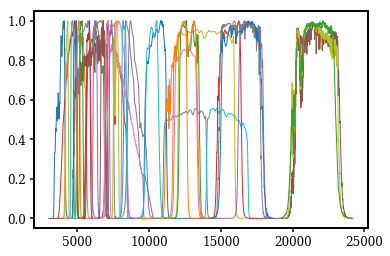

In [13]:
print(redshift_1)
filter_fn_list = []
path = "/Volumes/My Passport/TAPS/filter/cosmos/"
import glob, os
os.chdir(path)
for i in range(1,41):
    for file in glob.glob("f"+str(i)+"_*"):
        print(file)
        fn = path+file
        filter_fn_list.append(fn)
# filter_fn_list[0]
    filter_curve = np.loadtxt(fn)
#     print(filter_curve.size)#[:,0]
    plt.plot(filter_curve[:,0],filter_curve[:,1])

In [94]:
model_wave = model2_wave*(1+redshift_1)
model_flux = model2_flux
def all_same(items):
    return all(x == items[0] for x in items)

1 f1_u_megaprime_sagem.res.txt
546
3823.29 0.26136642692061557 [101.14371045] [386.98049954] 36
2 f2_g_megaprime_sagem.res.txt
902
4877.37 0.578403536667071 [754.36126336] [1304.21274342] 92
3 f3_r_megaprime_sagem.res.txt
950
6230.619999999999 0.9624190971862977 [1051.83369685] [1092.90609458] 96
4 f4_i_megaprime_sagem.res.txt
1078
7617.66 0.9953904437668737 [1163.52511878] [1168.91329032] 109
5 f5_z_megaprime_sagem.res.txt
1082
8827.98 0.9325422519565372 [921.6912512] [988.36406529] 109
6 f6_hst_acsF606W.res.txt
5758
5962.229999999999 0.8938020733009593 [853.58574603] [955.00533231] 117
7 f7_hst_acs_F814W.res.txt
708
8073.430000000001 0.9711749529075626 [759.63044986] [782.17673097] 140
8 f8_hst_wfc3F125W.res.txt
934
12501.05 0.7455564599968989 [1189.08576279] [1594.89700189] 132
9 f9_hst_wfc3F140W.res.txt
6242
13970.98 0.6625483160580375 [2464.6699823] [3719.98527891] 164
10 f10_hst_wfc3F160W.res.txt
724
15418.27 0.5909970358437995 [882.30806335] [1492.91453229] 59
11 f11_newfirm_J1.

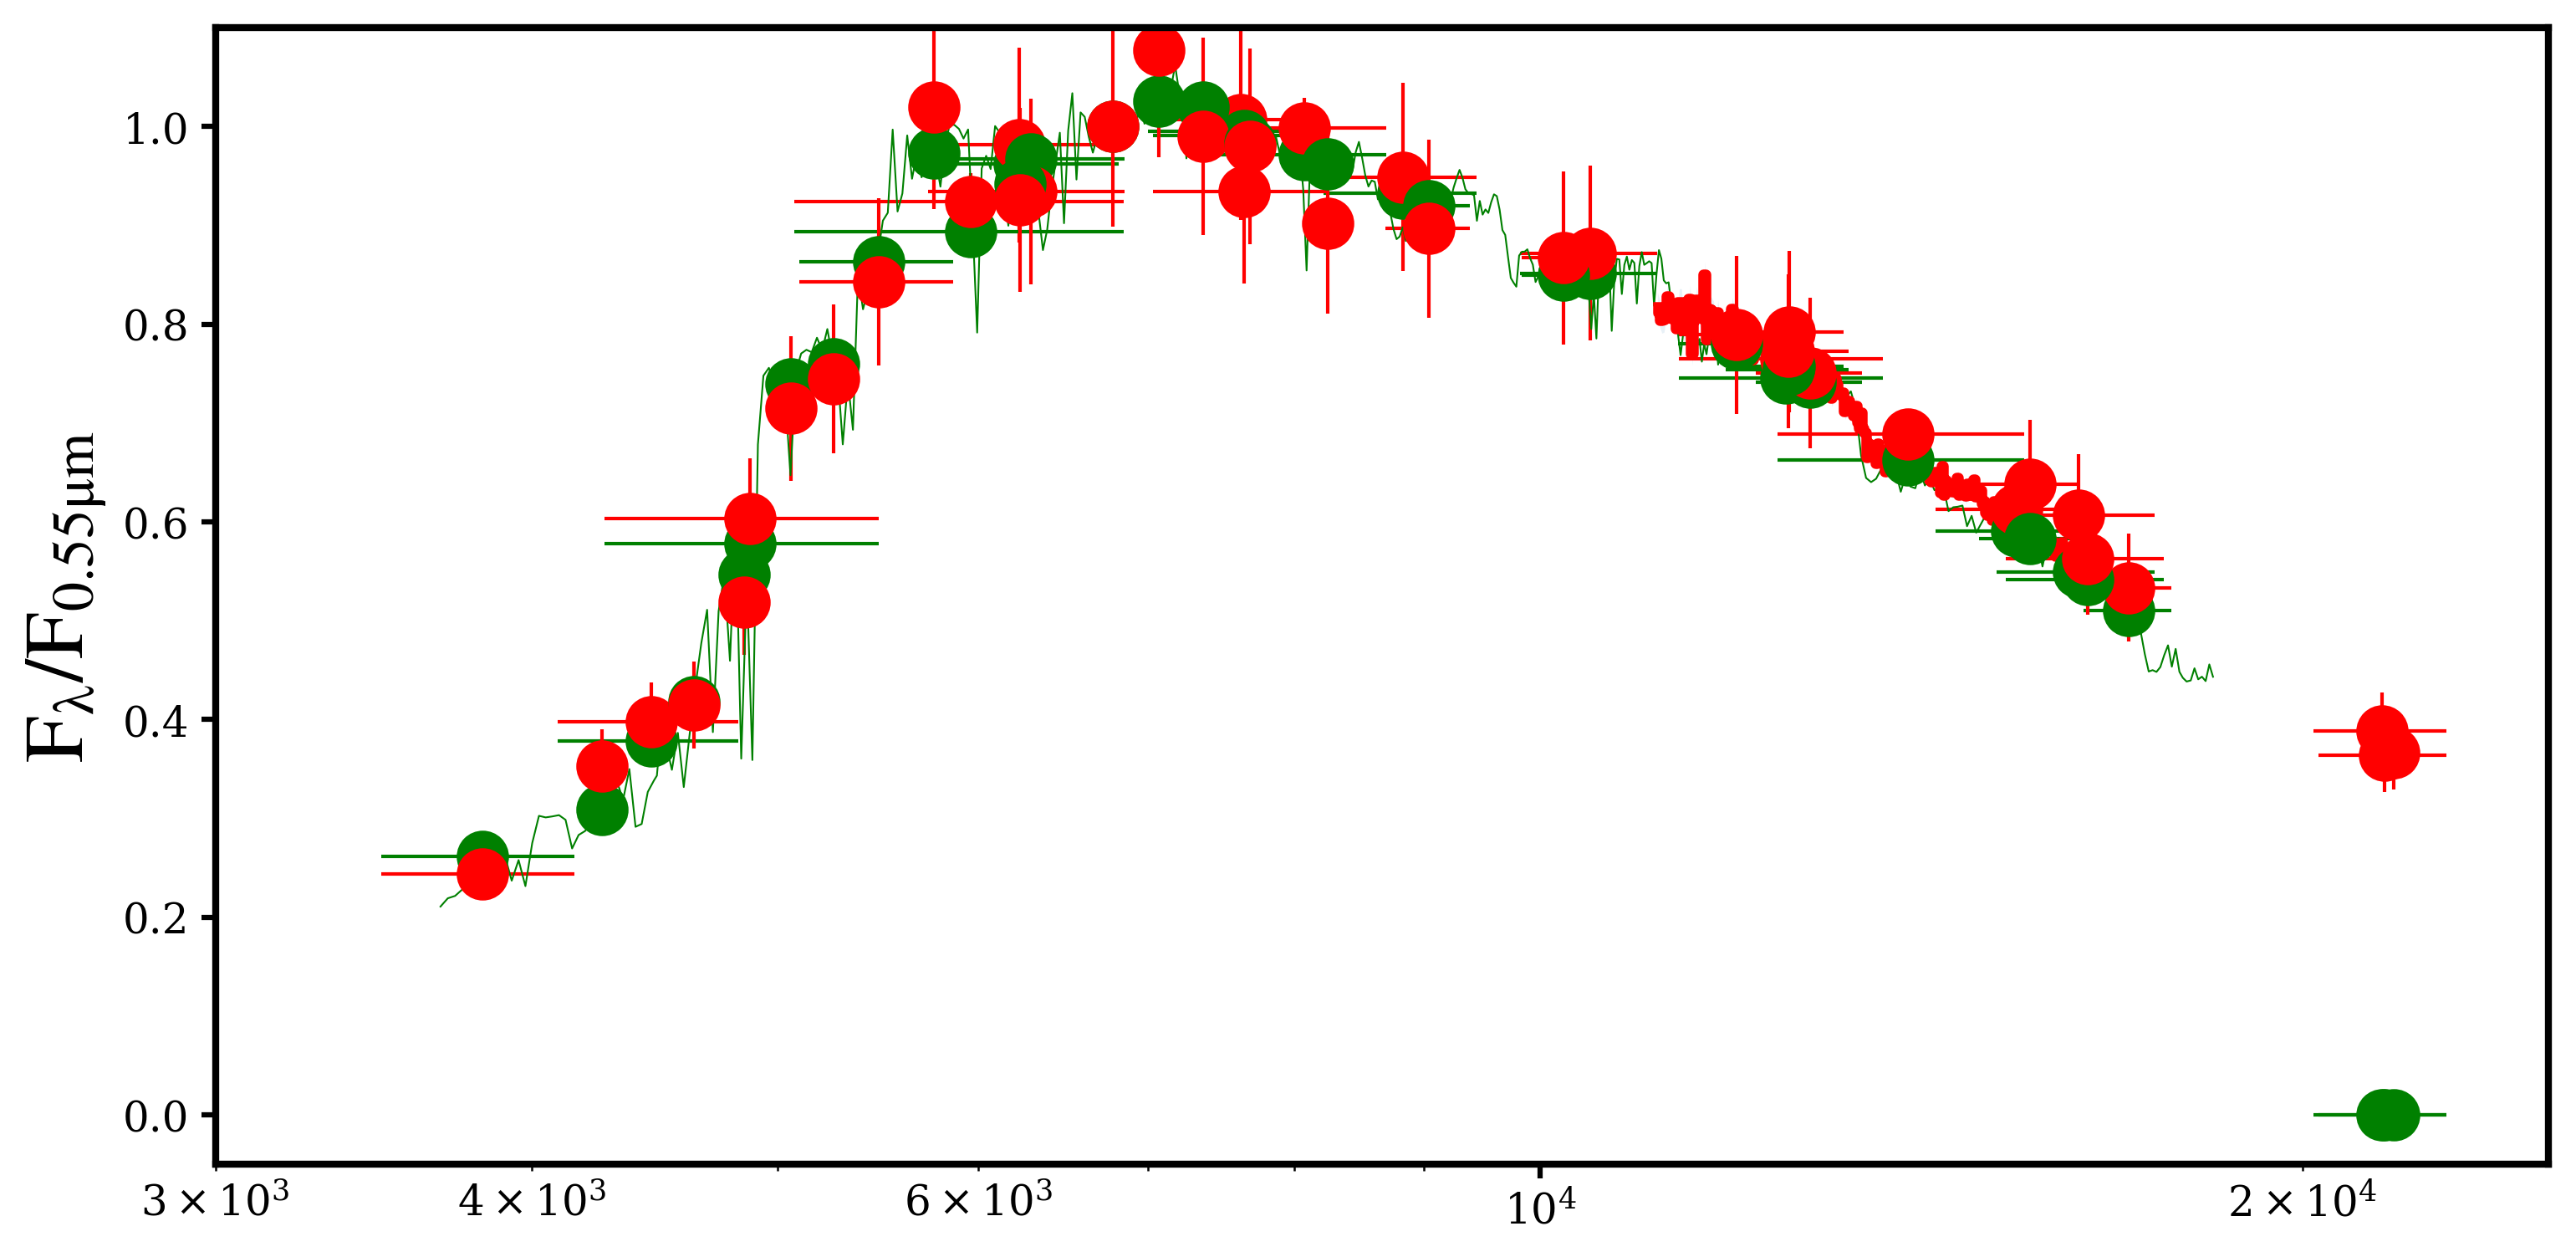

In [95]:
def all_same(items):
    return all(x == items[0] for x in items)

plt.figure(figsize=(12,6),dpi=300)
plt.plot(model_wave, model_flux, color='green',lw=0.5)
photometry_list = np.zeros(len(wave_list))
plt.xlim([3.e3,2.5e4])
plt.ylim([-0.05, 1.1])
plt.semilogx()
plt.step(x*(1+redshift_1), y, color='r',lw=3)
plt.fill_between(x*(1+redshift_1),(y+y_err),(y-y_err),alpha=0.1)
plt.ylabel(r'$\rm F_{\lambda}/F_{0.55\mu m}$',fontsize=24)

for i in range(1,41):
    for file in glob.glob("f"+str(i)+"_*"):
        print(i,file)
        fn = path+file
        filter_fn_list.append(fn)
        filter_curve = np.loadtxt(fn)
        print(filter_curve.size)#[:,0]
        
    sum_flambda_AB_K = 0
    sum_transmission = 0
    length = 0

    for j in range(len(filter_curve)-1):
        wave_inter = np.zeros(len(model_wave))
        wave_inter[:-1] = np.diff(model_wave)
        index = np.where(model_wave<filter_curve[j+1,0])[0]#[0]
        wave = model_wave[index]
        flux = model_flux[index]
        wave_inter = wave_inter[index]
        index = np.where(wave>filter_curve[j,0])
        wave = wave[index]
        flux = flux[index]
        wave_inter = wave_inter[index]
        n = len(flux)
        if n!= 0 and n!=1:
            try:
                transmission = np.interp(wave, filter_curve[j:j+2,0], filter_curve[j:j+2,1])
            except:
                print('Error')
            # Checking if all spectral elements are the same
            if all_same(wave_inter):
                flambda_AB_K = np.sum(flux*transmission)
                sum_flambda_AB_K += flambda_AB_K
                sum_transmission += np.sum(transmission)
                length = length+1
            else:
                flambda_AB_K = np.sum(flux*transmission*wave_inter)
                sum_flambda_AB_K += flambda_AB_K
                sum_transmission += np.sum(transmission*wave_inter)
                length = length+1
        elif n==1:
            transmission = np.interp(wave, filter_curve[j:j+2,0], filter_curve[j:j+2,1])
            flambda_AB_K = flux[0]*transmission[0]
            sum_flambda_AB_K += flambda_AB_K*wave_inter
            sum_transmission += np.sum(transmission)*wave_inter#/len(transmission)#np.trapz(transmission, x=wave)
            length = length+1
    if length == 0:
        photometry_list[i-1]=0
    else:
        photometry_list[i-1] = sum_flambda_AB_K/sum_transmission
        print(wave_list[i-1]*(1+redshift_1), photometry_list[i-1], sum_flambda_AB_K, sum_transmission,length)#, wave[int(n/2)])
    plt.errorbar(wave_list[i-1]*(1+redshift_1),photometry_list[i-1],\
                 xerr=band_list[i-1], color='g', fmt='o',  markersize=14)
    plt.errorbar(wave_list[i-1]*(1+redshift_1), photometric_flux[i-1],\
                 xerr=band_list[i-1], yerr=photometric_flux_err_mod[i-1], color='r', fmt='o', label='photometric data', markersize='14')
chisquare_photo_list = ((photometric_flux-photometry_list)/photometric_flux_err_mod)**2


In [68]:
chisquare_photo_list = ((photometric_flux-photometry_list)/photometric_flux_err_mod)**2
print(chisquare_photo_list)
print(np.sum(chisquare_photo_list))

[9.45491974e-03 2.10018456e-01 1.74618768e-01 5.63594573e-02
 1.37085513e-02 3.26163753e+00 1.17648794e+00 3.12403033e-01
 2.76036351e-02 4.16561253e-01 3.53119052e-04 1.27859158e-01
 5.35586668e-02 5.87603562e-01 2.24917864e-02 9.05854088e-01
 2.70635932e-03 6.17041385e-01 2.30322609e-01 1.77118328e-02
 1.80511756e-02 3.71729221e-02 1.55491205e+00 5.42144803e-02
 6.61704950e-03 1.08348618e-02 2.28336539e-01 1.50601288e-01
 2.35401870e-01 2.25889103e-05 1.31785087e-01 1.16563100e-03
 2.06261422e-02 7.56407193e-01 7.68972074e-03 5.39472599e-02
 5.11432839e-01 1.37594246e-02 1.91126233e-04 3.31963881e-01]
12.34948923337286


In [93]:
chi2_M05 = chisquare_photo(model1_wave, model1_flux, redshift_1,wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod)
chi2_M13 = chisquare_photo(model2_wave, model2_flux, redshift_1,wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod)
chi2_BC = chisquare_photo(model3_wave, model3_flux, redshift_1,wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod)


1 f1_u_megaprime_sagem.res.txt
2 f2_g_megaprime_sagem.res.txt
3 f3_r_megaprime_sagem.res.txt
4 f4_i_megaprime_sagem.res.txt
5 f5_z_megaprime_sagem.res.txt
6 f6_hst_acsF606W.res.txt
7 f7_hst_acs_F814W.res.txt
8 f8_hst_wfc3F125W.res.txt
9 f9_hst_wfc3F140W.res.txt
10 f10_hst_wfc3F160W.res.txt
11 f11_newfirm_J1.res
12 f12_newfirm_J2.res
13 f13_newfirm_J3.res
14 f14_newfirm_H1.res
15 f15_newfirm_H2.res
16 f16_newfirm_Ks.res
17 f17_wircam_J.res
18 f18_wircam_H.res.txt
19 f19_wircam_Ks.res.txt
20 f20_Y_uv.res.txt
21 f21_J_uv.res.txt
22 f22_H_uv.res.txt
23 f23_K_uv.res.txt
24 f24_B_subaru.res.txt
25 f25_V_subaru.res.txt
26 f26_r_subaru.res.txt
27 f27_i_subaru.res.txt
28 f28_z_subaru.res.txt
29 f29_IB427.SuprimeCam.pb.txt
30 f30_IB464.SuprimeCam.pb.txt
31 f31_IB484.SuprimeCam.pb.txt
32 f32_IB505.SuprimeCam.pb.txt
33 f33_IB527.SuprimeCam.pb.txt
34 f34_IB574.SuprimeCam.pb.txt
35 f35_IB624.SuprimeCam.pb.txt
36 f36_IB679.SuprimeCam.pb.txt
37 f37_IB709.SuprimeCam.pb.txt
38 f38_IB738.SuprimeCam.pb.tx